In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.getcwd()
os.chdir('C:\\')
path = 'd:\\Jupyter_note\\!_crp_crqa_Bielinsky\\crp_classic\\stress_strain_07_04_2022\\11\\150_1\\' # Шлях звідки зсчитувати та зберігати файли

In [3]:
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius, Unthresholded
from pyrqa.metric import EuclideanMetric, MaximumMetric, TaxicabMetric
from pyrqa.computation import RQAComputation
from pyrqa.time_series import TimeSeries
from pyrqa.image_generator import ImageGenerator
from pyrqa.computation import RPComputation
from pyrqa.analysis_type import Classic

In [4]:
plt.style.use('classic')
plt.rcParams.update({'legend.fontsize': 26})
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams['font.size'] = '26'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['savefig.dpi'] = 300
xlabel = 'strain'

## Зчитування з Yahoo Finance

In [ ]:
symbol = "^GSPC"
symbol_for_graph = "^GSPC"
data = yf.download(symbol, start='2001-01-01')
time_ser = data['Adj Close'].copy()
for_graph = data['Adj Close'].copy()
np.savetxt(path+f'{symbol}_initial_time_series.txt', time_ser.values)

## Зчитування з .txt файлів

In [5]:
symbol = "sMpa11.txt" #назва файлу, що зчитуємо
with open(path+symbol, 'r') as f1: #зчитуємо файл
    time_ser = [line.strip('\n') for line in f1.readlines()]
    time_ser = [float(line) for line in time_ser if line != '']
time_ser = pd.Series(time_ser) #перетворюємо на масив pandas для використання вбудованих функцій знаходження приб., видалення нульових значень

In [6]:
symbol_for_graph = "Mpa11.txt"
with open(path+symbol_for_graph, 'r') as f2: #зчитуємо файл
    for_graph = [line.strip('\n') for line in f2.readlines()]
    for_graph = [float(line) for line in for_graph if line != '']
for_graph = pd.Series(for_graph) #перетворюємо на масив pandas для використання вбудованих функцій знаходження приб., видалення нульових значень

## Виведення графіку досліджуваного ряду

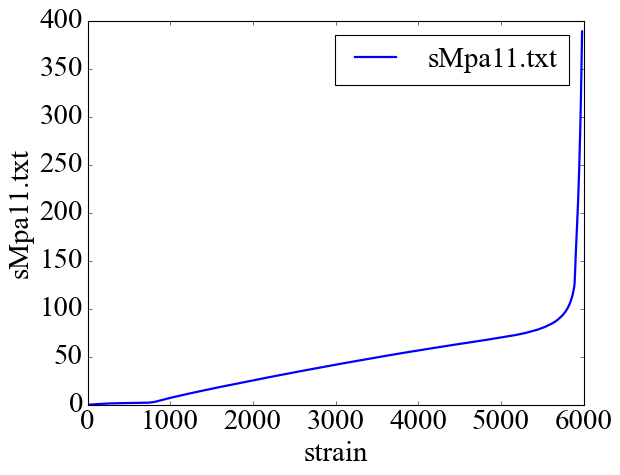

In [7]:
fig, ax = plt.subplots()
time_ser.plot(figsize=(8,6), xlabel=xlabel, ylabel=symbol)
ax.legend([symbol]);

plt.savefig(path+f'{symbol}.jpg')
plt.show()

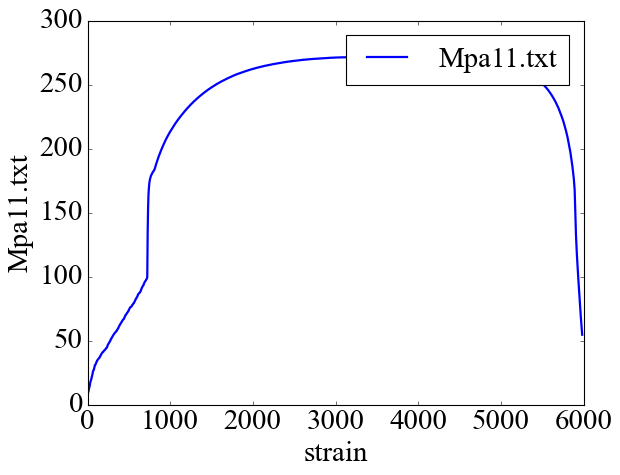

In [8]:
fig, ax = plt.subplots()
for_graph.plot(figsize=(8,6), xlabel=xlabel, ylabel=symbol_for_graph)
ax.legend([symbol_for_graph]);

plt.savefig(path+f'{symbol_for_graph}.jpg')
plt.show()

# Задання ширини вікна та кроку

In [9]:
window =150
tstep = 1

## Побудова рекурентної карти всього часового ряду

In [10]:
for_rec = time_ser.copy()
ret_type = 4 #вид ряду: 1 - вихідний, 2 - детрендований (різниця між теп. значенням та попереднім)
                        # 3 - прибутковості звичайні, 
                        # 4 - стандартизовані прибутковості, 
                        # 5 - абсолютні значення (волатильності)
                        # 6 - стандартизований ряд


if ret_type == 1:
    pass
elif ret_type == 2:
    for_rec = for_rec.diff()
elif ret_type == 3:
    for_rec = for_rec.pct_change()
elif ret_type == 4:
    for_rec = for_rec.pct_change()
    for_rec -= for_rec.mean()
    for_rec /= for_rec.std()
elif ret_type == 5: 
    for_rec = for_rec.pct_change()
    for_rec -= for_rec.mean()
    for_rec /= for_rec.std()
    for_rec = for_rec.abs()
elif ret_type == 6:
    for_rec -= for_rec.mean()
    for_rec /= for_rec.std()

for_rec = for_rec.dropna().values

In [15]:
d_e = 1 # розмірність вкладень
tau = 1 # часові затримка
theiler_wind = 1 # вікно Тейлера
sim_measure = EuclideanMetric # TaxicabMetric (L1), EuclideanMetric (L2), MaximumMetric (L_inf)
eps = 0.1 # радіус

In [16]:
whole_series = TimeSeries(for_rec,
                         embedding_dimension=d_e,
                         time_delay=tau)


settings = Settings(whole_series,
                    analysis_type=Classic,
                    neighbourhood=FixedRadius(eps),
                    similarity_measure=sim_measure,
                    theiler_corrector=theiler_wind)

In [17]:
rp_computation = RPComputation.create(settings)
rp_result = rp_computation.run()

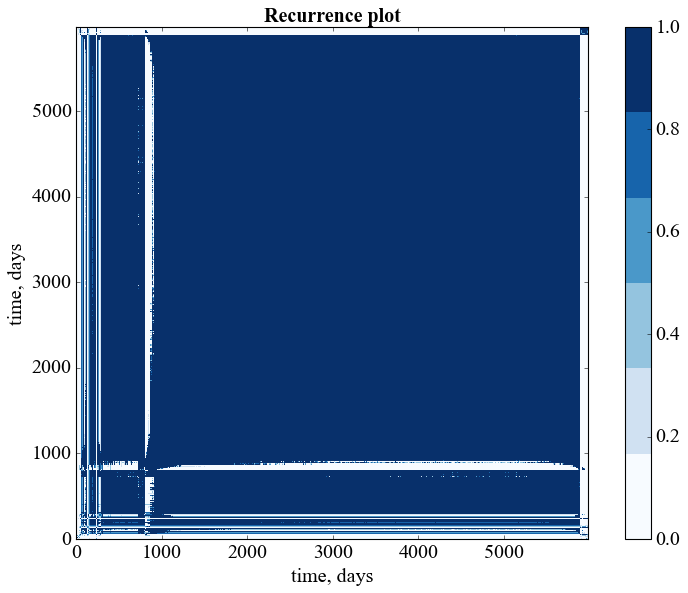

In [18]:
title = "Recurrence plot" # підпис титульний
title_axes = "time, days" #підпис по осям

plt.rcParams['font.size'] = '18' 
fig, ax = plt.subplots(figsize=(12, 8))

rp = ax.imshow(rp_result.recurrence_matrix, cmap=plt.cm.get_cmap('Blues', 6))
plt.colorbar(rp, ax=ax)
plt.gca().invert_yaxis()
ax.set_title(title, fontweight="bold", size=18)
ax.set_xlabel(title_axes, fontsize=18)
ax.set_ylabel(title_axes, fontsize=18)
plt.savefig(path+f'rp_{symbol}.jpg')
plt.show()

### Віконна процедура

In [19]:
ret_type = 4 #вид ряду: 1 - вихідний, 2 - детрендований (різниця між теп. значенням та попереднім)
                        # 3 - прибутковості звичайні, 4 - стандартизовані прибутковості, 5 - абсолютні значення (волатильності),
                        # 6 - стандартизований вихідний ряд 

length = len(time_ser)

d_e = 1 # розмірність вкладень
tau = 1 # часові затримка
theiler_wind = 1 # вікно Тейлера
sim_measure = EuclideanMetric # TaxicabMetric (L1), EuclideanMetric (L2), MaximumMetric (L_inf)
eps = 0.3 # радіус

RR = []
DET = []
DIV = []
AVG_DIAG_LINE = []
ENT_DIAG = []
LAM = []
TT = []
ENT_VERT = []
ENT_WHITE_VERT = []
AVG_VERT_LINE = []
VERT_DIV = []
RATIO_DET_REC = []
RATIO_LAM_DET = []

In [20]:
for i in range(0,length-window,tstep):
    fragm = time_ser.iloc[i:i+window].copy() #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm[1:] - fragm[:-1]
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5:
        fragm = (fragm - fragm.mean())/fragm.std()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values
    
    time_series = TimeSeries(fragm,
                         embedding_dimension=d_e,
                         time_delay=tau)

    settings = Settings(time_series,
                        analysis_type=Classic,
                        neighbourhood=FixedRadius(eps),
                        similarity_measure=sim_measure,
                        theiler_corrector=theiler_wind)
    
    computation = RQAComputation.create(settings, verbose=False)
    resultRQA = computation.run()
    print(resultRQA)
    
    RR.append(resultRQA.recurrence_rate)
    DET.append(resultRQA.determinism)
    DIV.append(resultRQA.divergence)
    AVG_DIAG_LINE.append(resultRQA.average_diagonal_line)
    ENT_DIAG.append(resultRQA.entropy_diagonal_lines)
    LAM.append(resultRQA.laminarity)
    TT.append(resultRQA.trapping_time)
    ENT_VERT.append(resultRQA.entropy_vertical_lines)
    ENT_WHITE_VERT.append(resultRQA.entropy_white_vertical_lines)
    AVG_VERT_LINE.append(resultRQA.average_white_vertical_line)
    VERT_DIV.append(1./resultRQA.longest_vertical_line)
    RATIO_DET_REC.append(resultRQA.ratio_determinism_recurrence_rate)
    RATIO_LAM_DET.append(resultRQA.ratio_laminarity_determinism)

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.910995
Determinism (DET): 0.999004
Average diagonal line length (L): 24.699507
Longest diagonal line length (L_max): 141
Divergence (DIV): 0.007092
Entropy diagonal lines (L_entr): 2.354808
Laminarity (LAM): 0.998813
Trapping time (TT): 48.212411
Longest vertical line length (V_max): 145
Entropy vertical lines (V_entr): 0.875280
Average white vertical line length (W): 6.158784
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 1.045391

Ratio determinism / recurrence rate (DET/RR): 1.096607
Ratio laminarity / determinism (LAM/DET): 0.999809

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.729562
Determinism (DET): 0

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.314535
Determinism (DET): 0.567749
Average diagonal line length (L): 2.635870
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 1.088093
Laminarity (LAM): 0.640412
Trapping time (TT): 3.214953
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.449422
Average white vertical line length (W): 5.538182
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.090004

Ratio determinism / recurrence rate (DET/RR): 1.805042
Ratio laminarity / determinism (LAM/DET): 1.127984

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.303905
Determinism (DET): 0.556

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.324805
Determinism (DET): 0.557349
Average diagonal line length (L): 2.606623
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 1.062167
Laminarity (LAM): 0.626820
Trapping time (TT): 3.174157
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.413328
Average white vertical line length (W): 5.231492
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.115411

Ratio determinism / recurrence rate (DET/RR): 1.715949
Ratio laminarity / determinism (LAM/DET): 1.124645

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.329940
Determinism (DET): 0.558

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.314716
Determinism (DET): 0.529395
Average diagonal line length (L): 2.560113
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 1.009578
Laminarity (LAM): 0.613711
Trapping time (TT): 3.275783
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.501181
Average white vertical line length (W): 5.527710
Longest white vertical line length (W_max): 138
Longest white vertical line length inverse (W_div): 0.007246
Entropy white vertical lines (W_entr): 2.207824

Ratio determinism / recurrence rate (DET/RR): 1.682137
Ratio laminarity / determinism (LAM/DET): 1.159270

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.319130
Determinism (DET): 0.5242

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.317148
Determinism (DET): 0.523796
Average diagonal line length (L): 2.619739
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 1.075132
Laminarity (LAM): 0.626331
Trapping time (TT): 3.368984
Longest vertical line length (V_max): 13
Entropy vertical lines (V_entr): 1.507753
Average white vertical line length (W): 5.688077
Longest white vertical line length (W_max): 135
Longest white vertical line length inverse (W_div): 0.007407
Entropy white vertical lines (W_entr): 2.277328

Ratio determinism / recurrence rate (DET/RR): 1.651582
Ratio laminarity / determinism (LAM/DET): 1.195755

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.320391
Determinism (DET): 0.5301

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.346246
Determinism (DET): 0.572566
Average diagonal line length (L): 2.759591
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 1.199817
Laminarity (LAM): 0.685833
Trapping time (TT): 3.666203
Longest vertical line length (V_max): 13
Entropy vertical lines (V_entr): 1.609028
Average white vertical line length (W): 5.665936
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.233464

Ratio determinism / recurrence rate (DET/RR): 1.653640
Ratio laminarity / determinism (LAM/DET): 1.197825

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.349399
Determinism (DET): 0.585

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.348047
Determinism (DET): 0.558459
Average diagonal line length (L): 2.798942
Longest diagonal line length (L_max): 11
Divergence (DIV): 0.090909
Entropy diagonal lines (L_entr): 1.229305
Laminarity (LAM): 0.666235
Trapping time (TT): 3.643312
Longest vertical line length (V_max): 16
Entropy vertical lines (V_entr): 1.617231
Average white vertical line length (W): 5.683527
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.235139

Ratio determinism / recurrence rate (DET/RR): 1.604548
Ratio laminarity / determinism (LAM/DET): 1.192989

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.348678
Determinism (DET): 0.571

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.354263
Determinism (DET): 0.598237
Average diagonal line length (L): 2.867081
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 1.283412
Laminarity (LAM): 0.687603
Trapping time (TT): 3.681416
Longest vertical line length (V_max): 16
Entropy vertical lines (V_entr): 1.674419
Average white vertical line length (W): 5.599373
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.221594

Ratio determinism / recurrence rate (DET/RR): 1.688680
Ratio laminarity / determinism (LAM/DET): 1.149382

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.285528
Determinism (DET): 0.484

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.289131
Determinism (DET): 0.490271
Average diagonal line length (L): 2.570234
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 1.023616
Laminarity (LAM): 0.611310
Trapping time (TT): 2.993135
Longest vertical line length (V_max): 13
Entropy vertical lines (V_entr): 1.357676
Average white vertical line length (W): 5.827251
Longest white vertical line length (W_max): 139
Longest white vertical line length inverse (W_div): 0.007194
Entropy white vertical lines (W_entr): 2.248204

Ratio determinism / recurrence rate (DET/RR): 1.695671
Ratio laminarity / determinism (LAM/DET): 1.246882

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.288861
Determinism (DET): 0.487

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.283906
Determinism (DET): 0.486188
Average diagonal line length (L): 2.501672
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.953165
Laminarity (LAM): 0.571791
Trapping time (TT): 2.761686
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 1.196244
Average white vertical line length (W): 5.601480
Longest white vertical line length (W_max): 142
Longest white vertical line length inverse (W_div): 0.007042
Entropy white vertical lines (W_entr): 2.201106

Ratio determinism / recurrence rate (DET/RR): 1.712495
Ratio laminarity / determinism (LAM/DET): 1.176071

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.288320
Determinism (DET): 0.48848

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.284627
Determinism (DET): 0.492382
Average diagonal line length (L): 2.446055
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.885460
Laminarity (LAM): 0.574616
Trapping time (TT): 2.650365
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.097775
Average white vertical line length (W): 5.570155
Longest white vertical line length (W_max): 119
Longest white vertical line length inverse (W_div): 0.008403
Entropy white vertical lines (W_entr): 2.168014

Ratio determinism / recurrence rate (DET/RR): 1.729923
Ratio laminarity / determinism (LAM/DET): 1.167012

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.285167
Determinism (DET): 0.50598

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.289401
Determinism (DET): 0.506692
Average diagonal line length (L): 2.472784
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.915340
Laminarity (LAM): 0.589728
Trapping time (TT): 2.647799
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.091621
Average white vertical line length (W): 5.350635
Longest white vertical line length (W_max): 130
Longest white vertical line length inverse (W_div): 0.007692
Entropy white vertical lines (W_entr): 2.138634

Ratio determinism / recurrence rate (DET/RR): 1.750828
Ratio laminarity / determinism (LAM/DET): 1.163878

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.292915
Determinism (DET): 0.51369

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.307509
Determinism (DET): 0.534891
Average diagonal line length (L): 2.511955
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.957998
Laminarity (LAM): 0.605976
Trapping time (TT): 2.657033
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.100683
Average white vertical line length (W): 5.005774
Longest white vertical line length (W_max): 141
Longest white vertical line length inverse (W_div): 0.007092
Entropy white vertical lines (W_entr): 2.026758

Ratio determinism / recurrence rate (DET/RR): 1.739433
Ratio laminarity / determinism (LAM/DET): 1.132897

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.308770
Determinism (DET): 0.53385

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.287960
Determinism (DET): 0.515375
Average diagonal line length (L): 2.456489
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.902693
Laminarity (LAM): 0.579853
Trapping time (TT): 2.599579
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.023147
Average white vertical line length (W): 5.113861
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.094945

Ratio determinism / recurrence rate (DET/RR): 1.789744
Ratio laminarity / determinism (LAM/DET): 1.125109

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.292194
Determinism (DET): 0.51972

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.267060
Determinism (DET): 0.486505
Average diagonal line length (L): 2.424138
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.866072
Laminarity (LAM): 0.548828
Trapping time (TT): 2.522481
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.954636
Average white vertical line length (W): 5.528476
Longest white vertical line length (W_max): 118
Longest white vertical line length inverse (W_div): 0.008475
Entropy white vertical lines (W_entr): 2.241631

Ratio determinism / recurrence rate (DET/RR): 1.821707
Ratio laminarity / determinism (LAM/DET): 1.128103

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.271204
Determinism (DET): 0.49591

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.282285
Determinism (DET): 0.509971
Average diagonal line length (L): 2.418605
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.858418
Laminarity (LAM): 0.573480
Trapping time (TT): 2.541726
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.974414
Average white vertical line length (W): 5.472423
Longest white vertical line length (W_max): 130
Longest white vertical line length inverse (W_div): 0.007692
Entropy white vertical lines (W_entr): 2.244096

Ratio determinism / recurrence rate (DET/RR): 1.806583
Ratio laminarity / determinism (LAM/DET): 1.124536

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.282735
Determinism (DET): 0.50881

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.292554
Determinism (DET): 0.522849
Average diagonal line length (L): 2.454142
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.897805
Laminarity (LAM): 0.612471
Trapping time (TT): 2.632694
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.069291
Average white vertical line length (W): 5.652906
Longest white vertical line length (W_max): 142
Longest white vertical line length inverse (W_div): 0.007042
Entropy white vertical lines (W_entr): 2.278878

Ratio determinism / recurrence rate (DET/RR): 1.787186
Ratio laminarity / determinism (LAM/DET): 1.171411

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.295437
Determinism (DET): 0.52854

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.293005
Determinism (DET): 0.515104
Average diagonal line length (L): 2.446936
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.889898
Laminarity (LAM): 0.629055
Trapping time (TT): 2.715328
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.135583
Average white vertical line length (W): 5.790984
Longest white vertical line length (W_max): 131
Longest white vertical line length inverse (W_div): 0.007634
Entropy white vertical lines (W_entr): 2.290781

Ratio determinism / recurrence rate (DET/RR): 1.758005
Ratio laminarity / determinism (LAM/DET): 1.221219

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.293185
Determinism (DET): 0.5141

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.292014
Determinism (DET): 0.513104
Average diagonal line length (L): 2.443609
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.887575
Laminarity (LAM): 0.628876
Trapping time (TT): 2.738079
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.162341
Average white vertical line length (W): 5.760227
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.290971

Ratio determinism / recurrence rate (DET/RR): 1.757122
Ratio laminarity / determinism (LAM/DET): 1.225630

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.295257
Determinism (DET): 0.5207

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.298140
Determinism (DET): 0.511283
Average diagonal line length (L): 2.443131
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.885529
Laminarity (LAM): 0.634386
Trapping time (TT): 2.771617
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.184132
Average white vertical line length (W): 5.893023
Longest white vertical line length (W_max): 142
Longest white vertical line length inverse (W_div): 0.007042
Entropy white vertical lines (W_entr): 2.301254

Ratio determinism / recurrence rate (DET/RR): 1.714910
Ratio laminarity / determinism (LAM/DET): 1.240773

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.298680
Determinism (DET): 0.5103

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.244719
Determinism (DET): 0.431870
Average diagonal line length (L): 2.347737
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.757158
Laminarity (LAM): 0.556230
Trapping time (TT): 2.543771
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.988721
Average white vertical line length (W): 6.208848
Longest white vertical line length (W_max): 126
Longest white vertical line length inverse (W_div): 0.007937
Entropy white vertical lines (W_entr): 2.354144

Ratio determinism / recurrence rate (DET/RR): 1.764760
Ratio laminarity / determinism (LAM/DET): 1.287959

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.246971
Determinism (DET): 0.43119

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.253637
Determinism (DET): 0.441080
Average diagonal line length (L): 2.356725
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.773181
Laminarity (LAM): 0.551767
Trapping time (TT): 2.587011
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.020408
Average white vertical line length (W): 5.867960
Longest white vertical line length (W_max): 126
Longest white vertical line length inverse (W_div): 0.007937
Entropy white vertical lines (W_entr): 2.302234

Ratio determinism / recurrence rate (DET/RR): 1.739019
Ratio laminarity / determinism (LAM/DET): 1.250946

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.253187
Determinism (DET): 0.44919

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.255439
Determinism (DET): 0.451286
Average diagonal line length (L): 2.386973
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.811819
Laminarity (LAM): 0.559513
Trapping time (TT): 2.754340
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.176892
Average white vertical line length (W): 5.813063
Longest white vertical line length (W_max): 137
Longest white vertical line length inverse (W_div): 0.007299
Entropy white vertical lines (W_entr): 2.301317

Ratio determinism / recurrence rate (DET/RR): 1.766707
Ratio laminarity / determinism (LAM/DET): 1.239820

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.254268
Determinism (DET): 0.45778

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.247241
Determinism (DET): 0.417978
Average diagonal line length (L): 2.325000
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.735131
Laminarity (LAM): 0.530880
Trapping time (TT): 2.632340
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.049304
Average white vertical line length (W): 5.902883
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.318222

Ratio determinism / recurrence rate (DET/RR): 1.690566
Ratio laminarity / determinism (LAM/DET): 1.270116

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.236070
Determinism (DET): 0.39630

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.241386
Determinism (DET): 0.425336
Average diagonal line length (L): 2.357447
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.768565
Laminarity (LAM): 0.543758
Trapping time (TT): 2.718284
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.110584
Average white vertical line length (W): 6.062787
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.342329

Ratio determinism / recurrence rate (DET/RR): 1.762060
Ratio laminarity / determinism (LAM/DET): 1.278421

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.222828
Determinism (DET): 0.40141

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.229945
Determinism (DET): 0.405973
Average diagonal line length (L): 2.378251
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.795354
Laminarity (LAM): 0.524388
Trapping time (TT): 2.754115
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.157116
Average white vertical line length (W): 6.404610
Longest white vertical line length (W_max): 106
Longest white vertical line length inverse (W_div): 0.009434
Entropy white vertical lines (W_entr): 2.420336

Ratio determinism / recurrence rate (DET/RR): 1.765523
Ratio laminarity / determinism (LAM/DET): 1.291683

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.231386
Determinism (DET): 0.40497

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.243007
Determinism (DET): 0.426611
Average diagonal line length (L): 2.370763
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.786769
Laminarity (LAM): 0.571270
Trapping time (TT): 2.761649
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.144815
Average white vertical line length (W): 6.218310
Longest white vertical line length (W_max): 106
Longest white vertical line length inverse (W_div): 0.009434
Entropy white vertical lines (W_entr): 2.394078

Ratio determinism / recurrence rate (DET/RR): 1.755549
Ratio laminarity / determinism (LAM/DET): 1.339089

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.243097
Determinism (DET): 0.44093

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.252556
Determinism (DET): 0.444119
Average diagonal line length (L): 2.395257
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.820967
Laminarity (LAM): 0.590512
Trapping time (TT): 2.782353
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.158719
Average white vertical line length (W): 6.224800
Longest white vertical line length (W_max): 108
Longest white vertical line length inverse (W_div): 0.009259
Entropy white vertical lines (W_entr): 2.396387

Ratio determinism / recurrence rate (DET/RR): 1.758495
Ratio laminarity / determinism (LAM/DET): 1.329626

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.251745
Determinism (DET): 0.45220

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.266159
Determinism (DET): 0.456597
Average diagonal line length (L): 2.408425
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.836177
Laminarity (LAM): 0.601794
Trapping time (TT): 2.695982
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.089720
Average white vertical line length (W): 6.070105
Longest white vertical line length (W_max): 120
Longest white vertical line length inverse (W_div): 0.008333
Entropy white vertical lines (W_entr): 2.352695

Ratio determinism / recurrence rate (DET/RR): 1.715504
Ratio laminarity / determinism (LAM/DET): 1.317997

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.267510
Determinism (DET): 0.46839

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.269132
Determinism (DET): 0.437350
Average diagonal line length (L): 2.390244
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.814807
Laminarity (LAM): 0.571213
Trapping time (TT): 2.601372
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.017640
Average white vertical line length (W): 5.644419
Longest white vertical line length (W_max): 132
Longest white vertical line length inverse (W_div): 0.007576
Entropy white vertical lines (W_entr): 2.222799

Ratio determinism / recurrence rate (DET/RR): 1.625038
Ratio laminarity / determinism (LAM/DET): 1.306079

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.266880
Determinism (DET): 0.43732

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.271204
Determinism (DET): 0.440054
Average diagonal line length (L): 2.370642
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.789733
Laminarity (LAM): 0.556552
Trapping time (TT): 2.504484
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.934499
Average white vertical line length (W): 5.467183
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.174360

Ratio determinism / recurrence rate (DET/RR): 1.622596
Ratio laminarity / determinism (LAM/DET): 1.264734

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.273546
Determinism (DET): 0.44294

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.278681
Determinism (DET): 0.453461
Average diagonal line length (L): 2.414462
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.850319
Laminarity (LAM): 0.559722
Trapping time (TT): 2.533285
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.966068
Average white vertical line length (W): 5.437336
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.140706

Ratio determinism / recurrence rate (DET/RR): 1.627169
Ratio laminarity / determinism (LAM/DET): 1.234332

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.278591
Determinism (DET): 0.45725

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.282014
Determinism (DET): 0.480694
Average diagonal line length (L): 2.468908
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.909774
Laminarity (LAM): 0.589043
Trapping time (TT): 2.756353
Longest vertical line length (V_max): 12
Entropy vertical lines (V_entr): 1.103513
Average white vertical line length (W): 5.669267
Longest white vertical line length (W_max): 126
Longest white vertical line length inverse (W_div): 0.007937
Entropy white vertical lines (W_entr): 2.206154

Ratio determinism / recurrence rate (DET/RR): 1.704501
Ratio laminarity / determinism (LAM/DET): 1.225403

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.283906
Determinism (DET): 0.4845

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.295617
Determinism (DET): 0.482070
Average diagonal line length (L): 2.489533
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.936134
Laminarity (LAM): 0.598050
Trapping time (TT): 2.760197
Longest vertical line length (V_max): 12
Entropy vertical lines (V_entr): 1.108871
Average white vertical line length (W): 5.617423
Longest white vertical line length (W_max): 130
Longest white vertical line length inverse (W_div): 0.007692
Entropy white vertical lines (W_entr): 2.212366

Ratio determinism / recurrence rate (DET/RR): 1.630725
Ratio laminarity / determinism (LAM/DET): 1.240586

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.300212
Determinism (DET): 0.4828

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.294716
Determinism (DET): 0.481702
Average diagonal line length (L): 2.504065
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.950888
Laminarity (LAM): 0.583372
Trapping time (TT): 2.790205
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.175157
Average white vertical line length (W): 5.623037
Longest white vertical line length (W_max): 108
Longest white vertical line length inverse (W_div): 0.009259
Entropy white vertical lines (W_entr): 2.228205

Ratio determinism / recurrence rate (DET/RR): 1.634458
Ratio laminarity / determinism (LAM/DET): 1.211064

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.298590
Determinism (DET): 0.4814

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.299581
Determinism (DET): 0.500154
Average diagonal line length (L): 2.505393
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.951213
Laminarity (LAM): 0.591039
Trapping time (TT): 2.821967
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.201454
Average white vertical line length (W): 5.492490
Longest white vertical line length (W_max): 120
Longest white vertical line length inverse (W_div): 0.008333
Entropy white vertical lines (W_entr): 2.172908

Ratio determinism / recurrence rate (DET/RR): 1.669511
Ratio laminarity / determinism (LAM/DET): 1.181714

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.299311
Determinism (DET): 0.5024

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.297239
Determinism (DET): 0.471628
Average diagonal line length (L): 2.453226
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.889171
Laminarity (LAM): 0.558873
Trapping time (TT): 2.826054
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.216009
Average white vertical line length (W): 5.365311
Longest white vertical line length (W_max): 132
Longest white vertical line length inverse (W_div): 0.007576
Entropy white vertical lines (W_entr): 2.173056

Ratio determinism / recurrence rate (DET/RR): 1.586697
Ratio laminarity / determinism (LAM/DET): 1.184986

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.294176
Determinism (DET): 0.4688

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.289491
Determinism (DET): 0.463205
Average diagonal line length (L): 2.435511
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.851619
Laminarity (LAM): 0.552980
Trapping time (TT): 2.870759
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.232314
Average white vertical line length (W): 5.520761
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.225463

Ratio determinism / recurrence rate (DET/RR): 1.600064
Ratio laminarity / determinism (LAM/DET): 1.193812

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.288861
Determinism (DET): 0.4597

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.262916
Determinism (DET): 0.428270
Average diagonal line length (L): 2.388235
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.807238
Laminarity (LAM): 0.476957
Trapping time (TT): 2.708171
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.132329
Average white vertical line length (W): 5.571268
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.219378

Ratio determinism / recurrence rate (DET/RR): 1.628923
Ratio laminarity / determinism (LAM/DET): 1.113684

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.266069
Determinism (DET): 0.4366

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.247151
Determinism (DET): 0.404646
Average diagonal line length (L): 2.322581
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.723529
Laminarity (LAM): 0.479132
Trapping time (TT): 2.547481
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.977074
Average white vertical line length (W): 5.708010
Longest white vertical line length (W_max): 136
Longest white vertical line length inverse (W_div): 0.007353
Entropy white vertical lines (W_entr): 2.270854

Ratio determinism / recurrence rate (DET/RR): 1.637242
Ratio laminarity / determinism (LAM/DET): 1.184078

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.250214
Determinism (DET): 0.40695

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.250304
Determinism (DET): 0.411982
Average diagonal line length (L): 2.380342
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.798636
Laminarity (LAM): 0.497571
Trapping time (TT): 2.620853
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 1.054267
Average white vertical line length (W): 5.694322
Longest white vertical line length (W_max): 131
Longest white vertical line length inverse (W_div): 0.007634
Entropy white vertical lines (W_entr): 2.261750

Ratio determinism / recurrence rate (DET/RR): 1.645927
Ratio laminarity / determinism (LAM/DET): 1.207748

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.249493
Determinism (DET): 0.41187

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.252826
Determinism (DET): 0.432284
Average diagonal line length (L): 2.415133
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.848056
Laminarity (LAM): 0.529129
Trapping time (TT): 2.704918
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 1.134409
Average white vertical line length (W): 5.729900
Longest white vertical line length (W_max): 135
Longest white vertical line length inverse (W_div): 0.007407
Entropy white vertical lines (W_entr): 2.254419

Ratio determinism / recurrence rate (DET/RR): 1.709805
Ratio laminarity / determinism (LAM/DET): 1.224030

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.255439
Determinism (DET): 0.43716

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.247872
Determinism (DET): 0.406799
Average diagonal line length (L): 2.436242
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.876968
Laminarity (LAM): 0.509177
Trapping time (TT): 2.621141
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 1.046428
Average white vertical line length (W): 5.719414
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.228920

Ratio determinism / recurrence rate (DET/RR): 1.641166
Ratio laminarity / determinism (LAM/DET): 1.251668

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.244809
Determinism (DET): 0.41695

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.245710
Determinism (DET): 0.410856
Average diagonal line length (L): 2.406181
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.841959
Laminarity (LAM): 0.498442
Trapping time (TT): 2.579696
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 1.010104
Average white vertical line length (W): 5.655459
Longest white vertical line length (W_max): 126
Longest white vertical line length inverse (W_div): 0.007937
Entropy white vertical lines (W_entr): 2.218186

Ratio determinism / recurrence rate (DET/RR): 1.672118
Ratio laminarity / determinism (LAM/DET): 1.213180

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.242557
Determinism (DET): 0.40297

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.233908
Determinism (DET): 0.388580
Average diagonal line length (L): 2.333333
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.747634
Laminarity (LAM): 0.460235
Trapping time (TT): 2.458848
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.894135
Average white vertical line length (W): 5.695218
Longest white vertical line length (W_max): 137
Longest white vertical line length inverse (W_div): 0.007299
Entropy white vertical lines (W_entr): 2.256820

Ratio determinism / recurrence rate (DET/RR): 1.661251
Ratio laminarity / determinism (LAM/DET): 1.184401

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.233458
Determinism (DET): 0.38895

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.232917
Determinism (DET): 0.398248
Average diagonal line length (L): 2.325581
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.734642
Laminarity (LAM): 0.473990
Trapping time (TT): 2.537267
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.979716
Average white vertical line length (W): 5.762761
Longest white vertical line length (W_max): 142
Longest white vertical line length inverse (W_div): 0.007042
Entropy white vertical lines (W_entr): 2.256990

Ratio determinism / recurrence rate (DET/RR): 1.709824
Ratio laminarity / determinism (LAM/DET): 1.190188

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.235890
Determinism (DET): 0.39622

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.232647
Determinism (DET): 0.388756
Average diagonal line length (L): 2.288732
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.684124
Laminarity (LAM): 0.465828
Trapping time (TT): 2.551432
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.992217
Average white vertical line length (W): 5.814721
Longest white vertical line length (W_max): 131
Longest white vertical line length inverse (W_div): 0.007634
Entropy white vertical lines (W_entr): 2.245694

Ratio determinism / recurrence rate (DET/RR): 1.671011
Ratio laminarity / determinism (LAM/DET): 1.198252

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.233368
Determinism (DET): 0.39427

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.239494
Determinism (DET): 0.399381
Average diagonal line length (L): 2.319101
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.727801
Laminarity (LAM): 0.460598
Trapping time (TT): 2.639009
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.069128
Average white vertical line length (W): 5.718682
Longest white vertical line length (W_max): 120
Longest white vertical line length inverse (W_div): 0.008333
Entropy white vertical lines (W_entr): 2.204823

Ratio determinism / recurrence rate (DET/RR): 1.667605
Ratio laminarity / determinism (LAM/DET): 1.153280

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.238593
Determinism (DET): 0.39821

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.244539
Determinism (DET): 0.430303
Average diagonal line length (L): 2.386555
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.811541
Laminarity (LAM): 0.505250
Trapping time (TT): 2.887368
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.266490
Average white vertical line length (W): 5.905767
Longest white vertical line length (W_max): 127
Longest white vertical line length inverse (W_div): 0.007874
Entropy white vertical lines (W_entr): 2.275417

Ratio determinism / recurrence rate (DET/RR): 1.759653
Ratio laminarity / determinism (LAM/DET): 1.174172

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.244719
Determinism (DET): 0.42959

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.688663
Determinism (DET): 0.936856
Average diagonal line length (L): 4.746988
Longest diagonal line length (L_max): 30
Divergence (DIV): 0.033333
Entropy diagonal lines (L_entr): 2.148261
Laminarity (LAM): 0.952057
Trapping time (TT): 6.680128
Longest vertical line length (V_max): 36
Entropy vertical lines (V_entr): 2.276592
Average white vertical line length (W): 4.770651
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 1.623644

Ratio determinism / recurrence rate (DET/RR): 1.360399
Ratio laminarity / determinism (LAM/DET): 1.016226

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.690554
Determinism (DET): 0.942

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.631458
Determinism (DET): 0.952992
Average diagonal line length (L): 5.347087
Longest diagonal line length (L_max): 30
Divergence (DIV): 0.033333
Entropy diagonal lines (L_entr): 2.316539
Laminarity (LAM): 0.960126
Trapping time (TT): 7.757925
Longest vertical line length (V_max): 36
Entropy vertical lines (V_entr): 2.428276
Average white vertical line length (W): 10.045383
Longest white vertical line length (W_max): 140
Longest white vertical line length inverse (W_div): 0.007143
Entropy white vertical lines (W_entr): 1.852620

Ratio determinism / recurrence rate (DET/RR): 1.509193
Ratio laminarity / determinism (LAM/DET): 1.007485

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.632089
Determinism (DET): 0.95

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.561101
Determinism (DET): 0.952876
Average diagonal line length (L): 5.698737
Longest diagonal line length (L_max): 30
Divergence (DIV): 0.033333
Entropy diagonal lines (L_entr): 2.333970
Laminarity (LAM): 0.964839
Trapping time (TT): 8.578872
Longest vertical line length (V_max): 45
Entropy vertical lines (V_entr): 2.407711
Average white vertical line length (W): 16.049618
Longest white vertical line length (W_max): 129
Longest white vertical line length inverse (W_div): 0.007752
Entropy white vertical lines (W_entr): 2.018183

Ratio determinism / recurrence rate (DET/RR): 1.698226
Ratio laminarity / determinism (LAM/DET): 1.012554

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.553624
Determinism (DET): 0.94

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.514166
Determinism (DET): 0.970353
Average diagonal line length (L): 6.546108
Longest diagonal line length (L_max): 33
Divergence (DIV): 0.030303
Entropy diagonal lines (L_entr): 2.548007
Laminarity (LAM): 0.974332
Trapping time (TT): 9.781882
Longest vertical line length (V_max): 45
Entropy vertical lines (V_entr): 2.524028
Average white vertical line length (W): 27.309859
Longest white vertical line length (W_max): 118
Longest white vertical line length inverse (W_div): 0.008475
Entropy white vertical lines (W_entr): 2.187432

Ratio determinism / recurrence rate (DET/RR): 1.887237
Ratio laminarity / determinism (LAM/DET): 1.004100

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.507590
Determinism (DET): 0.97

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.450565
Determinism (DET): 0.967932
Average diagonal line length (L): 6.177461
Longest diagonal line length (L_max): 33
Divergence (DIV): 0.030303
Entropy diagonal lines (L_entr): 2.465338
Laminarity (LAM): 0.974308
Trapping time (TT): 9.194340
Longest vertical line length (V_max): 45
Entropy vertical lines (V_entr): 2.449147
Average white vertical line length (W): 30.928375
Longest white vertical line length (W_max): 106
Longest white vertical line length inverse (W_div): 0.009434
Entropy white vertical lines (W_entr): 2.109578

Ratio determinism / recurrence rate (DET/RR): 2.148261
Ratio laminarity / determinism (LAM/DET): 1.006587

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.443989
Determinism (DET): 0.96

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.405432
Determinism (DET): 0.963398
Average diagonal line length (L): 5.930459
Longest diagonal line length (L_max): 33
Divergence (DIV): 0.030303
Entropy diagonal lines (L_entr): 2.358400
Laminarity (LAM): 0.965893
Trapping time (TT): 8.557087
Longest vertical line length (V_max): 45
Entropy vertical lines (V_entr): 2.339161
Average white vertical line length (W): 30.746231
Longest white vertical line length (W_max): 107
Longest white vertical line length inverse (W_div): 0.009346
Entropy white vertical lines (W_entr): 1.977367

Ratio determinism / recurrence rate (DET/RR): 2.376225
Ratio laminarity / determinism (LAM/DET): 1.002589

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.401829
Determinism (DET): 0.96

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.372731
Determinism (DET): 0.936992
Average diagonal line length (L): 5.776935
Longest diagonal line length (L_max): 33
Divergence (DIV): 0.030303
Entropy diagonal lines (L_entr): 2.334331
Laminarity (LAM): 0.937885
Trapping time (TT): 8.426710
Longest vertical line length (V_max): 46
Entropy vertical lines (V_entr): 2.327963
Average white vertical line length (W): 26.757764
Longest white vertical line length (W_max): 118
Longest white vertical line length inverse (W_div): 0.008475
Entropy white vertical lines (W_entr): 2.043867

Ratio determinism / recurrence rate (DET/RR): 2.513857
Ratio laminarity / determinism (LAM/DET): 1.000953

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.369398
Determinism (DET): 0.93

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.352822
Determinism (DET): 0.909162
Average diagonal line length (L): 5.390432
Longest diagonal line length (L_max): 33
Divergence (DIV): 0.030303
Entropy diagonal lines (L_entr): 2.236057
Laminarity (LAM): 0.914592
Trapping time (TT): 7.728155
Longest vertical line length (V_max): 46
Entropy vertical lines (V_entr): 2.345325
Average white vertical line length (W): 20.700775
Longest white vertical line length (W_max): 123
Longest white vertical line length inverse (W_div): 0.008130
Entropy white vertical lines (W_entr): 2.102620

Ratio determinism / recurrence rate (DET/RR): 2.576829
Ratio laminarity / determinism (LAM/DET): 1.005973

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.351651
Determinism (DET): 0.90

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.322463
Determinism (DET): 0.916690
Average diagonal line length (L): 5.267213
Longest diagonal line length (L_max): 44
Divergence (DIV): 0.022727
Entropy diagonal lines (L_entr): 2.189494
Laminarity (LAM): 0.920939
Trapping time (TT): 7.666279
Longest vertical line length (V_max): 46
Entropy vertical lines (V_entr): 2.265900
Average white vertical line length (W): 22.959416
Longest white vertical line length (W_max): 114
Longest white vertical line length inverse (W_div): 0.008772
Entropy white vertical lines (W_entr): 2.490364

Ratio determinism / recurrence rate (DET/RR): 2.842778
Ratio laminarity / determinism (LAM/DET): 1.004634

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.319941
Determinism (DET): 0.91

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.300932
Determinism (DET): 0.906920
Average diagonal line length (L): 5.317774
Longest diagonal line length (L_max): 38
Divergence (DIV): 0.026316
Entropy diagonal lines (L_entr): 2.173539
Laminarity (LAM): 0.914085
Trapping time (TT): 7.652882
Longest vertical line length (V_max): 46
Entropy vertical lines (V_entr): 2.287813
Average white vertical line length (W): 24.238017
Longest white vertical line length (W_max): 130
Longest white vertical line length inverse (W_div): 0.007692
Entropy white vertical lines (W_entr): 2.547773

Ratio determinism / recurrence rate (DET/RR): 3.013699
Ratio laminarity / determinism (LAM/DET): 1.007900

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.298950
Determinism (DET): 0.89

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.283185
Determinism (DET): 0.895080
Average diagonal line length (L): 5.077634
Longest diagonal line length (L_max): 32
Divergence (DIV): 0.031250
Entropy diagonal lines (L_entr): 2.143729
Laminarity (LAM): 0.901543
Trapping time (TT): 7.220382
Longest vertical line length (V_max): 46
Entropy vertical lines (V_entr): 2.293311
Average white vertical line length (W): 23.819334
Longest white vertical line length (W_max): 130
Longest white vertical line length inverse (W_div): 0.007692
Entropy white vertical lines (W_entr): 2.538744

Ratio determinism / recurrence rate (DET/RR): 3.160755
Ratio laminarity / determinism (LAM/DET): 1.007221

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.282014
Determinism (DET): 0.88

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.258772
Determinism (DET): 0.860257
Average diagonal line length (L): 4.252650
Longest diagonal line length (L_max): 36
Divergence (DIV): 0.027778
Entropy diagonal lines (L_entr): 1.911218
Laminarity (LAM): 0.876588
Trapping time (TT): 5.980998
Longest vertical line length (V_max): 46
Entropy vertical lines (V_entr): 2.139452
Average white vertical line length (W): 21.206284
Longest white vertical line length (W_max): 133
Longest white vertical line length inverse (W_div): 0.007519
Entropy white vertical lines (W_entr): 2.692005

Ratio determinism / recurrence rate (DET/RR): 3.324382
Ratio laminarity / determinism (LAM/DET): 1.018984

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.256790
Determinism (DET): 0.85

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.233728
Determinism (DET): 0.796032
Average diagonal line length (L): 3.569395
Longest diagonal line length (L_max): 32
Divergence (DIV): 0.031250
Entropy diagonal lines (L_entr): 1.636438
Laminarity (LAM): 0.831374
Trapping time (TT): 4.847191
Longest vertical line length (V_max): 37
Entropy vertical lines (V_entr): 1.937678
Average white vertical line length (W): 17.788013
Longest white vertical line length (W_max): 146
Longest white vertical line length inverse (W_div): 0.006849
Entropy white vertical lines (W_entr): 2.574850

Ratio determinism / recurrence rate (DET/RR): 3.405801
Ratio laminarity / determinism (LAM/DET): 1.044398

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.231656
Determinism (DET): 0.79

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191388
Determinism (DET): 0.695122
Average diagonal line length (L): 3.246014
Longest diagonal line length (L_max): 15
Divergence (DIV): 0.066667
Entropy diagonal lines (L_entr): 1.484488
Laminarity (LAM): 0.774771
Trapping time (TT): 4.125313
Longest vertical line length (V_max): 17
Entropy vertical lines (V_entr): 1.829760
Average white vertical line length (W): 18.557252
Longest white vertical line length (W_max): 116
Longest white vertical line length inverse (W_div): 0.008621
Entropy white vertical lines (W_entr): 2.462538

Ratio determinism / recurrence rate (DET/RR): 3.632008
Ratio laminarity / determinism (LAM/DET): 1.114582

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190217
Determinism (DET): 0.70

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176974
Determinism (DET): 0.685185
Average diagonal line length (L): 3.490566
Longest diagonal line length (L_max): 14
Divergence (DIV): 0.071429
Entropy diagonal lines (L_entr): 1.626979
Laminarity (LAM): 0.777806
Trapping time (TT): 4.547619
Longest vertical line length (V_max): 18
Entropy vertical lines (V_entr): 1.973142
Average white vertical line length (W): 22.698827
Longest white vertical line length (W_max): 116
Longest white vertical line length inverse (W_div): 0.008621
Entropy white vertical lines (W_entr): 2.616308

Ratio determinism / recurrence rate (DET/RR): 3.871671
Ratio laminarity / determinism (LAM/DET): 1.135176

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175352
Determinism (DET): 0.69

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171659
Determinism (DET): 0.698525
Average diagonal line length (L): 3.685879
Longest diagonal line length (L_max): 13
Divergence (DIV): 0.076923
Entropy diagonal lines (L_entr): 1.724259
Laminarity (LAM): 0.785358
Trapping time (TT): 4.773525
Longest vertical line length (V_max): 23
Entropy vertical lines (V_entr): 2.018750
Average white vertical line length (W): 23.754386
Longest white vertical line length (W_max): 107
Longest white vertical line length inverse (W_div): 0.009346
Entropy white vertical lines (W_entr): 2.714673

Ratio determinism / recurrence rate (DET/RR): 4.069263
Ratio laminarity / determinism (LAM/DET): 1.124309

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171749
Determinism (DET): 0.69

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170758
Determinism (DET): 0.688633
Average diagonal line length (L): 3.823171
Longest diagonal line length (L_max): 16
Divergence (DIV): 0.062500
Entropy diagonal lines (L_entr): 1.782470
Laminarity (LAM): 0.791875
Trapping time (TT): 5.175862
Longest vertical line length (V_max): 25
Entropy vertical lines (V_entr): 2.155795
Average white vertical line length (W): 24.517337
Longest white vertical line length (W_max): 114
Longest white vertical line length inverse (W_div): 0.008772
Entropy white vertical lines (W_entr): 2.915235

Ratio determinism / recurrence rate (DET/RR): 4.032797
Ratio laminarity / determinism (LAM/DET): 1.149924

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170848
Determinism (DET): 0.68

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173821
Determinism (DET): 0.681402
Average diagonal line length (L): 3.950000
Longest diagonal line length (L_max): 15
Divergence (DIV): 0.066667
Entropy diagonal lines (L_entr): 1.851812
Laminarity (LAM): 0.792692
Trapping time (TT): 5.443060
Longest vertical line length (V_max): 23
Entropy vertical lines (V_entr): 2.263937
Average white vertical line length (W): 24.500695
Longest white vertical line length (W_max): 126
Longest white vertical line length inverse (W_div): 0.007937
Entropy white vertical lines (W_entr): 2.913827

Ratio determinism / recurrence rate (DET/RR): 3.920134
Ratio laminarity / determinism (LAM/DET): 1.163326

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174722
Determinism (DET): 0.67

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181298
Determinism (DET): 0.690402
Average diagonal line length (L): 3.982143
Longest diagonal line length (L_max): 15
Divergence (DIV): 0.066667
Entropy diagonal lines (L_entr): 1.867015
Laminarity (LAM): 0.797019
Trapping time (TT): 5.677876
Longest vertical line length (V_max): 24
Entropy vertical lines (V_entr): 2.303668
Average white vertical line length (W): 24.398317
Longest white vertical line length (W_max): 139
Longest white vertical line length inverse (W_div): 0.007194
Entropy white vertical lines (W_entr): 2.974847

Ratio determinism / recurrence rate (DET/RR): 3.808106
Ratio laminarity / determinism (LAM/DET): 1.154426

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182019
Determinism (DET): 0.69

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185893
Determinism (DET): 0.721468
Average diagonal line length (L): 3.997214
Longest diagonal line length (L_max): 15
Divergence (DIV): 0.066667
Entropy diagonal lines (L_entr): 1.876873
Laminarity (LAM): 0.809547
Trapping time (TT): 5.810435
Longest vertical line length (V_max): 23
Entropy vertical lines (V_entr): 2.351787
Average white vertical line length (W): 24.809456
Longest white vertical line length (W_max): 144
Longest white vertical line length inverse (W_div): 0.006944
Entropy white vertical lines (W_entr): 2.915684

Ratio determinism / recurrence rate (DET/RR): 3.881103
Ratio laminarity / determinism (LAM/DET): 1.122083

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185172
Determinism (DET): 0.72

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187694
Determinism (DET): 0.718268
Average diagonal line length (L): 3.807388
Longest diagonal line length (L_max): 13
Divergence (DIV): 0.076923
Entropy diagonal lines (L_entr): 1.807505
Laminarity (LAM): 0.809455
Trapping time (TT): 5.431562
Longest vertical line length (V_max): 23
Entropy vertical lines (V_entr): 2.273268
Average white vertical line length (W): 23.696970
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.860274

Ratio determinism / recurrence rate (DET/RR): 3.826797
Ratio laminarity / determinism (LAM/DET): 1.126955

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185622
Determinism (DET): 0.71

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183730
Determinism (DET): 0.695674
Average diagonal line length (L): 3.434673
Longest diagonal line length (L_max): 26
Divergence (DIV): 0.038462
Entropy diagonal lines (L_entr): 1.610709
Laminarity (LAM): 0.792841
Trapping time (TT): 4.680174
Longest vertical line length (V_max): 20
Entropy vertical lines (V_entr): 2.081433
Average white vertical line length (W): 21.141809
Longest white vertical line length (W_max): 135
Longest white vertical line length inverse (W_div): 0.007407
Entropy white vertical lines (W_entr): 2.734077

Ratio determinism / recurrence rate (DET/RR): 3.786385
Ratio laminarity / determinism (LAM/DET): 1.139673

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184992
Determinism (DET): 0.69

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180037
Determinism (DET): 0.653846
Average diagonal line length (L): 3.098522
Longest diagonal line length (L_max): 13
Divergence (DIV): 0.076923
Entropy diagonal lines (L_entr): 1.429732
Laminarity (LAM): 0.762072
Trapping time (TT): 4.055925
Longest vertical line length (V_max): 15
Entropy vertical lines (V_entr): 1.891474
Average white vertical line length (W): 18.271865
Longest white vertical line length (W_max): 145
Longest white vertical line length inverse (W_div): 0.006897
Entropy white vertical lines (W_entr): 2.603944

Ratio determinism / recurrence rate (DET/RR): 3.631733
Ratio laminarity / determinism (LAM/DET): 1.165521

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178686
Determinism (DET): 0.65

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175713
Determinism (DET): 0.631663
Average diagonal line length (L): 2.925926
Longest diagonal line length (L_max): 11
Divergence (DIV): 0.090909
Entropy diagonal lines (L_entr): 1.313238
Laminarity (LAM): 0.733658
Trapping time (TT): 3.641221
Longest vertical line length (V_max): 16
Entropy vertical lines (V_entr): 1.722067
Average white vertical line length (W): 17.262165
Longest white vertical line length (W_max): 137
Longest white vertical line length inverse (W_div): 0.007299
Entropy white vertical lines (W_entr): 2.544751

Ratio determinism / recurrence rate (DET/RR): 3.594861
Ratio laminarity / determinism (LAM/DET): 1.161470

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174632
Determinism (DET): 0.62

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172920
Determinism (DET): 0.600542
Average diagonal line length (L): 2.797980
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 1.218443
Laminarity (LAM): 0.698619
Trapping time (TT): 3.365119
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.595180
Average white vertical line length (W): 16.077706
Longest white vertical line length (W_max): 146
Longest white vertical line length inverse (W_div): 0.006849
Entropy white vertical lines (W_entr): 2.433132

Ratio determinism / recurrence rate (DET/RR): 3.472944
Ratio laminarity / determinism (LAM/DET): 1.163315

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171209
Determinism (DET): 0.596

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171118
Determinism (DET): 0.574795
Average diagonal line length (L): 2.642317
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 1.093022
Laminarity (LAM): 0.679653
Trapping time (TT): 3.179803
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.490125
Average white vertical line length (W): 14.507488
Longest white vertical line length (W_max): 146
Longest white vertical line length inverse (W_div): 0.006849
Entropy white vertical lines (W_entr): 2.331855

Ratio determinism / recurrence rate (DET/RR): 3.359045
Ratio laminarity / determinism (LAM/DET): 1.182427

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171659
Determinism (DET): 0.566

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165623
Determinism (DET): 0.555556
Average diagonal line length (L): 2.572178
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 1.026572
Laminarity (LAM): 0.667120
Trapping time (TT): 2.923719
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.319815
Average white vertical line length (W): 13.447409
Longest white vertical line length (W_max): 142
Longest white vertical line length inverse (W_div): 0.007042
Entropy white vertical lines (W_entr): 2.298407

Ratio determinism / recurrence rate (DET/RR): 3.354335
Ratio laminarity / determinism (LAM/DET): 1.200816

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165083
Determinism (DET): 0.5523

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165263
Determinism (DET): 0.527841
Average diagonal line length (L): 2.559229
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 1.012559
Laminarity (LAM): 0.653312
Trapping time (TT): 2.923171
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.319055
Average white vertical line length (W): 12.809696
Longest white vertical line length (W_max): 128
Longest white vertical line length inverse (W_div): 0.007812
Entropy white vertical lines (W_entr): 2.306140

Ratio determinism / recurrence rate (DET/RR): 3.193948
Ratio laminarity / determinism (LAM/DET): 1.237705

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.164993
Determinism (DET): 0.526

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166074
Determinism (DET): 0.501413
Average diagonal line length (L): 2.484594
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.934191
Laminarity (LAM): 0.639544
Trapping time (TT): 2.834135
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.248862
Average white vertical line length (W): 12.242215
Longest white vertical line length (W_max): 140
Longest white vertical line length inverse (W_div): 0.007143
Entropy white vertical lines (W_entr): 2.251759

Ratio determinism / recurrence rate (DET/RR): 3.019223
Ratio laminarity / determinism (LAM/DET): 1.275484

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166614
Determinism (DET): 0.5036

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172650
Determinism (DET): 0.519001
Average diagonal line length (L): 2.556150
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 1.003527
Laminarity (LAM): 0.654579
Trapping time (TT): 2.910673
Longest vertical line length (V_max): 12
Entropy vertical lines (V_entr): 1.277678
Average white vertical line length (W): 12.090407
Longest white vertical line length (W_max): 139
Longest white vertical line length inverse (W_div): 0.007194
Entropy white vertical lines (W_entr): 2.276634

Ratio determinism / recurrence rate (DET/RR): 3.006090
Ratio laminarity / determinism (LAM/DET): 1.261228

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173280
Determinism (DET): 0.520

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174722
Determinism (DET): 0.508847
Average diagonal line length (L): 2.484293
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.928059
Laminarity (LAM): 0.633153
Trapping time (TT): 2.896226
Longest vertical line length (V_max): 13
Entropy vertical lines (V_entr): 1.244265
Average white vertical line length (W): 11.684105
Longest white vertical line length (W_max): 141
Longest white vertical line length inverse (W_div): 0.007092
Entropy white vertical lines (W_entr): 2.308818

Ratio determinism / recurrence rate (DET/RR): 2.912327
Ratio laminarity / determinism (LAM/DET): 1.244289

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176163
Determinism (DET): 0.504

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177515
Determinism (DET): 0.494198
Average diagonal line length (L): 2.512064
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.954559
Laminarity (LAM): 0.609744
Trapping time (TT): 2.952088
Longest vertical line length (V_max): 13
Entropy vertical lines (V_entr): 1.280095
Average white vertical line length (W): 11.128846
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.294975

Ratio determinism / recurrence rate (DET/RR): 2.783988
Ratio laminarity / determinism (LAM/DET): 1.233804

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177785
Determinism (DET): 0.495

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177605
Determinism (DET): 0.444913
Average diagonal line length (L): 2.453488
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.889678
Laminarity (LAM): 0.571392
Trapping time (TT): 2.910853
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.263695
Average white vertical line length (W): 10.588631
Longest white vertical line length (W_max): 137
Longest white vertical line length inverse (W_div): 0.007299
Entropy white vertical lines (W_entr): 2.296986

Ratio determinism / recurrence rate (DET/RR): 2.505076
Ratio laminarity / determinism (LAM/DET): 1.284279

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178055
Determinism (DET): 0.446

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173190
Determinism (DET): 0.422078
Average diagonal line length (L): 2.422360
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.856000
Laminarity (LAM): 0.542783
Trapping time (TT): 2.874656
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.240267
Average white vertical line length (W): 10.366667
Longest white vertical line length (W_max): 133
Longest white vertical line length inverse (W_div): 0.007519
Entropy white vertical lines (W_entr): 2.319413

Ratio determinism / recurrence rate (DET/RR): 2.437075
Ratio laminarity / determinism (LAM/DET): 1.285978

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171749
Determinism (DET): 0.4153

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171929
Determinism (DET): 0.406216
Average diagonal line length (L): 2.387821
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.819565
Laminarity (LAM): 0.517684
Trapping time (TT): 2.835007
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.209869
Average white vertical line length (W): 10.179427
Longest white vertical line length (W_max): 144
Longest white vertical line length inverse (W_div): 0.006944
Entropy white vertical lines (W_entr): 2.361467

Ratio determinism / recurrence rate (DET/RR): 2.362693
Ratio laminarity / determinism (LAM/DET): 1.274406

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170938
Determinism (DET): 0.4004

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169137
Determinism (DET): 0.403771
Average diagonal line length (L): 2.371336
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.791973
Laminarity (LAM): 0.492144
Trapping time (TT): 2.910236
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.264133
Average white vertical line length (W): 10.154872
Longest white vertical line length (W_max): 136
Longest white vertical line length inverse (W_div): 0.007353
Entropy white vertical lines (W_entr): 2.418985

Ratio determinism / recurrence rate (DET/RR): 2.387252
Ratio laminarity / determinism (LAM/DET): 1.218867

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170037
Determinism (DET): 0.4026

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171749
Determinism (DET): 0.386463
Average diagonal line length (L): 2.360000
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.779451
Laminarity (LAM): 0.464201
Trapping time (TT): 2.964824
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.304028
Average white vertical line length (W): 9.785393
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.402885

Ratio determinism / recurrence rate (DET/RR): 2.250161
Ratio laminarity / determinism (LAM/DET): 1.201154

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168776
Determinism (DET): 0.38076

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171299
Determinism (DET): 0.371100
Average diagonal line length (L): 2.337931
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.747540
Laminarity (LAM): 0.437023
Trapping time (TT): 2.895470
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.271843
Average white vertical line length (W): 9.359484
Longest white vertical line length (W_max): 144
Longest white vertical line length inverse (W_div): 0.006944
Entropy white vertical lines (W_entr): 2.413663

Ratio determinism / recurrence rate (DET/RR): 2.166394
Ratio laminarity / determinism (LAM/DET): 1.177643

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169317
Determinism (DET): 0.36952

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166974
Determinism (DET): 0.375492
Average diagonal line length (L): 2.360424
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.778292
Laminarity (LAM): 0.415700
Trapping time (TT): 2.896617
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.291918
Average white vertical line length (W): 9.479978
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.407484

Ratio determinism / recurrence rate (DET/RR): 2.248798
Ratio laminarity / determinism (LAM/DET): 1.107081

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165713
Determinism (DET): 0.37620

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166614
Determinism (DET): 0.388169
Average diagonal line length (L): 2.359589
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.767059
Laminarity (LAM): 0.399567
Trapping time (TT): 2.915187
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.277469
Average white vertical line length (W): 9.370450
Longest white vertical line length (W_max): 144
Longest white vertical line length inverse (W_div): 0.006944
Entropy white vertical lines (W_entr): 2.399600

Ratio determinism / recurrence rate (DET/RR): 2.329749
Ratio laminarity / determinism (LAM/DET): 1.029365

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167245
Determinism (DET): 0.37822

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.162380
Determinism (DET): 0.361690
Average diagonal line length (L): 2.340824
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.753535
Laminarity (LAM): 0.377809
Trapping time (TT): 2.861345
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.216903
Average white vertical line length (W): 9.363540
Longest white vertical line length (W_max): 140
Longest white vertical line length inverse (W_div): 0.007143
Entropy white vertical lines (W_entr): 2.391742

Ratio determinism / recurrence rate (DET/RR): 2.227427
Ratio laminarity / determinism (LAM/DET): 1.044565

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.162650
Determinism (DET): 0.36799

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.163821
Determinism (DET): 0.341743
Average diagonal line length (L): 2.310078
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.709225
Laminarity (LAM): 0.398955
Trapping time (TT): 2.748106
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.142882
Average white vertical line length (W): 9.210005
Longest white vertical line length (W_max): 138
Longest white vertical line length inverse (W_div): 0.007246
Entropy white vertical lines (W_entr): 2.473204

Ratio determinism / recurrence rate (DET/RR): 2.086071
Ratio laminarity / determinism (LAM/DET): 1.167412

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.164542
Determinism (DET): 0.34817

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165263
Determinism (DET): 0.340909
Average diagonal line length (L): 2.290076
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.673027
Laminarity (LAM): 0.384301
Trapping time (TT): 2.640449
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.055343
Average white vertical line length (W): 8.825476
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.473752

Ratio determinism / recurrence rate (DET/RR): 2.062830
Ratio laminarity / determinism (LAM/DET): 1.127283

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.164902
Determinism (DET): 0.34282

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166254
Determinism (DET): 0.334274
Average diagonal line length (L): 2.285714
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.664321
Laminarity (LAM): 0.369277
Trapping time (TT): 2.581439
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.008667
Average white vertical line length (W): 8.462056
Longest white vertical line length (W_max): 115
Longest white vertical line length inverse (W_div): 0.008696
Entropy white vertical lines (W_entr): 2.440852

Ratio determinism / recurrence rate (DET/RR): 2.010628
Ratio laminarity / determinism (LAM/DET): 1.104711

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166164
Determinism (DET): 0.33559

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165803
Determinism (DET): 0.340883
Average diagonal line length (L): 2.280303
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.667544
Laminarity (LAM): 0.358598
Trapping time (TT): 2.553191
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.001197
Average white vertical line length (W): 8.638329
Longest white vertical line length (W_max): 116
Longest white vertical line length inverse (W_div): 0.008621
Entropy white vertical lines (W_entr): 2.463617

Ratio determinism / recurrence rate (DET/RR): 2.055950
Ratio laminarity / determinism (LAM/DET): 1.051967

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165984
Determinism (DET): 0.3461

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165353
Determinism (DET): 0.332198
Average diagonal line length (L): 2.285156
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.673286
Laminarity (LAM): 0.368292
Trapping time (TT): 2.508349
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.955570
Average white vertical line length (W): 8.489649
Longest white vertical line length (W_max): 127
Longest white vertical line length inverse (W_div): 0.007874
Entropy white vertical lines (W_entr): 2.493104

Ratio determinism / recurrence rate (DET/RR): 2.009022
Ratio laminarity / determinism (LAM/DET): 1.108653

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166254
Determinism (DET): 0.33822

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167875
Determinism (DET): 0.343767
Average diagonal line length (L): 2.277778
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.663743
Laminarity (LAM): 0.374027
Trapping time (TT): 2.441331
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.879476
Average white vertical line length (W): 8.213719
Longest white vertical line length (W_max): 114
Longest white vertical line length inverse (W_div): 0.008772
Entropy white vertical lines (W_entr): 2.468664

Ratio determinism / recurrence rate (DET/RR): 2.047755
Ratio laminarity / determinism (LAM/DET): 1.088024

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168596
Determinism (DET): 0.34279

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169497
Determinism (DET): 0.353625
Average diagonal line length (L): 2.282143
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.670608
Laminarity (LAM): 0.416423
Trapping time (TT): 2.421947
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.847216
Average white vertical line length (W): 8.252341
Longest white vertical line length (W_max): 126
Longest white vertical line length inverse (W_div): 0.007937
Entropy white vertical lines (W_entr): 2.485810

Ratio determinism / recurrence rate (DET/RR): 2.086320
Ratio laminarity / determinism (LAM/DET): 1.177584

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170308
Determinism (DET): 0.35242

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170758
Determinism (DET): 0.352004
Average diagonal line length (L): 2.257042
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.633389
Laminarity (LAM): 0.426009
Trapping time (TT): 2.396142
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.814002
Average white vertical line length (W): 7.828243
Longest white vertical line length (W_max): 137
Longest white vertical line length inverse (W_div): 0.007299
Entropy white vertical lines (W_entr): 2.455417

Ratio determinism / recurrence rate (DET/RR): 2.061422
Ratio laminarity / determinism (LAM/DET): 1.210238

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170938
Determinism (DET): 0.34887

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171839
Determinism (DET): 0.337698
Average diagonal line length (L): 2.275735
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.660735
Laminarity (LAM): 0.432765
Trapping time (TT): 2.375540
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.786027
Average white vertical line length (W): 7.865214
Longest white vertical line length (W_max): 144
Longest white vertical line length inverse (W_div): 0.006944
Entropy white vertical lines (W_entr): 2.506446

Ratio determinism / recurrence rate (DET/RR): 1.965197
Ratio laminarity / determinism (LAM/DET): 1.281517

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171299
Determinism (DET): 0.33552

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173821
Determinism (DET): 0.345553
Average diagonal line length (L): 2.257042
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.627612
Laminarity (LAM): 0.439492
Trapping time (TT): 2.375350
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.786274
Average white vertical line length (W): 7.847661
Longest white vertical line length (W_max): 133
Longest white vertical line length inverse (W_div): 0.007519
Entropy white vertical lines (W_entr): 2.552710

Ratio determinism / recurrence rate (DET/RR): 1.987979
Ratio laminarity / determinism (LAM/DET): 1.271853

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174001
Determinism (DET): 0.34895

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178596
Determinism (DET): 0.346436
Average diagonal line length (L): 2.255973
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.624265
Laminarity (LAM): 0.443884
Trapping time (TT): 2.407661
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.815418
Average white vertical line length (W): 7.492940
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.500906

Ratio determinism / recurrence rate (DET/RR): 1.939780
Ratio laminarity / determinism (LAM/DET): 1.281287

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178776
Determinism (DET): 0.34555

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183370
Determinism (DET): 0.343192
Average diagonal line length (L): 2.243333
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.605499
Laminarity (LAM): 0.436502
Trapping time (TT): 2.388441
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.784891
Average white vertical line length (W): 7.292662
Longest white vertical line length (W_max): 136
Longest white vertical line length inverse (W_div): 0.007353
Entropy white vertical lines (W_entr): 2.433785

Ratio determinism / recurrence rate (DET/RR): 1.871582
Ratio laminarity / determinism (LAM/DET): 1.271888

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183190
Determinism (DET): 0.34762

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182289
Determinism (DET): 0.330426
Average diagonal line length (L): 2.251748
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.621161
Laminarity (LAM): 0.428960
Trapping time (TT): 2.387895
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.788883
Average white vertical line length (W): 7.232655
Longest white vertical line length (W_max): 146
Longest white vertical line length inverse (W_div): 0.006849
Entropy white vertical lines (W_entr): 2.413479

Ratio determinism / recurrence rate (DET/RR): 1.812648
Ratio laminarity / determinism (LAM/DET): 1.298203

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182740
Determinism (DET): 0.33009

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170308
Determinism (DET): 0.309471
Average diagonal line length (L): 2.221344
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.573079
Laminarity (LAM): 0.376091
Trapping time (TT): 2.286174
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.664900
Average white vertical line length (W): 7.422045
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.494228

Ratio determinism / recurrence rate (DET/RR): 1.817131
Ratio laminarity / determinism (LAM/DET): 1.215269

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170578
Determinism (DET): 0.31061

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174271
Determinism (DET): 0.302688
Average diagonal line length (L): 2.225296
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.582186
Laminarity (LAM): 0.357715
Trapping time (TT): 2.261438
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.618735
Average white vertical line length (W): 7.295464
Longest white vertical line length (W_max): 121
Longest white vertical line length inverse (W_div): 0.008264
Entropy white vertical lines (W_entr): 2.491198

Ratio determinism / recurrence rate (DET/RR): 1.736878
Ratio laminarity / determinism (LAM/DET): 1.181794

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174632
Determinism (DET): 0.30042

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173371
Determinism (DET): 0.307568
Average diagonal line length (L): 2.214008
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.563712
Laminarity (LAM): 0.331255
Trapping time (TT): 2.252650
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.606599
Average white vertical line length (W): 7.251036
Longest white vertical line length (W_max): 132
Longest white vertical line length inverse (W_div): 0.007576
Entropy white vertical lines (W_entr): 2.497873

Ratio determinism / recurrence rate (DET/RR): 1.774047
Ratio laminarity / determinism (LAM/DET): 1.077015

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173190
Determinism (DET): 0.30844

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174992
Determinism (DET): 0.294968
Average diagonal line length (L): 2.221774
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.571982
Laminarity (LAM): 0.292921
Trapping time (TT): 2.205426
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.541053
Average white vertical line length (W): 6.851446
Longest white vertical line length (W_max): 144
Longest white vertical line length inverse (W_div): 0.006944
Entropy white vertical lines (W_entr): 2.412319

Ratio determinism / recurrence rate (DET/RR): 1.685607
Ratio laminarity / determinism (LAM/DET): 0.993062

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174271
Determinism (DET): 0.29892

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171389
Determinism (DET): 0.304158
Average diagonal line length (L): 2.206349
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.545897
Laminarity (LAM): 0.294612
Trapping time (TT): 2.237525
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.601144
Average white vertical line length (W): 7.214492
Longest white vertical line length (W_max): 121
Longest white vertical line length inverse (W_div): 0.008264
Entropy white vertical lines (W_entr): 2.513012

Ratio determinism / recurrence rate (DET/RR): 1.774665
Ratio laminarity / determinism (LAM/DET): 0.968618

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171659
Determinism (DET): 0.29601

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171839
Determinism (DET): 0.295145
Average diagonal line length (L): 2.226337
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.579379
Laminarity (LAM): 0.302228
Trapping time (TT): 2.287698
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.678936
Average white vertical line length (W): 7.330264
Longest white vertical line length (W_max): 132
Longest white vertical line length inverse (W_div): 0.007576
Entropy white vertical lines (W_entr): 2.561052

Ratio determinism / recurrence rate (DET/RR): 1.717563
Ratio laminarity / determinism (LAM/DET): 1.024000

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172560
Determinism (DET): 0.30201

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176433
Determinism (DET): 0.303079
Average diagonal line length (L): 2.230469
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.584952
Laminarity (LAM): 0.296656
Trapping time (TT): 2.291913
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.686521
Average white vertical line length (W): 6.983119
Longest white vertical line length (W_max): 144
Longest white vertical line length inverse (W_div): 0.006944
Entropy white vertical lines (W_entr): 2.516014

Ratio determinism / recurrence rate (DET/RR): 1.717806
Ratio laminarity / determinism (LAM/DET): 0.978808

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175803
Determinism (DET): 0.29461

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174542
Determinism (DET): 0.285561
Average diagonal line length (L): 2.225941
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.577230
Laminarity (LAM): 0.269161
Trapping time (TT): 2.302428
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.702283
Average white vertical line length (W): 7.041296
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.510507

Ratio determinism / recurrence rate (DET/RR): 1.636061
Ratio laminarity / determinism (LAM/DET): 0.942570

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166434
Determinism (DET): 0.27806

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168146
Determinism (DET): 0.280692
Average diagonal line length (L): 2.206140
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.542548
Laminarity (LAM): 0.258505
Trapping time (TT): 2.275943
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.662387
Average white vertical line length (W): 7.388608
Longest white vertical line length (W_max): 146
Longest white vertical line length inverse (W_div): 0.006849
Entropy white vertical lines (W_entr): 2.564234

Ratio determinism / recurrence rate (DET/RR): 1.669339
Ratio laminarity / determinism (LAM/DET): 0.920957

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167425
Determinism (DET): 0.27522

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168956
Determinism (DET): 0.282621
Average diagonal line length (L): 2.232456
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.586091
Laminarity (LAM): 0.268195
Trapping time (TT): 2.225664
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.581417
Average white vertical line length (W): 7.227198
Longest white vertical line length (W_max): 135
Longest white vertical line length inverse (W_div): 0.007407
Entropy white vertical lines (W_entr): 2.586089

Ratio determinism / recurrence rate (DET/RR): 1.672744
Ratio laminarity / determinism (LAM/DET): 0.948958

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168326
Determinism (DET): 0.28316

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168686
Determinism (DET): 0.287542
Average diagonal line length (L): 2.209402
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.548014
Laminarity (LAM): 0.275033
Trapping time (TT): 2.314607
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.710687
Average white vertical line length (W): 7.137722
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.518995

Ratio determinism / recurrence rate (DET/RR): 1.704596
Ratio laminarity / determinism (LAM/DET): 0.956499

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169497
Determinism (DET): 0.29053

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168326
Determinism (DET): 0.298216
Average diagonal line length (L): 2.229167
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.582765
Laminarity (LAM): 0.299706
Trapping time (TT): 2.328482
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.724140
Average white vertical line length (W): 7.283361
Longest white vertical line length (W_max): 130
Longest white vertical line length inverse (W_div): 0.007692
Entropy white vertical lines (W_entr): 2.553358

Ratio determinism / recurrence rate (DET/RR): 1.771662
Ratio laminarity / determinism (LAM/DET): 1.004994

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169137
Determinism (DET): 0.29395

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170488
Determinism (DET): 0.301980
Average diagonal line length (L): 2.231707
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.584862
Laminarity (LAM): 0.311229
Trapping time (TT): 2.332673
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.729041
Average white vertical line length (W): 7.096308
Longest white vertical line length (W_max): 138
Longest white vertical line length inverse (W_div): 0.007246
Entropy white vertical lines (W_entr): 2.502003

Ratio determinism / recurrence rate (DET/RR): 1.771271
Ratio laminarity / determinism (LAM/DET): 1.030626

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170938
Determinism (DET): 0.30554

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171659
Determinism (DET): 0.303659
Average diagonal line length (L): 2.241935
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.601584
Laminarity (LAM): 0.323012
Trapping time (TT): 2.349237
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.749741
Average white vertical line length (W): 6.986171
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.459178

Ratio determinism / recurrence rate (DET/RR): 1.768968
Ratio laminarity / determinism (LAM/DET): 1.063733

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170938
Determinism (DET): 0.29895

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176343
Determinism (DET): 0.302177
Average diagonal line length (L): 2.214008
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.552234
Laminarity (LAM): 0.336909
Trapping time (TT): 2.338652
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.736644
Average white vertical line length (W): 6.968651
Longest white vertical line length (W_max): 132
Longest white vertical line length inverse (W_div): 0.007576
Entropy white vertical lines (W_entr): 2.481325

Ratio determinism / recurrence rate (DET/RR): 1.713573
Ratio laminarity / determinism (LAM/DET): 1.114939

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176614
Determinism (DET): 0.30699

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177695
Determinism (DET): 0.305058
Average diagonal line length (L): 2.226923
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.581897
Laminarity (LAM): 0.372624
Trapping time (TT): 2.340764
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.738490
Average white vertical line length (W): 7.147830
Longest white vertical line length (W_max): 122
Longest white vertical line length inverse (W_div): 0.008197
Entropy white vertical lines (W_entr): 2.504821

Ratio determinism / recurrence rate (DET/RR): 1.716753
Ratio laminarity / determinism (LAM/DET): 1.221485

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176884
Determinism (DET): 0.29962

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173821
Determinism (DET): 0.297035
Average diagonal line length (L): 2.195219
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.528693
Laminarity (LAM): 0.373413
Trapping time (TT): 2.294586
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.677943
Average white vertical line length (W): 7.334583
Longest white vertical line length (W_max): 133
Longest white vertical line length inverse (W_div): 0.007519
Entropy white vertical lines (W_entr): 2.561183

Ratio determinism / recurrence rate (DET/RR): 1.708856
Ratio laminarity / determinism (LAM/DET): 1.257134

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174001
Determinism (DET): 0.29779

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171479
Determinism (DET): 0.291963
Average diagonal line length (L): 2.206612
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.549638
Laminarity (LAM): 0.376412
Trapping time (TT): 2.274603
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.652150
Average white vertical line length (W): 7.375052
Longest white vertical line length (W_max): 146
Longest white vertical line length inverse (W_div): 0.006849
Entropy white vertical lines (W_entr): 2.564811

Ratio determinism / recurrence rate (DET/RR): 1.702618
Ratio laminarity / determinism (LAM/DET): 1.289246

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171028
Determinism (DET): 0.28837

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172470
Determinism (DET): 0.285870
Average diagonal line length (L): 2.200837
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.539223
Laminarity (LAM): 0.368504
Trapping time (TT): 2.250399
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.610019
Average white vertical line length (W): 7.282474
Longest white vertical line length (W_max): 141
Longest white vertical line length inverse (W_div): 0.007092
Entropy white vertical lines (W_entr): 2.564961

Ratio determinism / recurrence rate (DET/RR): 1.657506
Ratio laminarity / determinism (LAM/DET): 1.289062

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172019
Determinism (DET): 0.28555

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170218
Determinism (DET): 0.284848
Average diagonal line length (L): 2.190678
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.519982
Laminarity (LAM): 0.371791
Trapping time (TT): 2.244409
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.595276
Average white vertical line length (W): 7.476754
Longest white vertical line length (W_max): 141
Longest white vertical line length inverse (W_div): 0.007092
Entropy white vertical lines (W_entr): 2.585977

Ratio determinism / recurrence rate (DET/RR): 1.673438
Ratio laminarity / determinism (LAM/DET): 1.305225

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169857
Determinism (DET): 0.29265

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165803
Determinism (DET): 0.280861
Average diagonal line length (L): 2.185022
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.511129
Laminarity (LAM): 0.375170
Trapping time (TT): 2.216693
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.555544
Average white vertical line length (W): 7.643959
Longest white vertical line length (W_max): 117
Longest white vertical line length inverse (W_div): 0.008547
Entropy white vertical lines (W_entr): 2.655604

Ratio determinism / recurrence rate (DET/RR): 1.693939
Ratio laminarity / determinism (LAM/DET): 1.335786

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165893
Determinism (DET): 0.28522

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.164812
Determinism (DET): 0.288889
Average diagonal line length (L): 2.185345
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.509246
Laminarity (LAM): 0.392730
Trapping time (TT): 2.221020
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.556856
Average white vertical line length (W): 7.780732
Longest white vertical line length (W_max): 105
Longest white vertical line length inverse (W_div): 0.009524
Entropy white vertical lines (W_entr): 2.684201

Ratio determinism / recurrence rate (DET/RR): 1.752835
Ratio laminarity / determinism (LAM/DET): 1.359451

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165353
Determinism (DET): 0.29131

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168326
Determinism (DET): 0.295987
Average diagonal line length (L): 2.212500
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.542833
Laminarity (LAM): 0.404870
Trapping time (TT): 2.258209
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.610952
Average white vertical line length (W): 7.868117
Longest white vertical line length (W_max): 103
Longest white vertical line length inverse (W_div): 0.009709
Entropy white vertical lines (W_entr): 2.697303

Ratio determinism / recurrence rate (DET/RR): 1.758416
Ratio laminarity / determinism (LAM/DET): 1.367867

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169497
Determinism (DET): 0.30215

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173911
Determinism (DET): 0.298491
Average diagonal line length (L): 2.207171
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.534090
Laminarity (LAM): 0.391867
Trapping time (TT): 2.215227
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.553629
Average white vertical line length (W): 7.352548
Longest white vertical line length (W_max): 114
Longest white vertical line length inverse (W_div): 0.008772
Entropy white vertical lines (W_entr): 2.594437

Ratio determinism / recurrence rate (DET/RR): 1.716345
Ratio laminarity / determinism (LAM/DET): 1.312826

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174452
Determinism (DET): 0.30182

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178956
Determinism (DET): 0.324268
Average diagonal line length (L): 2.175439
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.479844
Laminarity (LAM): 0.430657
Trapping time (TT): 2.287433
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.662517
Average white vertical line length (W): 7.590592
Longest white vertical line length (W_max): 138
Longest white vertical line length inverse (W_div): 0.007246
Entropy white vertical lines (W_entr): 2.603682

Ratio determinism / recurrence rate (DET/RR): 1.811998
Ratio laminarity / determinism (LAM/DET): 1.328090

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178866
Determinism (DET): 0.31972

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184361
Determinism (DET): 0.324544
Average diagonal line length (L): 2.176871
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.483583
Laminarity (LAM): 0.419008
Trapping time (TT): 2.292781
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.669924
Average white vertical line length (W): 7.143388
Longest white vertical line length (W_max): 126
Longest white vertical line length inverse (W_div): 0.007937
Entropy white vertical lines (W_entr): 2.546022

Ratio determinism / recurrence rate (DET/RR): 1.760370
Ratio laminarity / determinism (LAM/DET): 1.291069

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185712
Determinism (DET): 0.32561

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182289
Determinism (DET): 0.316573
Average diagonal line length (L): 2.187943
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.503656
Laminarity (LAM): 0.411910
Trapping time (TT): 2.255751
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.617640
Average white vertical line length (W): 7.197259
Longest white vertical line length (W_max): 116
Longest white vertical line length inverse (W_div): 0.008621
Entropy white vertical lines (W_entr): 2.569183

Ratio determinism / recurrence rate (DET/RR): 1.736651
Ratio laminarity / determinism (LAM/DET): 1.301155

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181298
Determinism (DET): 0.31320

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183100
Determinism (DET): 0.321246
Average diagonal line length (L): 2.191638
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.512660
Laminarity (LAM): 0.383518
Trapping time (TT): 2.246398
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.605282
Average white vertical line length (W): 6.784237
Longest white vertical line length (W_max): 105
Longest white vertical line length inverse (W_div): 0.009524
Entropy white vertical lines (W_entr): 2.482149

Ratio determinism / recurrence rate (DET/RR): 1.754486
Ratio laminarity / determinism (LAM/DET): 1.193844

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183821
Determinism (DET): 0.32044

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192559
Determinism (DET): 0.346583
Average diagonal line length (L): 2.200000
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.531160
Laminarity (LAM): 0.389708
Trapping time (TT): 2.288462
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.661911
Average white vertical line length (W): 6.571758
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.452790

Ratio determinism / recurrence rate (DET/RR): 1.799879
Ratio laminarity / determinism (LAM/DET): 1.124429

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191478
Determinism (DET): 0.33837

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187244
Determinism (DET): 0.331836
Average diagonal line length (L): 2.194719
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.519650
Laminarity (LAM): 0.383690
Trapping time (TT): 2.272080
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.640671
Average white vertical line length (W): 6.584949
Longest white vertical line length (W_max): 137
Longest white vertical line length inverse (W_div): 0.007299
Entropy white vertical lines (W_entr): 2.457809

Ratio determinism / recurrence rate (DET/RR): 1.772215
Ratio laminarity / determinism (LAM/DET): 1.156263

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188235
Determinism (DET): 0.33201

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188145
Determinism (DET): 0.323237
Average diagonal line length (L): 2.206780
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.542245
Laminarity (LAM): 0.386641
Trapping time (TT): 2.255587
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.618083
Average white vertical line length (W): 6.449610
Longest white vertical line length (W_max): 126
Longest white vertical line length inverse (W_div): 0.007937
Entropy white vertical lines (W_entr): 2.430221

Ratio determinism / recurrence rate (DET/RR): 1.718025
Ratio laminarity / determinism (LAM/DET): 1.196152

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189046
Determinism (DET): 0.32608

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193009
Determinism (DET): 0.324952
Average diagonal line length (L): 2.210526
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.544968
Laminarity (LAM): 0.406768
Trapping time (TT): 2.327103
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.731458
Average white vertical line length (W): 6.428518
Longest white vertical line length (W_max): 134
Longest white vertical line length inverse (W_div): 0.007463
Entropy white vertical lines (W_entr): 2.445076

Ratio determinism / recurrence rate (DET/RR): 1.683606
Ratio laminarity / determinism (LAM/DET): 1.251779

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192469
Determinism (DET): 0.33220

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188595
Determinism (DET): 0.329371
Average diagonal line length (L): 2.224080
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.567035
Laminarity (LAM): 0.407213
Trapping time (TT): 2.348485
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.759000
Average white vertical line length (W): 6.604119
Longest white vertical line length (W_max): 145
Longest white vertical line length inverse (W_div): 0.006897
Entropy white vertical lines (W_entr): 2.480465

Ratio determinism / recurrence rate (DET/RR): 1.746445
Ratio laminarity / determinism (LAM/DET): 1.236335

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189136
Determinism (DET): 0.32296

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185532
Determinism (DET): 0.324937
Average diagonal line length (L): 2.208904
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.553169
Laminarity (LAM): 0.389658
Trapping time (TT): 2.384844
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.804174
Average white vertical line length (W): 6.348046
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.453719

Ratio determinism / recurrence rate (DET/RR): 1.751378
Ratio laminarity / determinism (LAM/DET): 1.199179

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181839
Determinism (DET): 0.31430

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184992
Determinism (DET): 0.313290
Average diagonal line length (L): 2.206406
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.543843
Laminarity (LAM): 0.376674
Trapping time (TT): 2.365443
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.769661
Average white vertical line length (W): 6.318934
Longest white vertical line length (W_max): 138
Longest white vertical line length inverse (W_div): 0.007246
Entropy white vertical lines (W_entr): 2.459159

Ratio determinism / recurrence rate (DET/RR): 1.693533
Ratio laminarity / determinism (LAM/DET): 1.202319

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185442
Determinism (DET): 0.31199

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187064
Determinism (DET): 0.308691
Average diagonal line length (L): 2.199288
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.532200
Laminarity (LAM): 0.371539
Trapping time (TT): 2.344985
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.727240
Average white vertical line length (W): 6.296323
Longest white vertical line length (W_max): 137
Longest white vertical line length inverse (W_div): 0.007299
Entropy white vertical lines (W_entr): 2.431987

Ratio determinism / recurrence rate (DET/RR): 1.650194
Ratio laminarity / determinism (LAM/DET): 1.203593

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186793
Determinism (DET): 0.30515

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178145
Determinism (DET): 0.299002
Average diagonal line length (L): 2.188462
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.516161
Laminarity (LAM): 0.352212
Trapping time (TT): 2.279869
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.605202
Average white vertical line length (W): 6.416818
Longest white vertical line length (W_max): 144
Longest white vertical line length inverse (W_div): 0.006944
Entropy white vertical lines (W_entr): 2.476425

Ratio determinism / recurrence rate (DET/RR): 1.678416
Ratio laminarity / determinism (LAM/DET): 1.177962

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179767
Determinism (DET): 0.29463

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174902
Determinism (DET): 0.303696
Average diagonal line length (L): 2.180769
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.500230
Laminarity (LAM): 0.324749
Trapping time (TT): 2.227915
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.509179
Average white vertical line length (W): 6.366822
Longest white vertical line length (W_max): 104
Longest white vertical line length inverse (W_div): 0.009615
Entropy white vertical lines (W_entr): 2.471184

Ratio determinism / recurrence rate (DET/RR): 1.736376
Ratio laminarity / determinism (LAM/DET): 1.069323

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175262
Determinism (DET): 0.30251

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172380
Determinism (DET): 0.297988
Average diagonal line length (L): 2.166008
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.475126
Laminarity (LAM): 0.331069
Trapping time (TT): 2.215035
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.490414
Average white vertical line length (W): 6.415236
Longest white vertical line length (W_max): 103
Longest white vertical line length inverse (W_div): 0.009709
Entropy white vertical lines (W_entr): 2.480513

Ratio determinism / recurrence rate (DET/RR): 1.728673
Ratio laminarity / determinism (LAM/DET): 1.111013

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172019
Determinism (DET): 0.29645

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169677
Determinism (DET): 0.291321
Average diagonal line length (L): 2.159836
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.463462
Laminarity (LAM): 0.306875
Trapping time (TT): 2.275591
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.592513
Average white vertical line length (W): 6.513210
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.499574

Ratio determinism / recurrence rate (DET/RR): 1.716916
Ratio laminarity / determinism (LAM/DET): 1.053392

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169227
Determinism (DET): 0.291020

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169227
Determinism (DET): 0.291020
Average diagonal line length (L): 2.160494
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.464750
Laminarity (LAM): 0.348682
Trapping time (TT): 2.239316
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.539783
Average white vertical line length (W): 6.601099
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.517477

Ratio determinism / recurrence rate (DET/RR): 1.719706
Ratio laminarity / determinism (LAM/DET): 1.198139

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170398
Determinism (DET): 0.289488

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170578
Determinism (DET): 0.293018
Average diagonal line length (L): 2.193416
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.527941
Laminarity (LAM): 0.341167
Trapping time (TT): 2.204778
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.468315
Average white vertical line length (W): 6.492785
Longest white vertical line length (W_max): 91
Longest white vertical line length inverse (W_div): 0.010989
Entropy white vertical lines (W_entr): 2.498206

Ratio determinism / recurrence rate (DET/RR): 1.717797
Ratio laminarity / determinism (LAM/DET): 1.164321

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171299
Determinism (DET): 0.296661

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171659
Determinism (DET): 0.297105
Average diagonal line length (L): 2.193548
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.525382
Laminarity (LAM): 0.320126
Trapping time (TT): 2.194245
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.412908
Average white vertical line length (W): 6.480665
Longest white vertical line length (W_max): 100
Longest white vertical line length inverse (W_div): 0.010000
Entropy white vertical lines (W_entr): 2.485514

Ratio determinism / recurrence rate (DET/RR): 1.730789
Ratio laminarity / determinism (LAM/DET): 1.077483

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171479
Determinism (DET): 0.29633

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169046
Determinism (DET): 0.286903
Average diagonal line length (L): 2.200000
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.539678
Laminarity (LAM): 0.298694
Trapping time (TT): 2.034483
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.149995
Average white vertical line length (W): 6.335091
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.444880

Ratio determinism / recurrence rate (DET/RR): 1.697187
Ratio laminarity / determinism (LAM/DET): 1.041097

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168506
Determinism (DET): 0.28730

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168236
Determinism (DET): 0.277747
Average diagonal line length (L): 2.203540
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.545981
Laminarity (LAM): 0.321017
Trapping time (TT): 2.025338
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.118142
Average white vertical line length (W): 6.508137
Longest white vertical line length (W_max): 136
Longest white vertical line length inverse (W_div): 0.007353
Entropy white vertical lines (W_entr): 2.448992

Ratio determinism / recurrence rate (DET/RR): 1.650939
Ratio laminarity / determinism (LAM/DET): 1.155792

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168416
Determinism (DET): 0.27799

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170308
Determinism (DET): 0.270925
Average diagonal line length (L): 2.196429
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.532544
Laminarity (LAM): 0.330336
Trapping time (TT): 2.024311
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.114374
Average white vertical line length (W): 6.464890
Longest white vertical line length (W_max): 134
Longest white vertical line length inverse (W_div): 0.007463
Entropy white vertical lines (W_entr): 2.428672

Ratio determinism / recurrence rate (DET/RR): 1.590798
Ratio laminarity / determinism (LAM/DET): 1.219289

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171839
Determinism (DET): 0.27332

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170127
Determinism (DET): 0.291069
Average diagonal line length (L): 2.227848
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.586990
Laminarity (LAM): 0.298385
Trapping time (TT): 2.016100
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.082446
Average white vertical line length (W): 6.302807
Longest white vertical line length (W_max): 146
Longest white vertical line length inverse (W_div): 0.006849
Entropy white vertical lines (W_entr): 2.387401

Ratio determinism / recurrence rate (DET/RR): 1.710890
Ratio laminarity / determinism (LAM/DET): 1.025133

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170398
Determinism (DET): 0.29113

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168866
Determinism (DET): 0.296111
Average diagonal line length (L): 2.211618
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.560174
Laminarity (LAM): 0.300347
Trapping time (TT): 2.021544
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.103989
Average white vertical line length (W): 6.344597
Longest white vertical line length (W_max): 99
Longest white vertical line length inverse (W_div): 0.010101
Entropy white vertical lines (W_entr): 2.410089

Ratio determinism / recurrence rate (DET/RR): 1.753524
Ratio laminarity / determinism (LAM/DET): 1.014304

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167695
Determinism (DET): 0.295467

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172199
Determinism (DET): 0.297768
Average diagonal line length (L): 2.223577
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.580481
Laminarity (LAM): 0.297672
Trapping time (TT): 2.024911
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.116581
Average white vertical line length (W): 6.278850
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.415967

Ratio determinism / recurrence rate (DET/RR): 1.729205
Ratio laminarity / determinism (LAM/DET): 0.999677

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171479
Determinism (DET): 0.305631

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172740
Determinism (DET): 0.298969
Average diagonal line length (L): 2.248980
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.620340
Laminarity (LAM): 0.292308
Trapping time (TT): 2.027125
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.124601
Average white vertical line length (W): 6.274710
Longest white vertical line length (W_max): 82
Longest white vertical line length inverse (W_div): 0.012195
Entropy white vertical lines (W_entr): 2.418607

Ratio determinism / recurrence rate (DET/RR): 1.730746
Ratio laminarity / determinism (LAM/DET): 0.977719

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172740
Determinism (DET): 0.298426

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174902
Determinism (DET): 0.295661
Average diagonal line length (L): 2.262295
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.639511
Laminarity (LAM): 0.297965
Trapping time (TT): 2.040564
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.169734
Average white vertical line length (W): 6.319914
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.435710

Ratio determinism / recurrence rate (DET/RR): 1.690441
Ratio laminarity / determinism (LAM/DET): 1.007793

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175533
Determinism (DET): 0.294557

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173371
Determinism (DET): 0.285946
Average diagonal line length (L): 2.251064
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.609907
Laminarity (LAM): 0.289686
Trapping time (TT): 2.027273
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.125130
Average white vertical line length (W): 6.432403
Longest white vertical line length (W_max): 111
Longest white vertical line length inverse (W_div): 0.009009
Entropy white vertical lines (W_entr): 2.446035

Ratio determinism / recurrence rate (DET/RR): 1.649334
Ratio laminarity / determinism (LAM/DET): 1.013078

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174452
Determinism (DET): 0.28571

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173911
Determinism (DET): 0.286638
Average diagonal line length (L): 2.273504
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.659475
Laminarity (LAM): 0.313908
Trapping time (TT): 2.118881
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.357375
Average white vertical line length (W): 6.449402
Longest white vertical line length (W_max): 123
Longest white vertical line length inverse (W_div): 0.008130
Entropy white vertical lines (W_entr): 2.443057

Ratio determinism / recurrence rate (DET/RR): 1.648187
Ratio laminarity / determinism (LAM/DET): 1.095139

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175352
Determinism (DET): 0.29006

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174271
Determinism (DET): 0.284409
Average diagonal line length (L): 2.280172
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.665593
Laminarity (LAM): 0.344533
Trapping time (TT): 2.132800
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.398289
Average white vertical line length (W): 6.547496
Longest white vertical line length (W_max): 135
Longest white vertical line length inverse (W_div): 0.007407
Entropy white vertical lines (W_entr): 2.447058

Ratio determinism / recurrence rate (DET/RR): 1.631986
Ratio laminarity / determinism (LAM/DET): 1.211403

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174722
Determinism (DET): 0.28364

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173010
Determinism (DET): 0.299025
Average diagonal line length (L): 2.253061
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.619865
Laminarity (LAM): 0.362926
Trapping time (TT): 2.141321
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.415222
Average white vertical line length (W): 6.511095
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.439865

Ratio determinism / recurrence rate (DET/RR): 1.728366
Ratio laminarity / determinism (LAM/DET): 1.213699

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172109
Determinism (DET): 0.30392

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175082
Determinism (DET): 0.297485
Average diagonal line length (L): 2.260163
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.636431
Laminarity (LAM): 0.363262
Trapping time (TT): 2.139394
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.409317
Average white vertical line length (W): 6.475517
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.448010

Ratio determinism / recurrence rate (DET/RR): 1.699118
Ratio laminarity / determinism (LAM/DET): 1.221110

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174812
Determinism (DET): 0.29582

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172830
Determinism (DET): 0.310195
Average diagonal line length (L): 2.269841
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.653834
Laminarity (LAM): 0.336461
Trapping time (TT): 2.169748
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.479901
Average white vertical line length (W): 6.473418
Longest white vertical line length (W_max): 146
Longest white vertical line length inverse (W_div): 0.006849
Entropy white vertical lines (W_entr): 2.473631

Ratio determinism / recurrence rate (DET/RR): 1.794799
Ratio laminarity / determinism (LAM/DET): 1.084674

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173010
Determinism (DET): 0.31310

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178325
Determinism (DET): 0.323885
Average diagonal line length (L): 2.268382
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.652847
Laminarity (LAM): 0.384693
Trapping time (TT): 2.197691
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.534363
Average white vertical line length (W): 6.501100
Longest white vertical line length (W_max): 121
Longest white vertical line length inverse (W_div): 0.008264
Entropy white vertical lines (W_entr): 2.458420

Ratio determinism / recurrence rate (DET/RR): 1.816257
Ratio laminarity / determinism (LAM/DET): 1.187748

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177244
Determinism (DET): 0.32118

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174812
Determinism (DET): 0.331190
Average diagonal line length (L): 2.263736
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.645317
Laminarity (LAM): 0.397063
Trapping time (TT): 2.204578
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.547215
Average white vertical line length (W): 6.730638
Longest white vertical line length (W_max): 109
Longest white vertical line length inverse (W_div): 0.009174
Entropy white vertical lines (W_entr): 2.536309

Ratio determinism / recurrence rate (DET/RR): 1.894549
Ratio laminarity / determinism (LAM/DET): 1.198898

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174722
Determinism (DET): 0.33244

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187154
Determinism (DET): 0.373939
Average diagonal line length (L): 2.276596
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.659858
Laminarity (LAM): 0.429603
Trapping time (TT): 2.294344
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.688356
Average white vertical line length (W): 6.451161
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.466750

Ratio determinism / recurrence rate (DET/RR): 1.998032
Ratio laminarity / determinism (LAM/DET): 1.148858

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186433
Determinism (DET): 0.36591

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186073
Determinism (DET): 0.375188
Average diagonal line length (L): 2.291411
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.685186
Laminarity (LAM): 0.423384
Trapping time (TT): 2.304348
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.703030
Average white vertical line length (W): 6.489448
Longest white vertical line length (W_max): 136
Longest white vertical line length inverse (W_div): 0.007353
Entropy white vertical lines (W_entr): 2.457054

Ratio determinism / recurrence rate (DET/RR): 2.016354
Ratio laminarity / determinism (LAM/DET): 1.128458

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187874
Determinism (DET): 0.37941

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191027
Determinism (DET): 0.370479
Average diagonal line length (L): 2.269461
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.649699
Laminarity (LAM): 0.445885
Trapping time (TT): 2.292121
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.683899
Average white vertical line length (W): 6.418416
Longest white vertical line length (W_max): 123
Longest white vertical line length inverse (W_div): 0.008130
Entropy white vertical lines (W_entr): 2.451388

Ratio determinism / recurrence rate (DET/RR): 1.939402
Ratio laminarity / determinism (LAM/DET): 1.203538

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191658
Determinism (DET): 0.37700

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200847
Determinism (DET): 0.391647
Average diagonal line length (L): 2.293478
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.685847
Laminarity (LAM): 0.471855
Trapping time (TT): 2.377401
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.786676
Average white vertical line length (W): 6.184693
Longest white vertical line length (W_max): 142
Longest white vertical line length inverse (W_div): 0.007042
Entropy white vertical lines (W_entr): 2.391624

Ratio determinism / recurrence rate (DET/RR): 1.949980
Ratio laminarity / determinism (LAM/DET): 1.204795

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200847
Determinism (DET): 0.39257

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191928
Determinism (DET): 0.374514
Average diagonal line length (L): 2.244898
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.614766
Laminarity (LAM): 0.474536
Trapping time (TT): 2.353900
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.756255
Average white vertical line length (W): 6.431041
Longest white vertical line length (W_max): 130
Longest white vertical line length inverse (W_div): 0.007692
Entropy white vertical lines (W_entr): 2.457568

Ratio determinism / recurrence rate (DET/RR): 1.951321
Ratio laminarity / determinism (LAM/DET): 1.267074

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190217
Determinism (DET): 0.37702

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187694
Determinism (DET): 0.365854
Average diagonal line length (L): 2.247706
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.602146
Laminarity (LAM): 0.432685
Trapping time (TT): 2.317481
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.681598
Average white vertical line length (W): 6.500372
Longest white vertical line length (W_max): 119
Longest white vertical line length inverse (W_div): 0.008403
Entropy white vertical lines (W_entr): 2.447635

Ratio determinism / recurrence rate (DET/RR): 1.949200
Ratio laminarity / determinism (LAM/DET): 1.182673

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188865
Determinism (DET): 0.36399

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190937
Determinism (DET): 0.358435
Average diagonal line length (L): 2.269350
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.637116
Laminarity (LAM): 0.411654
Trapping time (TT): 2.317397
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.689472
Average white vertical line length (W): 6.316249
Longest white vertical line length (W_max): 108
Longest white vertical line length inverse (W_div): 0.009259
Entropy white vertical lines (W_entr): 2.407718

Ratio determinism / recurrence rate (DET/RR): 1.877240
Ratio laminarity / determinism (LAM/DET): 1.148474

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189586
Determinism (DET): 0.36206

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190937
Determinism (DET): 0.348655
Average diagonal line length (L): 2.263492
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.640284
Laminarity (LAM): 0.393489
Trapping time (TT): 2.339411
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.724647
Average white vertical line length (W): 6.250539
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.407376

Ratio determinism / recurrence rate (DET/RR): 1.826019
Ratio laminarity / determinism (LAM/DET): 1.128591

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191388
Determinism (DET): 0.347805

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198414
Determinism (DET): 0.354323
Average diagonal line length (L): 2.284848
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.665246
Laminarity (LAM): 0.426334
Trapping time (TT): 2.315660
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.693050
Average white vertical line length (W): 6.188108
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.394501

Ratio determinism / recurrence rate (DET/RR): 1.785773
Ratio laminarity / determinism (LAM/DET): 1.203234

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196703
Determinism (DET): 0.360360

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193099
Determinism (DET): 0.355244
Average diagonal line length (L): 2.304075
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.698156
Laminarity (LAM): 0.435036
Trapping time (TT): 2.282742
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.641448
Average white vertical line length (W): 6.360662
Longest white vertical line length (W_max): 108
Longest white vertical line length inverse (W_div): 0.009259
Entropy white vertical lines (W_entr): 2.420446

Ratio determinism / recurrence rate (DET/RR): 1.839695
Ratio laminarity / determinism (LAM/DET): 1.224612

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192199
Determinism (DET): 0.36036

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184451
Determinism (DET): 0.330968
Average diagonal line length (L): 2.332143
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.737163
Laminarity (LAM): 0.397314
Trapping time (TT): 2.253463
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.568062
Average white vertical line length (W): 6.396791
Longest white vertical line length (W_max): 119
Longest white vertical line length inverse (W_div): 0.008403
Entropy white vertical lines (W_entr): 2.427171

Ratio determinism / recurrence rate (DET/RR): 1.794340
Ratio laminarity / determinism (LAM/DET): 1.200460

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184091
Determinism (DET): 0.33316

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183100
Determinism (DET): 0.312564
Average diagonal line length (L): 2.300752
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.689753
Laminarity (LAM): 0.404428
Trapping time (TT): 2.245902
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.572286
Average white vertical line length (W): 6.599548
Longest white vertical line length (W_max): 132
Longest white vertical line length inverse (W_div): 0.007576
Entropy white vertical lines (W_entr): 2.471658

Ratio determinism / recurrence rate (DET/RR): 1.707068
Ratio laminarity / determinism (LAM/DET): 1.293905

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183730
Determinism (DET): 0.31246

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184992
Determinism (DET): 0.327943
Average diagonal line length (L): 2.253472
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.621084
Laminarity (LAM): 0.420745
Trapping time (TT): 2.276680
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.634938
Average white vertical line length (W): 6.814844
Longest white vertical line length (W_max): 145
Longest white vertical line length inverse (W_div): 0.006897
Entropy white vertical lines (W_entr): 2.539141

Ratio determinism / recurrence rate (DET/RR): 1.772747
Ratio laminarity / determinism (LAM/DET): 1.282981

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184091
Determinism (DET): 0.32859

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178596
Determinism (DET): 0.337526
Average diagonal line length (L): 2.259649
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.627805
Laminarity (LAM): 0.418916
Trapping time (TT): 2.362731
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.714821
Average white vertical line length (W): 7.086311
Longest white vertical line length (W_max): 110
Longest white vertical line length inverse (W_div): 0.009091
Entropy white vertical lines (W_entr): 2.609315

Ratio determinism / recurrence rate (DET/RR): 1.889891
Ratio laminarity / determinism (LAM/DET): 1.241135

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177154
Determinism (DET): 0.34143

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178055
Determinism (DET): 0.327550
Average diagonal line length (L): 2.265455
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.641709
Laminarity (LAM): 0.414622
Trapping time (TT): 2.382267
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.750053
Average white vertical line length (W): 7.235512
Longest white vertical line length (W_max): 122
Longest white vertical line length inverse (W_div): 0.008197
Entropy white vertical lines (W_entr): 2.657530

Ratio determinism / recurrence rate (DET/RR): 1.839599
Ratio laminarity / determinism (LAM/DET): 1.265828

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177515
Determinism (DET): 0.32858

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176433
Determinism (DET): 0.316348
Average diagonal line length (L): 2.274809
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.652056
Laminarity (LAM): 0.410008
Trapping time (TT): 2.310791
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.637442
Average white vertical line length (W): 7.080225
Longest white vertical line length (W_max): 135
Longest white vertical line length inverse (W_div): 0.007407
Entropy white vertical lines (W_entr): 2.616200

Ratio determinism / recurrence rate (DET/RR): 1.793017
Ratio laminarity / determinism (LAM/DET): 1.296064

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176073
Determinism (DET): 0.31276

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178415
Determinism (DET): 0.313746
Average diagonal line length (L): 2.273764
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.645955
Laminarity (LAM): 0.372886
Trapping time (TT): 2.359425
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.698379
Average white vertical line length (W): 6.825329
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.547398

Ratio determinism / recurrence rate (DET/RR): 1.758515
Ratio laminarity / determinism (LAM/DET): 1.188495

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178415
Determinism (DET): 0.31689

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177154
Determinism (DET): 0.308140
Average diagonal line length (L): 2.286275
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.665427
Laminarity (LAM): 0.391050
Trapping time (TT): 2.340944
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.681868
Average white vertical line length (W): 6.888542
Longest white vertical line length (W_max): 77
Longest white vertical line length inverse (W_div): 0.012987
Entropy white vertical lines (W_entr): 2.589269

Ratio determinism / recurrence rate (DET/RR): 1.739386
Ratio laminarity / determinism (LAM/DET): 1.269068

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177424
Determinism (DET): 0.306596

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177334
Determinism (DET): 0.295143
Average diagonal line length (L): 2.300412
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.684390
Laminarity (LAM): 0.380239
Trapping time (TT): 2.346395
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.695307
Average white vertical line length (W): 7.021947
Longest white vertical line length (W_max): 70
Longest white vertical line length inverse (W_div): 0.014286
Entropy white vertical lines (W_entr): 2.608620

Ratio determinism / recurrence rate (DET/RR): 1.664328
Ratio laminarity / determinism (LAM/DET): 1.288322

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177424
Determinism (DET): 0.297625

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176974
Determinism (DET): 0.295238
Average diagonal line length (L): 2.277551
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.649150
Laminarity (LAM): 0.392721
Trapping time (TT): 2.381173
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.760612
Average white vertical line length (W): 7.151564
Longest white vertical line length (W_max): 70
Longest white vertical line length inverse (W_div): 0.014286
Entropy white vertical lines (W_entr): 2.629972

Ratio determinism / recurrence rate (DET/RR): 1.668257
Ratio laminarity / determinism (LAM/DET): 1.330183

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178505
Determinism (DET): 0.298374

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180037
Determinism (DET): 0.322765
Average diagonal line length (L): 2.274725
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.653778
Laminarity (LAM): 0.392294
Trapping time (TT): 2.408602
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.792457
Average white vertical line length (W): 7.151577
Longest white vertical line length (W_max): 142
Longest white vertical line length inverse (W_div): 0.007042
Entropy white vertical lines (W_entr): 2.610139

Ratio determinism / recurrence rate (DET/RR): 1.792771
Ratio laminarity / determinism (LAM/DET): 1.215417

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179046
Determinism (DET): 0.32148

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180487
Determinism (DET): 0.321928
Average diagonal line length (L): 2.283088
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.667804
Laminarity (LAM): 0.401298
Trapping time (TT): 2.403587
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.783392
Average white vertical line length (W): 7.102314
Longest white vertical line length (W_max): 130
Longest white vertical line length inverse (W_div): 0.007692
Entropy white vertical lines (W_entr): 2.581743

Ratio determinism / recurrence rate (DET/RR): 1.783662
Ratio laminarity / determinism (LAM/DET): 1.246543

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178325
Determinism (DET): 0.31811

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180668
Determinism (DET): 0.315898
Average diagonal line length (L): 2.284644
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.660574
Laminarity (LAM): 0.407380
Trapping time (TT): 2.468278
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.854747
Average white vertical line length (W): 7.124745
Longest white vertical line length (W_max): 117
Longest white vertical line length inverse (W_div): 0.008547
Entropy white vertical lines (W_entr): 2.590910

Ratio determinism / recurrence rate (DET/RR): 1.748507
Ratio laminarity / determinism (LAM/DET): 1.289591

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182289
Determinism (DET): 0.31554

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181478
Determinism (DET): 0.307216
Average diagonal line length (L): 2.283525
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.661770
Laminarity (LAM): 0.396873
Trapping time (TT): 2.502347
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.887080
Average white vertical line length (W): 7.174825
Longest white vertical line length (W_max): 105
Longest white vertical line length inverse (W_div): 0.009524
Entropy white vertical lines (W_entr): 2.620683

Ratio determinism / recurrence rate (DET/RR): 1.692855
Ratio laminarity / determinism (LAM/DET): 1.291834

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181568
Determinism (DET): 0.31014

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183190
Determinism (DET): 0.311894
Average diagonal line length (L): 2.314394
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.715653
Laminarity (LAM): 0.404229
Trapping time (TT): 2.552795
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.961535
Average white vertical line length (W): 7.046005
Longest white vertical line length (W_max): 114
Longest white vertical line length inverse (W_div): 0.008772
Entropy white vertical lines (W_entr): 2.591643

Ratio determinism / recurrence rate (DET/RR): 1.702571
Ratio laminarity / determinism (LAM/DET): 1.296047

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182740
Determinism (DET): 0.30962

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182289
Determinism (DET): 0.308363
Average diagonal line length (L): 2.285171
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.677132
Laminarity (LAM): 0.383988
Trapping time (TT): 2.590000
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 1.006370
Average white vertical line length (W): 7.060631
Longest white vertical line length (W_max): 126
Longest white vertical line length inverse (W_div): 0.007937
Entropy white vertical lines (W_entr): 2.576118

Ratio determinism / recurrence rate (DET/RR): 1.691617
Ratio laminarity / determinism (LAM/DET): 1.245246

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181929
Determinism (DET): 0.30899

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178956
Determinism (DET): 0.309623
Average diagonal line length (L): 2.276923
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.664509
Laminarity (LAM): 0.377297
Trapping time (TT): 2.413849
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.841582
Average white vertical line length (W): 6.985674
Longest white vertical line length (W_max): 137
Longest white vertical line length inverse (W_div): 0.007299
Entropy white vertical lines (W_entr): 2.567735

Ratio determinism / recurrence rate (DET/RR): 1.730166
Ratio laminarity / determinism (LAM/DET): 1.218567

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179316
Determinism (DET): 0.31471

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183370
Determinism (DET): 0.331973
Average diagonal line length (L): 2.284211
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.677186
Laminarity (LAM): 0.376075
Trapping time (TT): 2.426307
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.859962
Average white vertical line length (W): 6.977885
Longest white vertical line length (W_max): 115
Longest white vertical line length inverse (W_div): 0.008696
Entropy white vertical lines (W_entr): 2.568344

Ratio determinism / recurrence rate (DET/RR): 1.810401
Ratio laminarity / determinism (LAM/DET): 1.132846

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184001
Determinism (DET): 0.33028

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187784
Determinism (DET): 0.320896
Average diagonal line length (L): 2.295374
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.694061
Laminarity (LAM): 0.403694
Trapping time (TT): 2.387234
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.815839
Average white vertical line length (W): 7.229114
Longest white vertical line length (W_max): 115
Longest white vertical line length inverse (W_div): 0.008696
Entropy white vertical lines (W_entr): 2.621766

Ratio determinism / recurrence rate (DET/RR): 1.708851
Ratio laminarity / determinism (LAM/DET): 1.258023

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186974
Determinism (DET): 0.32733

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189946
Determinism (DET): 0.323500
Average diagonal line length (L): 2.284722
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.676359
Laminarity (LAM): 0.439886
Trapping time (TT): 2.503374
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.951382
Average white vertical line length (W): 7.346484
Longest white vertical line length (W_max): 82
Longest white vertical line length inverse (W_div): 0.012195
Entropy white vertical lines (W_entr): 2.617259

Ratio determinism / recurrence rate (DET/RR): 1.703115
Ratio laminarity / determinism (LAM/DET): 1.359770

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188955
Determinism (DET): 0.324271

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187694
Determinism (DET): 0.328522
Average diagonal line length (L): 2.260274
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.638136
Laminarity (LAM): 0.450684
Trapping time (TT): 2.537838
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.987571
Average white vertical line length (W): 7.489991
Longest white vertical line length (W_max): 82
Longest white vertical line length inverse (W_div): 0.012195
Entropy white vertical lines (W_entr): 2.624273

Ratio determinism / recurrence rate (DET/RR): 1.750302
Ratio laminarity / determinism (LAM/DET): 1.371855

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186433
Determinism (DET): 0.322807

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186883
Determinism (DET): 0.329000
Average diagonal line length (L): 2.284722
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.675357
Laminarity (LAM): 0.443480
Trapping time (TT): 2.548476
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.994076
Average white vertical line length (W): 7.411840
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.600832

Ratio determinism / recurrence rate (DET/RR): 1.760455
Ratio laminarity / determinism (LAM/DET): 1.347965

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185172
Determinism (DET): 0.332660

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187874
Determinism (DET): 0.348086
Average diagonal line length (L): 2.310231
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.711575
Laminarity (LAM): 0.444258
Trapping time (TT): 2.552342
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.996303
Average white vertical line length (W): 7.128766
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.554254

Ratio determinism / recurrence rate (DET/RR): 1.852756
Ratio laminarity / determinism (LAM/DET): 1.276290

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187784
Determinism (DET): 0.342786

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183370
Determinism (DET): 0.333503
Average diagonal line length (L): 2.278746
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.667109
Laminarity (LAM): 0.433063
Trapping time (TT): 2.504261
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.950656
Average white vertical line length (W): 7.215735
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.604720

Ratio determinism / recurrence rate (DET/RR): 1.818744
Ratio laminarity / determinism (LAM/DET): 1.298527

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183460
Determinism (DET): 0.328746

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188595
Determinism (DET): 0.325904
Average diagonal line length (L): 2.253425
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.623852
Laminarity (LAM): 0.435634
Trapping time (TT): 2.495212
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.943529
Average white vertical line length (W): 7.030919
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.584160

Ratio determinism / recurrence rate (DET/RR): 1.728061
Ratio laminarity / determinism (LAM/DET): 1.336695

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188055
Determinism (DET): 0.319424

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188145
Determinism (DET): 0.310328
Average diagonal line length (L): 2.232143
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.592945
Laminarity (LAM): 0.405794
Trapping time (TT): 2.428367
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.862438
Average white vertical line length (W): 7.014688
Longest white vertical line length (W_max): 102
Longest white vertical line length inverse (W_div): 0.009804
Entropy white vertical lines (W_entr): 2.590348

Ratio determinism / recurrence rate (DET/RR): 1.649410
Ratio laminarity / determinism (LAM/DET): 1.307629

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186433
Determinism (DET): 0.31027

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185442
Determinism (DET): 0.311996
Average diagonal line length (L): 2.242754
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.612114
Laminarity (LAM): 0.407093
Trapping time (TT): 2.331015
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.734771
Average white vertical line length (W): 6.827248
Longest white vertical line length (W_max): 113
Longest white vertical line length inverse (W_div): 0.008850
Entropy white vertical lines (W_entr): 2.544505

Ratio determinism / recurrence rate (DET/RR): 1.682444
Ratio laminarity / determinism (LAM/DET): 1.304801

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184541
Determinism (DET): 0.31661

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186613
Determinism (DET): 0.312469
Average diagonal line length (L): 2.228571
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.588222
Laminarity (LAM): 0.428434
Trapping time (TT): 2.329396
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.733436
Average white vertical line length (W): 6.867246
Longest white vertical line length (W_max): 139
Longest white vertical line length inverse (W_div): 0.007194
Entropy white vertical lines (W_entr): 2.552608

Ratio determinism / recurrence rate (DET/RR): 1.674419
Ratio laminarity / determinism (LAM/DET): 1.371125

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186703
Determinism (DET): 0.32282

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187965
Determinism (DET): 0.333996
Average diagonal line length (L): 2.240000
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.606441
Laminarity (LAM): 0.425593
Trapping time (TT): 2.346103
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.753406
Average white vertical line length (W): 6.804408
Longest white vertical line length (W_max): 138
Longest white vertical line length inverse (W_div): 0.007246
Entropy white vertical lines (W_entr): 2.528614

Ratio determinism / recurrence rate (DET/RR): 1.776910
Ratio laminarity / determinism (LAM/DET): 1.274246

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187334
Determinism (DET): 0.32369

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182920
Determinism (DET): 0.323108
Average diagonal line length (L): 2.233216
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.595312
Laminarity (LAM): 0.424526
Trapping time (TT): 2.371389
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.792390
Average white vertical line length (W): 6.891775
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.582848

Ratio determinism / recurrence rate (DET/RR): 1.766395
Ratio laminarity / determinism (LAM/DET): 1.313881

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182649
Determinism (DET): 0.32514

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184902
Determinism (DET): 0.328615
Average diagonal line length (L): 2.226027
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.582873
Laminarity (LAM): 0.428745
Trapping time (TT): 2.359249
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.771699
Average white vertical line length (W): 6.984727
Longest white vertical line length (W_max): 102
Longest white vertical line length inverse (W_div): 0.009804
Entropy white vertical lines (W_entr): 2.608876

Ratio determinism / recurrence rate (DET/RR): 1.777241
Ratio laminarity / determinism (LAM/DET): 1.304705

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183911
Determinism (DET): 0.32384

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177064
Determinism (DET): 0.308831
Average diagonal line length (L): 2.246154
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.615021
Laminarity (LAM): 0.375223
Trapping time (TT): 2.301092
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.693702
Average white vertical line length (W): 6.976597
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.616333

Ratio determinism / recurrence rate (DET/RR): 1.744178
Ratio laminarity / determinism (LAM/DET): 1.214976

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177064
Determinism (DET): 0.303543

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177785
Determinism (DET): 0.302264
Average diagonal line length (L): 2.268775
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.652463
Laminarity (LAM): 0.371675
Trapping time (TT): 2.285047
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.662505
Average white vertical line length (W): 6.857366
Longest white vertical line length (W_max): 84
Longest white vertical line length inverse (W_div): 0.011905
Entropy white vertical lines (W_entr): 2.576011

Ratio determinism / recurrence rate (DET/RR): 1.700170
Ratio laminarity / determinism (LAM/DET): 1.229635

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177424
Determinism (DET): 0.297625

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179587
Determinism (DET): 0.327775
Average diagonal line length (L): 2.246429
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.617069
Laminarity (LAM): 0.388011
Trapping time (TT): 2.305514
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.697254
Average white vertical line length (W): 6.771572
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.537770

Ratio determinism / recurrence rate (DET/RR): 1.825164
Ratio laminarity / determinism (LAM/DET): 1.183773

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177875
Determinism (DET): 0.318421

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178235
Determinism (DET): 0.311975
Average diagonal line length (L): 2.250000
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.621934
Laminarity (LAM): 0.392722
Trapping time (TT): 2.281938
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.661769
Average white vertical line length (W): 6.850000
Longest white vertical line length (W_max): 70
Longest white vertical line length inverse (W_div): 0.014286
Entropy white vertical lines (W_entr): 2.564040

Ratio determinism / recurrence rate (DET/RR): 1.750354
Ratio laminarity / determinism (LAM/DET): 1.258825

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177064
Determinism (DET): 0.321523

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178145
Determinism (DET): 0.332633
Average diagonal line length (L): 2.236749
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.601411
Laminarity (LAM): 0.393932
Trapping time (TT): 2.349925
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.750791
Average white vertical line length (W): 6.930479
Longest white vertical line length (W_max): 75
Longest white vertical line length inverse (W_div): 0.013333
Entropy white vertical lines (W_entr): 2.587968

Ratio determinism / recurrence rate (DET/RR): 1.867201
Ratio laminarity / determinism (LAM/DET): 1.184284

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178776
Determinism (DET): 0.339267

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178145
Determinism (DET): 0.339989
Average diagonal line length (L): 2.231034
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.592510
Laminarity (LAM): 0.409608
Trapping time (TT): 2.307692
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.697188
Average white vertical line length (W): 6.963651
Longest white vertical line length (W_max): 64
Longest white vertical line length inverse (W_div): 0.015625
Entropy white vertical lines (W_entr): 2.596361

Ratio determinism / recurrence rate (DET/RR): 1.908497
Ratio laminarity / determinism (LAM/DET): 1.204767

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178596
Determinism (DET): 0.334906

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171749
Determinism (DET): 0.342795
Average diagonal line length (L): 2.219081
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.566543
Laminarity (LAM): 0.396800
Trapping time (TT): 2.302892
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.678973
Average white vertical line length (W): 7.008222
Longest white vertical line length (W_max): 61
Longest white vertical line length inverse (W_div): 0.016393
Entropy white vertical lines (W_entr): 2.602371

Ratio determinism / recurrence rate (DET/RR): 1.995905
Ratio laminarity / determinism (LAM/DET): 1.157545

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172199
Determinism (DET): 0.344039

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177154
Determinism (DET): 0.354651
Average diagonal line length (L): 2.251678
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.623415
Laminarity (LAM): 0.379100
Trapping time (TT): 2.286810
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.661292
Average white vertical line length (W): 6.904034
Longest white vertical line length (W_max): 70
Longest white vertical line length inverse (W_div): 0.014286
Entropy white vertical lines (W_entr): 2.584526

Ratio determinism / recurrence rate (DET/RR): 2.001935
Ratio laminarity / determinism (LAM/DET): 1.068937

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177334
Determinism (DET): 0.352165

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178956
Determinism (DET): 0.343619
Average diagonal line length (L): 2.265517
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.643432
Laminarity (LAM): 0.381324
Trapping time (TT): 2.352484
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.755018
Average white vertical line length (W): 6.728174
Longest white vertical line length (W_max): 139
Longest white vertical line length inverse (W_div): 0.007194
Entropy white vertical lines (W_entr): 2.532457

Ratio determinism / recurrence rate (DET/RR): 1.920134
Ratio laminarity / determinism (LAM/DET): 1.109728

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178235
Determinism (DET): 0.33928

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180217
Determinism (DET): 0.343198
Average diagonal line length (L): 2.295139
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.690610
Laminarity (LAM): 0.385904
Trapping time (TT): 2.318318
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.710309
Average white vertical line length (W): 6.692659
Longest white vertical line length (W_max): 128
Longest white vertical line length inverse (W_div): 0.007812
Entropy white vertical lines (W_entr): 2.541262

Ratio determinism / recurrence rate (DET/RR): 1.904360
Ratio laminarity / determinism (LAM/DET): 1.124433

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180307
Determinism (DET): 0.34302

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177334
Determinism (DET): 0.333157
Average diagonal line length (L): 2.302920
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.702532
Laminarity (LAM): 0.373889
Trapping time (TT): 2.247328
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.611548
Average white vertical line length (W): 6.675859
Longest white vertical line length (W_max): 117
Longest white vertical line length inverse (W_div): 0.008547
Entropy white vertical lines (W_entr): 2.543350

Ratio determinism / recurrence rate (DET/RR): 1.878696
Ratio laminarity / determinism (LAM/DET): 1.122259

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177334
Determinism (DET): 0.33210

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175533
Determinism (DET): 0.323372
Average diagonal line length (L): 2.286792
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.679580
Laminarity (LAM): 0.347960
Trapping time (TT): 2.256240
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.625579
Average white vertical line length (W): 6.616617
Longest white vertical line length (W_max): 116
Longest white vertical line length inverse (W_div): 0.008621
Entropy white vertical lines (W_entr): 2.523348

Ratio determinism / recurrence rate (DET/RR): 1.842236
Ratio laminarity / determinism (LAM/DET): 1.076035

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175893
Determinism (DET): 0.32161

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174271
Determinism (DET): 0.316667
Average diagonal line length (L): 2.282946
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.673498
Laminarity (LAM): 0.319204
Trapping time (TT): 2.241379
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.602710
Average white vertical line length (W): 6.632959
Longest white vertical line length (W_max): 128
Longest white vertical line length inverse (W_div): 0.007812
Entropy white vertical lines (W_entr): 2.525947

Ratio determinism / recurrence rate (DET/RR): 1.817089
Ratio laminarity / determinism (LAM/DET): 1.008012

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174542
Determinism (DET): 0.31830

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174632
Determinism (DET): 0.322961
Average diagonal line length (L): 2.288973
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.682987
Laminarity (LAM): 0.320351
Trapping time (TT): 2.262295
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.633180
Average white vertical line length (W): 6.670562
Longest white vertical line length (W_max): 139
Longest white vertical line length inverse (W_div): 0.007194
Entropy white vertical lines (W_entr): 2.527598

Ratio determinism / recurrence rate (DET/RR): 1.849385
Ratio laminarity / determinism (LAM/DET): 0.991917

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174362
Determinism (DET): 0.31972

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172740
Determinism (DET): 0.318502
Average diagonal line length (L): 2.266409
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.647342
Laminarity (LAM): 0.323859
Trapping time (TT): 2.233813
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.591195
Average white vertical line length (W): 6.711422
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.539848

Ratio determinism / recurrence rate (DET/RR): 1.843826
Ratio laminarity / determinism (LAM/DET): 1.016819

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173461
Determinism (DET): 0.31334

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169857
Determinism (DET): 0.309774
Average diagonal line length (L): 2.280488
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.660037
Laminarity (LAM): 0.309202
Trapping time (TT): 2.238004
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.595930
Average white vertical line length (W): 7.028549
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.615290

Ratio determinism / recurrence rate (DET/RR): 1.823729
Ratio laminarity / determinism (LAM/DET): 0.998154

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171569
Determinism (DET): 0.312568

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172290
Determinism (DET): 0.303047
Average diagonal line length (L): 2.282787
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.671920
Laminarity (LAM): 0.306405
Trapping time (TT): 2.249520
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.614792
Average white vertical line length (W): 6.915818
Longest white vertical line length (W_max): 101
Longest white vertical line length inverse (W_div): 0.009901
Entropy white vertical lines (W_entr): 2.594908

Ratio determinism / recurrence rate (DET/RR): 1.758939
Ratio laminarity / determinism (LAM/DET): 1.011082

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171929
Determinism (DET): 0.30479

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169767
Determinism (DET): 0.302762
Average diagonal line length (L): 2.273859
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.651149
Laminarity (LAM): 0.256036
Trapping time (TT): 2.168539
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.475648
Average white vertical line length (W): 6.829344
Longest white vertical line length (W_max): 114
Longest white vertical line length inverse (W_div): 0.008772
Entropy white vertical lines (W_entr): 2.571881

Ratio determinism / recurrence rate (DET/RR): 1.783398
Ratio laminarity / determinism (LAM/DET): 0.845667

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169137
Determinism (DET): 0.30338

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166254
Determinism (DET): 0.314512
Average diagonal line length (L): 2.282787
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.663879
Laminarity (LAM): 0.221349
Trapping time (TT): 2.202156
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.535294
Average white vertical line length (W): 6.768850
Longest white vertical line length (W_max): 125
Longest white vertical line length inverse (W_div): 0.008000
Entropy white vertical lines (W_entr): 2.552006

Ratio determinism / recurrence rate (DET/RR): 1.891756
Ratio laminarity / determinism (LAM/DET): 0.703787

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167335
Determinism (DET): 0.31688

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.164182
Determinism (DET): 0.314073
Average diagonal line length (L): 2.231707
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.587920
Laminarity (LAM): 0.211523
Trapping time (TT): 2.247813
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.607413
Average white vertical line length (W): 6.839785
Longest white vertical line length (W_max): 137
Longest white vertical line length inverse (W_div): 0.007299
Entropy white vertical lines (W_entr): 2.585300

Ratio determinism / recurrence rate (DET/RR): 1.912960
Ratio laminarity / determinism (LAM/DET): 0.673482

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.164452
Determinism (DET): 0.30953

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.164542
Determinism (DET): 0.316210
Average diagonal line length (L): 2.216000
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.561450
Laminarity (LAM): 0.227484
Trapping time (TT): 2.340845
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.733473
Average white vertical line length (W): 6.889317
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.587973

Ratio determinism / recurrence rate (DET/RR): 1.921757
Ratio laminarity / determinism (LAM/DET): 0.719409

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165173
Determinism (DET): 0.321205

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169407
Determinism (DET): 0.314507
Average diagonal line length (L): 2.201550
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.542598
Laminarity (LAM): 0.236373
Trapping time (TT): 2.333333
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.708268
Average white vertical line length (W): 6.872134
Longest white vertical line length (W_max): 105
Longest white vertical line length inverse (W_div): 0.009524
Entropy white vertical lines (W_entr): 2.593225

Ratio determinism / recurrence rate (DET/RR): 1.856521
Ratio laminarity / determinism (LAM/DET): 0.751567

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168686
Determinism (DET): 0.31201

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169767
Determinism (DET): 0.327624
Average diagonal line length (L): 2.212687
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.561100
Laminarity (LAM): 0.230300
Trapping time (TT): 2.290237
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.647103
Average white vertical line length (W): 6.736481
Longest white vertical line length (W_max): 116
Longest white vertical line length inverse (W_div): 0.008621
Entropy white vertical lines (W_entr): 2.561056

Ratio determinism / recurrence rate (DET/RR): 1.929845
Ratio laminarity / determinism (LAM/DET): 0.702939

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169767
Determinism (DET): 0.32707

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168326
Determinism (DET): 0.317726
Average diagonal line length (L): 2.217899
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.570060
Laminarity (LAM): 0.264918
Trapping time (TT): 2.195122
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.512774
Average white vertical line length (W): 6.799923
Longest white vertical line length (W_max): 128
Longest white vertical line length inverse (W_div): 0.007812
Entropy white vertical lines (W_entr): 2.564258

Ratio determinism / recurrence rate (DET/RR): 1.887565
Ratio laminarity / determinism (LAM/DET): 0.833796

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168866
Determinism (DET): 0.31777

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167425
Determinism (DET): 0.320628
Average diagonal line length (L): 2.217054
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.568613
Laminarity (LAM): 0.277105
Trapping time (TT): 2.172996
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.480435
Average white vertical line length (W): 6.733132
Longest white vertical line length (W_max): 140
Longest white vertical line length inverse (W_div): 0.007143
Entropy white vertical lines (W_entr): 2.525607

Ratio determinism / recurrence rate (DET/RR): 1.915055
Ratio laminarity / determinism (LAM/DET): 0.864258

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167065
Determinism (DET): 0.32078

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168776
Determinism (DET): 0.307949
Average diagonal line length (L): 2.216000
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.565946
Laminarity (LAM): 0.286896
Trapping time (TT): 2.158635
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.455110
Average white vertical line length (W): 6.629314
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.508253

Ratio determinism / recurrence rate (DET/RR): 1.824599
Ratio laminarity / determinism (LAM/DET): 0.931636

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169227
Determinism (DET): 0.30986

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172470
Determinism (DET): 0.308152
Average diagonal line length (L): 2.223529
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.575751
Laminarity (LAM): 0.285192
Trapping time (TT): 2.104046
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.343742
Average white vertical line length (W): 6.374196
Longest white vertical line length (W_max): 130
Longest white vertical line length inverse (W_div): 0.007692
Entropy white vertical lines (W_entr): 2.467824

Ratio determinism / recurrence rate (DET/RR): 1.786703
Ratio laminarity / determinism (LAM/DET): 0.925491

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172109
Determinism (DET): 0.31263

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170848
Determinism (DET): 0.313392
Average diagonal line length (L): 2.213178
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.561014
Laminarity (LAM): 0.262853
Trapping time (TT): 2.107822
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.351624
Average white vertical line length (W): 6.398637
Longest white vertical line length (W_max): 119
Longest white vertical line length inverse (W_div): 0.008403
Entropy white vertical lines (W_entr): 2.479423

Ratio determinism / recurrence rate (DET/RR): 1.834330
Ratio laminarity / determinism (LAM/DET): 0.838735

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171389
Determinism (DET): 0.31619

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172830
Determinism (DET): 0.310738
Average diagonal line length (L): 2.220930
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.570264
Laminarity (LAM): 0.291373
Trapping time (TT): 2.129524
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.400260
Average white vertical line length (W): 6.366298
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.463241

Ratio determinism / recurrence rate (DET/RR): 1.797937
Ratio laminarity / determinism (LAM/DET): 0.937684

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172830
Determinism (DET): 0.31344

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174181
Determinism (DET): 0.307154
Average diagonal line length (L): 2.230469
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.587907
Laminarity (LAM): 0.290147
Trapping time (TT): 2.112994
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.364266
Average white vertical line length (W): 6.338330
Longest white vertical line length (W_max): 135
Longest white vertical line length inverse (W_div): 0.007407
Entropy white vertical lines (W_entr): 2.457800

Ratio determinism / recurrence rate (DET/RR): 1.763417
Ratio laminarity / determinism (LAM/DET): 0.944631

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174632
Determinism (DET): 0.30901

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174542
Determinism (DET): 0.298980
Average diagonal line length (L): 2.255061
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.626768
Laminarity (LAM): 0.312774
Trapping time (TT): 2.100520
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.335048
Average white vertical line length (W): 6.432148
Longest white vertical line length (W_max): 124
Longest white vertical line length inverse (W_div): 0.008065
Entropy white vertical lines (W_entr): 2.484269

Ratio determinism / recurrence rate (DET/RR): 1.712944
Ratio laminarity / determinism (LAM/DET): 1.046137

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174632
Determinism (DET): 0.29613

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171118
Determinism (DET): 0.307397
Average diagonal line length (L): 2.253012
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.623747
Laminarity (LAM): 0.297183
Trapping time (TT): 2.090741
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.311791
Average white vertical line length (W): 6.337819
Longest white vertical line length (W_max): 111
Longest white vertical line length inverse (W_div): 0.009009
Entropy white vertical lines (W_entr): 2.474481

Ratio determinism / recurrence rate (DET/RR): 1.796401
Ratio laminarity / determinism (LAM/DET): 0.966773

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170488
Determinism (DET): 0.30803

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167695
Determinism (DET): 0.308338
Average diagonal line length (L): 2.267490
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.643923
Laminarity (LAM): 0.285522
Trapping time (TT): 2.040307
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.168919
Average white vertical line length (W): 6.533479
Longest white vertical line length (W_max): 98
Longest white vertical line length inverse (W_div): 0.010204
Entropy white vertical lines (W_entr): 2.520052

Ratio determinism / recurrence rate (DET/RR): 1.838682
Ratio laminarity / determinism (LAM/DET): 0.926005

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168055
Determinism (DET): 0.305416

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176884
Determinism (DET): 0.323981
Average diagonal line length (L): 2.283582
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.665015
Laminarity (LAM): 0.306341
Trapping time (TT): 2.042445
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.175638
Average white vertical line length (W): 6.178709
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.440585

Ratio determinism / recurrence rate (DET/RR): 1.831602
Ratio laminarity / determinism (LAM/DET): 0.945552

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177334
Determinism (DET): 0.31784

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186343
Determinism (DET): 0.351053
Average diagonal line length (L): 2.372881
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.787490
Laminarity (LAM): 0.316655
Trapping time (TT): 2.043682
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.176337
Average white vertical line length (W): 6.005874
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.359271

Ratio determinism / recurrence rate (DET/RR): 1.883909
Ratio laminarity / determinism (LAM/DET): 0.902013

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185082
Determinism (DET): 0.35000

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181478
Determinism (DET): 0.333505
Average diagonal line length (L): 2.318996
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.724905
Laminarity (LAM): 0.322661
Trapping time (TT): 2.050473
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.192323
Average white vertical line length (W): 6.275528
Longest white vertical line length (W_max): 136
Longest white vertical line length inverse (W_div): 0.007353
Entropy white vertical lines (W_entr): 2.413711

Ratio determinism / recurrence rate (DET/RR): 1.837714
Ratio laminarity / determinism (LAM/DET): 0.967483

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180668
Determinism (DET): 0.33091

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179947
Determinism (DET): 0.325533
Average diagonal line length (L): 2.335821
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.747994
Laminarity (LAM): 0.301126
Trapping time (TT): 2.070568
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.233056
Average white vertical line length (W): 6.199435
Longest white vertical line length (W_max): 125
Longest white vertical line length inverse (W_div): 0.008000
Entropy white vertical lines (W_entr): 2.362188

Ratio determinism / recurrence rate (DET/RR): 1.809051
Ratio laminarity / determinism (LAM/DET): 0.925026

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179316
Determinism (DET): 0.32306

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181118
Determinism (DET): 0.326963
Average diagonal line length (L): 2.301818
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.699140
Laminarity (LAM): 0.325044
Trapping time (TT): 2.064771
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.217934
Average white vertical line length (W): 6.195053
Longest white vertical line length (W_max): 116
Longest white vertical line length inverse (W_div): 0.008621
Entropy white vertical lines (W_entr): 2.398848

Ratio determinism / recurrence rate (DET/RR): 1.805248
Ratio laminarity / determinism (LAM/DET): 0.994130

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181658
Determinism (DET): 0.32389

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182199
Determinism (DET): 0.326489
Average diagonal line length (L): 2.287770
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.677896
Laminarity (LAM): 0.344623
Trapping time (TT): 2.089955
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.287352
Average white vertical line length (W): 6.396123
Longest white vertical line length (W_max): 105
Longest white vertical line length inverse (W_div): 0.009524
Entropy white vertical lines (W_entr): 2.455690

Ratio determinism / recurrence rate (DET/RR): 1.791935
Ratio laminarity / determinism (LAM/DET): 1.055543

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182199
Determinism (DET): 0.32700

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181839
Determinism (DET): 0.320988
Average diagonal line length (L): 2.294118
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.692123
Laminarity (LAM): 0.372306
Trapping time (TT): 2.298165
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.595492
Average white vertical line length (W): 6.650360
Longest white vertical line length (W_max): 93
Longest white vertical line length inverse (W_div): 0.010753
Entropy white vertical lines (W_entr): 2.489416

Ratio determinism / recurrence rate (DET/RR): 1.765233
Ratio laminarity / determinism (LAM/DET): 1.159877

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181658
Determinism (DET): 0.325438

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185442
Determinism (DET): 0.345262
Average diagonal line length (L): 2.275748
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.664284
Laminarity (LAM): 0.408793
Trapping time (TT): 2.311813
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.669903
Average white vertical line length (W): 6.667812
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.506961

Ratio determinism / recurrence rate (DET/RR): 1.861832
Ratio laminarity / determinism (LAM/DET): 1.184007

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185622
Determinism (DET): 0.341390

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186613
Determinism (DET): 0.347021
Average diagonal line length (L): 2.272131
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.656530
Laminarity (LAM): 0.412020
Trapping time (TT): 2.344780
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.710252
Average white vertical line length (W): 6.586767
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.457113

Ratio determinism / recurrence rate (DET/RR): 1.859571
Ratio laminarity / determinism (LAM/DET): 1.187308

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186793
Determinism (DET): 0.342671

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192379
Determinism (DET): 0.376031
Average diagonal line length (L): 2.313433
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.720006
Laminarity (LAM): 0.415125
Trapping time (TT): 2.395946
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.795694
Average white vertical line length (W): 6.396890
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.401018

Ratio determinism / recurrence rate (DET/RR): 1.954640
Ratio laminarity / determinism (LAM/DET): 1.103965

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192829
Determinism (DET): 0.37802

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197784
Determinism (DET): 0.388967
Average diagonal line length (L): 2.330508
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.744855
Laminarity (LAM): 0.462992
Trapping time (TT): 2.408768
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.815080
Average white vertical line length (W): 6.587534
Longest white vertical line length (W_max): 137
Longest white vertical line length inverse (W_div): 0.007299
Entropy white vertical lines (W_entr): 2.423249

Ratio determinism / recurrence rate (DET/RR): 1.966629
Ratio laminarity / determinism (LAM/DET): 1.190312

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197784
Determinism (DET): 0.38613

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197063
Determinism (DET): 0.394699
Average diagonal line length (L): 2.336134
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.750755
Laminarity (LAM): 0.482514
Trapping time (TT): 2.474795
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.886278
Average white vertical line length (W): 6.766377
Longest white vertical line length (W_max): 127
Longest white vertical line length inverse (W_div): 0.007874
Entropy white vertical lines (W_entr): 2.463723

Ratio determinism / recurrence rate (DET/RR): 2.002908
Ratio laminarity / determinism (LAM/DET): 1.222485

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198955
Determinism (DET): 0.39409

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204360
Determinism (DET): 0.422060
Average diagonal line length (L): 2.344304
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.760977
Laminarity (LAM): 0.513555
Trapping time (TT): 2.546448
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.937376
Average white vertical line length (W): 6.965702
Longest white vertical line length (W_max): 139
Longest white vertical line length inverse (W_div): 0.007194
Entropy white vertical lines (W_entr): 2.475548

Ratio determinism / recurrence rate (DET/RR): 2.065276
Ratio laminarity / determinism (LAM/DET): 1.216782

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204721
Determinism (DET): 0.41810

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200577
Determinism (DET): 0.404740
Average diagonal line length (L): 2.366848
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.787685
Laminarity (LAM): 0.489782
Trapping time (TT): 2.512673
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.887766
Average white vertical line length (W): 6.709563
Longest white vertical line length (W_max): 141
Longest white vertical line length inverse (W_div): 0.007092
Entropy white vertical lines (W_entr): 2.466225

Ratio determinism / recurrence rate (DET/RR): 2.017882
Ratio laminarity / determinism (LAM/DET): 1.210116

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201567
Determinism (DET): 0.40221

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197604
Determinism (DET): 0.391222
Average diagonal line length (L): 2.355114
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.776449
Laminarity (LAM): 0.460907
Trapping time (TT): 2.502475
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.866847
Average white vertical line length (W): 6.675244
Longest white vertical line length (W_max): 132
Longest white vertical line length inverse (W_div): 0.007576
Entropy white vertical lines (W_entr): 2.478587

Ratio determinism / recurrence rate (DET/RR): 1.979833
Ratio laminarity / determinism (LAM/DET): 1.178121

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197063
Determinism (DET): 0.39706

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201748
Determinism (DET): 0.411547
Average diagonal line length (L): 2.357143
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.778868
Laminarity (LAM): 0.481581
Trapping time (TT): 2.482163
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.837765
Average white vertical line length (W): 6.618529
Longest white vertical line length (W_max): 144
Longest white vertical line length inverse (W_div): 0.006944
Entropy white vertical lines (W_entr): 2.459373

Ratio determinism / recurrence rate (DET/RR): 2.039911
Ratio laminarity / determinism (LAM/DET): 1.170171

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201297
Determinism (DET): 0.41944

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199225
Determinism (DET): 0.407113
Average diagonal line length (L): 2.326203
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.738385
Laminarity (LAM): 0.493330
Trapping time (TT): 2.437989
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.789275
Average white vertical line length (W): 6.758812
Longest white vertical line length (W_max): 84
Longest white vertical line length inverse (W_div): 0.011905
Entropy white vertical lines (W_entr): 2.505530

Ratio determinism / recurrence rate (DET/RR): 2.043480
Ratio laminarity / determinism (LAM/DET): 1.211778

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200577
Determinism (DET): 0.410781

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203730
Determinism (DET): 0.424783
Average diagonal line length (L): 2.316708
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.723646
Laminarity (LAM): 0.497679
Trapping time (TT): 2.473626
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.856210
Average white vertical line length (W): 6.880408
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.540481

Ratio determinism / recurrence rate (DET/RR): 2.085033
Ratio laminarity / determinism (LAM/DET): 1.171607

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204450
Determinism (DET): 0.425968

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201117
Determinism (DET): 0.411956
Average diagonal line length (L): 2.309091
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.714428
Laminarity (LAM): 0.469877
Trapping time (TT): 2.338907
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.699706
Average white vertical line length (W): 6.834279
Longest white vertical line length (W_max): 108
Longest white vertical line length inverse (W_div): 0.009259
Entropy white vertical lines (W_entr): 2.541348

Ratio determinism / recurrence rate (DET/RR): 2.048337
Ratio laminarity / determinism (LAM/DET): 1.140601

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202198
Determinism (DET): 0.41198

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197243
Determinism (DET): 0.411820
Average diagonal line length (L): 2.335121
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.747809
Laminarity (LAM): 0.424069
Trapping time (TT): 2.270171
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.586930
Average white vertical line length (W): 6.769724
Longest white vertical line length (W_max): 120
Longest white vertical line length inverse (W_div): 0.008333
Entropy white vertical lines (W_entr): 2.512592

Ratio determinism / recurrence rate (DET/RR): 2.087879
Ratio laminarity / determinism (LAM/DET): 1.029744

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198144
Determinism (DET): 0.41082

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194271
Determinism (DET): 0.410183
Average diagonal line length (L): 2.339726
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.755903
Laminarity (LAM): 0.421284
Trapping time (TT): 2.294192
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.627317
Average white vertical line length (W): 6.667969
Longest white vertical line length (W_max): 132
Longest white vertical line length inverse (W_div): 0.007576
Entropy white vertical lines (W_entr): 2.477818

Ratio determinism / recurrence rate (DET/RR): 2.111399
Ratio laminarity / determinism (LAM/DET): 1.027066

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193910
Determinism (DET): 0.41385

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193550
Determinism (DET): 0.404532
Average diagonal line length (L): 2.317680
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.724106
Laminarity (LAM): 0.439609
Trapping time (TT): 2.292476
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.629372
Average white vertical line length (W): 6.737776
Longest white vertical line length (W_max): 144
Longest white vertical line length inverse (W_div): 0.006944
Entropy white vertical lines (W_entr): 2.525612

Ratio determinism / recurrence rate (DET/RR): 2.090068
Ratio laminarity / determinism (LAM/DET): 1.086709

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195171
Determinism (DET): 0.39627

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179857
Determinism (DET): 0.354318
Average diagonal line length (L): 2.292929
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.688008
Laminarity (LAM): 0.410719
Trapping time (TT): 2.284123
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.627809
Average white vertical line length (W): 7.080743
Longest white vertical line length (W_max): 107
Longest white vertical line length inverse (W_div): 0.009346
Entropy white vertical lines (W_entr): 2.619312

Ratio determinism / recurrence rate (DET/RR): 1.970003
Ratio laminarity / determinism (LAM/DET): 1.159180

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179406
Determinism (DET): 0.35367

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178235
Determinism (DET): 0.359244
Average diagonal line length (L): 2.295302
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.691677
Laminarity (LAM): 0.421026
Trapping time (TT): 2.301105
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.685531
Average white vertical line length (W): 7.193126
Longest white vertical line length (W_max): 107
Longest white vertical line length inverse (W_div): 0.009346
Entropy white vertical lines (W_entr): 2.645610

Ratio determinism / recurrence rate (DET/RR): 2.015560
Ratio laminarity / determinism (LAM/DET): 1.171979

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177334
Determinism (DET): 0.35638

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175533
Determinism (DET): 0.334045
Average diagonal line length (L): 2.268116
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.650507
Laminarity (LAM): 0.394406
Trapping time (TT): 2.237263
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.581078
Average white vertical line length (W): 7.006725
Longest white vertical line length (W_max): 111
Longest white vertical line length inverse (W_div): 0.009009
Entropy white vertical lines (W_entr): 2.613236

Ratio determinism / recurrence rate (DET/RR): 1.903035
Ratio laminarity / determinism (LAM/DET): 1.180698

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174722
Determinism (DET): 0.33297

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176433
Determinism (DET): 0.325372
Average diagonal line length (L): 2.287313
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.677731
Laminarity (LAM): 0.382691
Trapping time (TT): 2.159942
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.462424
Average white vertical line length (W): 6.991273
Longest white vertical line length (W_max): 123
Longest white vertical line length inverse (W_div): 0.008130
Entropy white vertical lines (W_entr): 2.602900

Ratio determinism / recurrence rate (DET/RR): 1.844160
Ratio laminarity / determinism (LAM/DET): 1.176166

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174812
Determinism (DET): 0.33333

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176524
Determinism (DET): 0.343236
Average diagonal line length (L): 2.294326
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.688682
Laminarity (LAM): 0.389130
Trapping time (TT): 2.157001
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.456732
Average white vertical line length (W): 6.907879
Longest white vertical line length (W_max): 135
Longest white vertical line length inverse (W_div): 0.007407
Entropy white vertical lines (W_entr): 2.585286

Ratio determinism / recurrence rate (DET/RR): 1.944421
Ratio laminarity / determinism (LAM/DET): 1.133709

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177244
Determinism (DET): 0.34759

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179316
Determinism (DET): 0.341858
Average diagonal line length (L): 2.282230
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.667741
Laminarity (LAM): 0.374278
Trapping time (TT): 2.168850
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.479430
Average white vertical line length (W): 6.651630
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.530741

Ratio determinism / recurrence rate (DET/RR): 1.906453
Ratio laminarity / determinism (LAM/DET): 1.094834

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179316
Determinism (DET): 0.33037

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173821
Determinism (DET): 0.319137
Average diagonal line length (L): 2.217228
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.568822
Laminarity (LAM): 0.319254
Trapping time (TT): 2.142609
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.427983
Average white vertical line length (W): 6.807024
Longest white vertical line length (W_max): 111
Longest white vertical line length inverse (W_div): 0.009009
Entropy white vertical lines (W_entr): 2.568046

Ratio determinism / recurrence rate (DET/RR): 1.836012
Ratio laminarity / determinism (LAM/DET): 1.000364

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174632
Determinism (DET): 0.32564

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170758
Determinism (DET): 0.315761
Average diagonal line length (L): 2.263780
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.645380
Laminarity (LAM): 0.314693
Trapping time (TT): 2.122776
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.384820
Average white vertical line length (W): 6.807589
Longest white vertical line length (W_max): 108
Longest white vertical line length inverse (W_div): 0.009259
Entropy white vertical lines (W_entr): 2.578465

Ratio determinism / recurrence rate (DET/RR): 1.849169
Ratio laminarity / determinism (LAM/DET): 0.996618

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170127
Determinism (DET): 0.31477

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167785
Determinism (DET): 0.324385
Average diagonal line length (L): 2.248062
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.617988
Laminarity (LAM): 0.290201
Trapping time (TT): 2.140594
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.423268
Average white vertical line length (W): 6.855880
Longest white vertical line length (W_max): 121
Longest white vertical line length inverse (W_div): 0.008264
Entropy white vertical lines (W_entr): 2.579025

Ratio determinism / recurrence rate (DET/RR): 1.933333
Ratio laminarity / determinism (LAM/DET): 0.894621

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168506
Determinism (DET): 0.32294

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170308
Determinism (DET): 0.313326
Average diagonal line length (L): 2.222656
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.573341
Laminarity (LAM): 0.308913
Trapping time (TT): 2.154982
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.452688
Average white vertical line length (W): 6.823213
Longest white vertical line length (W_max): 133
Longest white vertical line length inverse (W_div): 0.007519
Entropy white vertical lines (W_entr): 2.570255

Ratio determinism / recurrence rate (DET/RR): 1.839765
Ratio laminarity / determinism (LAM/DET): 0.985916

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171389
Determinism (DET): 0.31674

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169587
Determinism (DET): 0.313053
Average diagonal line length (L): 2.228346
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.581561
Laminarity (LAM): 0.319788
Trapping time (TT): 2.146168
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.434938
Average white vertical line length (W): 6.949119
Longest white vertical line length (W_max): 145
Longest white vertical line length inverse (W_div): 0.006897
Entropy white vertical lines (W_entr): 2.571711

Ratio determinism / recurrence rate (DET/RR): 1.845974
Ratio laminarity / determinism (LAM/DET): 1.021512

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170578
Determinism (DET): 0.30951

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170218
Determinism (DET): 0.327824
Average diagonal line length (L): 2.228464
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.585573
Laminarity (LAM): 0.315163
Trapping time (TT): 2.115453
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.367761
Average white vertical line length (W): 6.917220
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.559851

Ratio determinism / recurrence rate (DET/RR): 1.925910
Ratio laminarity / determinism (LAM/DET): 0.961379

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170308
Determinism (DET): 0.324890

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168326
Determinism (DET): 0.338907
Average diagonal line length (L): 2.227106
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.583252
Laminarity (LAM): 0.306396
Trapping time (TT): 2.152256
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.447402
Average white vertical line length (W): 6.966680
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.559484

Ratio determinism / recurrence rate (DET/RR): 2.013402
Ratio laminarity / determinism (LAM/DET): 0.904068

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169046
Determinism (DET): 0.334628

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170488
Determinism (DET): 0.333333
Average diagonal line length (L): 2.252788
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.619186
Laminarity (LAM): 0.274505
Trapping time (TT): 2.146694
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.435819
Average white vertical line length (W): 6.984140
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.592160

Ratio determinism / recurrence rate (DET/RR): 1.955174
Ratio laminarity / determinism (LAM/DET): 0.823514

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170758
Determinism (DET): 0.333882

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174091
Determinism (DET): 0.335845
Average diagonal line length (L): 2.236559
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.599525
Laminarity (LAM): 0.285899
Trapping time (TT): 2.141473
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.421005
Average white vertical line length (W): 6.862906
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.576361

Ratio determinism / recurrence rate (DET/RR): 1.929132
Ratio laminarity / determinism (LAM/DET): 0.851283

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174181
Determinism (DET): 0.334588

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174362
Determinism (DET): 0.335304
Average diagonal line length (L): 2.236559
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.598065
Laminarity (LAM): 0.294756
Trapping time (TT): 2.112963
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.361139
Average white vertical line length (W): 6.772973
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.547080

Ratio determinism / recurrence rate (DET/RR): 1.923037
Ratio laminarity / determinism (LAM/DET): 0.879072

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175713
Determinism (DET): 0.347015

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178415
Determinism (DET): 0.345226
Average diagonal line length (L): 2.222973
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.577194
Laminarity (LAM): 0.293613
Trapping time (TT): 2.133945
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.403626
Average white vertical line length (W): 6.757576
Longest white vertical line length (W_max): 84
Longest white vertical line length inverse (W_div): 0.011905
Entropy white vertical lines (W_entr): 2.542510

Ratio determinism / recurrence rate (DET/RR): 1.934954
Ratio laminarity / determinism (LAM/DET): 0.850495

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178055
Determinism (DET): 0.354364

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173911
Determinism (DET): 0.343750
Average diagonal line length (L): 2.215278
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.565817
Laminarity (LAM): 0.290857
Trapping time (TT): 2.151341
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.439197
Average white vertical line length (W): 6.801550
Longest white vertical line length (W_max): 84
Longest white vertical line length inverse (W_div): 0.011905
Entropy white vertical lines (W_entr): 2.533152

Ratio determinism / recurrence rate (DET/RR): 1.976585
Ratio laminarity / determinism (LAM/DET): 0.846130

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173551
Determinism (DET): 0.346652

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175623
Determinism (DET): 0.332800
Average diagonal line length (L): 2.212766
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.561248
Laminarity (LAM): 0.300846
Trapping time (TT): 2.148352
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.433405
Average white vertical line length (W): 6.748556
Longest white vertical line length (W_max): 77
Longest white vertical line length inverse (W_div): 0.012987
Entropy white vertical lines (W_entr): 2.540054

Ratio determinism / recurrence rate (DET/RR): 1.894971
Ratio laminarity / determinism (LAM/DET): 0.903985

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174992
Determinism (DET): 0.331906

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175082
Determinism (DET): 0.315677
Average diagonal line length (L): 2.193309
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.523862
Laminarity (LAM): 0.325444
Trapping time (TT): 2.162393
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.466760
Average white vertical line length (W): 6.884796
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.578926

Ratio determinism / recurrence rate (DET/RR): 1.803021
Ratio laminarity / determinism (LAM/DET): 1.030940

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176253
Determinism (DET): 0.316153

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172650
Determinism (DET): 0.313789
Average diagonal line length (L): 2.172932
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.486968
Laminarity (LAM): 0.332116
Trapping time (TT): 2.179795
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.491925
Average white vertical line length (W): 7.017084
Longest white vertical line length (W_max): 102
Longest white vertical line length inverse (W_div): 0.009804
Entropy white vertical lines (W_entr): 2.594474

Ratio determinism / recurrence rate (DET/RR): 1.817490
Ratio laminarity / determinism (LAM/DET): 1.058404

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172109
Determinism (DET): 0.31100

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170668
Determinism (DET): 0.304945
Average diagonal line length (L): 2.176471
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.496603
Laminarity (LAM): 0.343098
Trapping time (TT): 2.181208
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.492622
Average white vertical line length (W): 7.043254
Longest white vertical line length (W_max): 115
Longest white vertical line length inverse (W_div): 0.008696
Entropy white vertical lines (W_entr): 2.589064

Ratio determinism / recurrence rate (DET/RR): 1.786774
Ratio laminarity / determinism (LAM/DET): 1.125116

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170758
Determinism (DET): 0.30587

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165263
Determinism (DET): 0.299432
Average diagonal line length (L): 2.186722
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.515040
Laminarity (LAM): 0.324339
Trapping time (TT): 2.144144
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.414474
Average white vertical line length (W): 7.009766
Longest white vertical line length (W_max): 116
Longest white vertical line length inverse (W_div): 0.008621
Entropy white vertical lines (W_entr): 2.567075

Ratio determinism / recurrence rate (DET/RR): 1.811852
Ratio laminarity / determinism (LAM/DET): 1.083182

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166614
Determinism (DET): 0.30197

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171479
Determinism (DET): 0.318753
Average diagonal line length (L): 2.191729
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.524587
Laminarity (LAM): 0.325978
Trapping time (TT): 2.150780
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.425951
Average white vertical line length (W): 6.820552
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.519840

Ratio determinism / recurrence rate (DET/RR): 1.858851
Ratio laminarity / determinism (LAM/DET): 1.022667

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170308
Determinism (DET): 0.32213

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172650
Determinism (DET): 0.323561
Average diagonal line length (L): 2.191176
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.522116
Laminarity (LAM): 0.318028
Trapping time (TT): 2.176786
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.481667
Average white vertical line length (W): 6.826775
Longest white vertical line length (W_max): 131
Longest white vertical line length inverse (W_div): 0.007634
Entropy white vertical lines (W_entr): 2.534700

Ratio determinism / recurrence rate (DET/RR): 1.874090
Ratio laminarity / determinism (LAM/DET): 0.982898

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171569
Determinism (DET): 0.32786

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171028
Determinism (DET): 0.326754
Average diagonal line length (L): 2.199262
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.536795
Laminarity (LAM): 0.315512
Trapping time (TT): 2.182149
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.486099
Average white vertical line length (W): 6.726208
Longest white vertical line length (W_max): 120
Longest white vertical line length inverse (W_div): 0.008333
Entropy white vertical lines (W_entr): 2.524344

Ratio determinism / recurrence rate (DET/RR): 1.910528
Ratio laminarity / determinism (LAM/DET): 0.965595

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170668
Determinism (DET): 0.32747

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172470
Determinism (DET): 0.335870
Average diagonal line length (L): 2.176056
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.495768
Laminarity (LAM): 0.352050
Trapping time (TT): 2.188312
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.501538
Average white vertical line length (W): 6.711973
Longest white vertical line length (W_max): 131
Longest white vertical line length inverse (W_div): 0.007634
Entropy white vertical lines (W_entr): 2.545316

Ratio determinism / recurrence rate (DET/RR): 1.947412
Ratio laminarity / determinism (LAM/DET): 1.048175

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173821
Determinism (DET): 0.33261

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171839
Determinism (DET): 0.324604
Average diagonal line length (L): 2.203704
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.540993
Laminarity (LAM): 0.317955
Trapping time (TT): 2.258845
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.607253
Average white vertical line length (W): 6.868941
Longest white vertical line length (W_max): 144
Longest white vertical line length inverse (W_div): 0.006944
Entropy white vertical lines (W_entr): 2.547723

Ratio determinism / recurrence rate (DET/RR): 1.889002
Ratio laminarity / determinism (LAM/DET): 0.979517

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172650
Determinism (DET): 0.32084

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171659
Determinism (DET): 0.322774
Average diagonal line length (L): 2.205224
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.547504
Laminarity (LAM): 0.319601
Trapping time (TT): 2.247232
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.582580
Average white vertical line length (W): 6.832114
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.535727

Ratio determinism / recurrence rate (DET/RR): 1.880324
Ratio laminarity / determinism (LAM/DET): 0.990169

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171479
Determinism (DET): 0.321487

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171209
Determinism (DET): 0.325301
Average diagonal line length (L): 2.191882
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.523316
Laminarity (LAM): 0.330966
Trapping time (TT): 2.242424
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.575772
Average white vertical line length (W): 6.906687
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.559546

Ratio determinism / recurrence rate (DET/RR): 1.900029
Ratio laminarity / determinism (LAM/DET): 1.017413

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172560
Determinism (DET): 0.325910

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172290
Determinism (DET): 0.332427
Average diagonal line length (L): 2.197842
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.535921
Laminarity (LAM): 0.305882
Trapping time (TT): 2.245681
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.572199
Average white vertical line length (W): 6.804147
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.564394

Ratio determinism / recurrence rate (DET/RR): 1.929465
Ratio laminarity / determinism (LAM/DET): 0.920150

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171659
Determinism (DET): 0.329328

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173641
Determinism (DET): 0.336212
Average diagonal line length (L): 2.217082
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.569093
Laminarity (LAM): 0.302724
Trapping time (TT): 2.310891
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.663414
Average white vertical line length (W): 6.718513
Longest white vertical line length (W_max): 101
Longest white vertical line length inverse (W_div): 0.009901
Entropy white vertical lines (W_entr): 2.554148

Ratio determinism / recurrence rate (DET/RR): 1.936247
Ratio laminarity / determinism (LAM/DET): 0.900397

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173461
Determinism (DET): 0.33495

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170938
Determinism (DET): 0.336807
Average diagonal line length (L): 2.224638
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.575127
Laminarity (LAM): 0.254018
Trapping time (TT): 2.268235
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.601764
Average white vertical line length (W): 6.615815
Longest white vertical line length (W_max): 113
Longest white vertical line length inverse (W_div): 0.008850
Entropy white vertical lines (W_entr): 2.534875

Ratio determinism / recurrence rate (DET/RR): 1.970346
Ratio laminarity / determinism (LAM/DET): 0.754195

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171659
Determinism (DET): 0.33424

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172740
Determinism (DET): 0.342377
Average diagonal line length (L): 2.253571
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.621570
Laminarity (LAM): 0.243286
Trapping time (TT): 2.292383
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.628262
Average white vertical line length (W): 6.636329
Longest white vertical line length (W_max): 125
Longest white vertical line length inverse (W_div): 0.008000
Entropy white vertical lines (W_entr): 2.541406

Ratio determinism / recurrence rate (DET/RR): 1.982034
Ratio laminarity / determinism (LAM/DET): 0.710579

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171389
Determinism (DET): 0.34518

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170758
Determinism (DET): 0.345964
Average diagonal line length (L): 2.250000
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.615317
Laminarity (LAM): 0.247164
Trapping time (TT): 2.330846
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.663893
Average white vertical line length (W): 6.681148
Longest white vertical line length (W_max): 136
Longest white vertical line length inverse (W_div): 0.007353
Entropy white vertical lines (W_entr): 2.536727

Ratio determinism / recurrence rate (DET/RR): 2.026046
Ratio laminarity / determinism (LAM/DET): 0.714423

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170308
Determinism (DET): 0.34361

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169497
Determinism (DET): 0.348091
Average diagonal line length (L): 2.222615
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.575819
Laminarity (LAM): 0.258836
Trapping time (TT): 2.302600
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.634011
Average white vertical line length (W): 6.706505
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.533902

Ratio determinism / recurrence rate (DET/RR): 2.053671
Ratio laminarity / determinism (LAM/DET): 0.743588

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167695
Determinism (DET): 0.34079

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.164002
Determinism (DET): 0.339061
Average diagonal line length (L): 2.225564
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.579862
Laminarity (LAM): 0.223016
Trapping time (TT): 2.243094
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.570585
Average white vertical line length (W): 6.824876
Longest white vertical line length (W_max): 141
Longest white vertical line length inverse (W_div): 0.007092
Entropy white vertical lines (W_entr): 2.571178

Ratio determinism / recurrence rate (DET/RR): 2.067423
Ratio laminarity / determinism (LAM/DET): 0.657745

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.164002
Determinism (DET): 0.33734

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166074
Determinism (DET): 0.353307
Average diagonal line length (L): 2.264493
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.639360
Laminarity (LAM): 0.233523
Trapping time (TT): 2.236364
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.562904
Average white vertical line length (W): 6.898062
Longest white vertical line length (W_max): 129
Longest white vertical line length inverse (W_div): 0.007752
Entropy white vertical lines (W_entr): 2.595218

Ratio determinism / recurrence rate (DET/RR): 2.127412
Ratio laminarity / determinism (LAM/DET): 0.660964

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165443
Determinism (DET): 0.35925

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165173
Determinism (DET): 0.337692
Average diagonal line length (L): 2.258555
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.625558
Laminarity (LAM): 0.227161
Trapping time (TT): 2.393678
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.800477
Average white vertical line length (W): 6.996464
Longest white vertical line length (W_max): 117
Longest white vertical line length inverse (W_div): 0.008547
Entropy white vertical lines (W_entr): 2.594789

Ratio determinism / recurrence rate (DET/RR): 2.044477
Ratio laminarity / determinism (LAM/DET): 0.672688

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.164632
Determinism (DET): 0.34512

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165803
Determinism (DET): 0.339751
Average diagonal line length (L): 2.281369
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.664212
Laminarity (LAM): 0.252649
Trapping time (TT): 2.307692
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.683955
Average white vertical line length (W): 7.023274
Longest white vertical line length (W_max): 119
Longest white vertical line length inverse (W_div): 0.008403
Entropy white vertical lines (W_entr): 2.599554

Ratio determinism / recurrence rate (DET/RR): 2.049119
Ratio laminarity / determinism (LAM/DET): 0.743629

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166524
Determinism (DET): 0.34441

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167155
Determinism (DET): 0.355418
Average diagonal line length (L): 2.285199
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.675788
Laminarity (LAM): 0.270278
Trapping time (TT): 2.321759
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.696222
Average white vertical line length (W): 7.040016
Longest white vertical line length (W_max): 131
Longest white vertical line length inverse (W_div): 0.007634
Entropy white vertical lines (W_entr): 2.605399

Ratio determinism / recurrence rate (DET/RR): 2.126284
Ratio laminarity / determinism (LAM/DET): 0.760449

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166524
Determinism (DET): 0.35174

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171209
Determinism (DET): 0.348302
Average diagonal line length (L): 2.271429
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.654677
Laminarity (LAM): 0.283083
Trapping time (TT): 2.375276
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.774809
Average white vertical line length (W): 7.110528
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.614493

Ratio determinism / recurrence rate (DET/RR): 2.034375
Ratio laminarity / determinism (LAM/DET): 0.812752

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170127
Determinism (DET): 0.35336

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169046
Determinism (DET): 0.356271
Average diagonal line length (L): 2.292857
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.686353
Laminarity (LAM): 0.282174
Trapping time (TT): 2.401361
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.806744
Average white vertical line length (W): 7.112631
Longest white vertical line length (W_max): 69
Longest white vertical line length inverse (W_div): 0.014493
Entropy white vertical lines (W_entr): 2.607088

Ratio determinism / recurrence rate (DET/RR): 2.107532
Ratio laminarity / determinism (LAM/DET): 0.792022

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168866
Determinism (DET): 0.353333

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169767
Determinism (DET): 0.359669
Average diagonal line length (L): 2.284211
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.675663
Laminarity (LAM): 0.319713
Trapping time (TT): 2.376726
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.792172
Average white vertical line length (W): 7.365192
Longest white vertical line length (W_max): 142
Longest white vertical line length inverse (W_div): 0.007042
Entropy white vertical lines (W_entr): 2.650444

Ratio determinism / recurrence rate (DET/RR): 2.118599
Ratio laminarity / determinism (LAM/DET): 0.888911

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169497
Determinism (DET): 0.35971

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167965
Determinism (DET): 0.348603
Average diagonal line length (L): 2.319703
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.725569
Laminarity (LAM): 0.302494
Trapping time (TT): 2.292683
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.655099
Average white vertical line length (W): 7.423109
Longest white vertical line length (W_max): 130
Longest white vertical line length inverse (W_div): 0.007692
Entropy white vertical lines (W_entr): 2.680585

Ratio determinism / recurrence rate (DET/RR): 2.075447
Ratio laminarity / determinism (LAM/DET): 0.867731

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168146
Determinism (DET): 0.34933

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165623
Determinism (DET): 0.362245
Average diagonal line length (L): 2.357934
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.769650
Laminarity (LAM): 0.307316
Trapping time (TT): 2.310838
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.698327
Average white vertical line length (W): 7.415417
Longest white vertical line length (W_max): 119
Longest white vertical line length inverse (W_div): 0.008403
Entropy white vertical lines (W_entr): 2.676512

Ratio determinism / recurrence rate (DET/RR): 2.187163
Ratio laminarity / determinism (LAM/DET): 0.848365

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165803
Determinism (DET): 0.36806

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165263
Determinism (DET): 0.368750
Average diagonal line length (L): 2.342960
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.750623
Laminarity (LAM): 0.310166
Trapping time (TT): 2.266932
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.610491
Average white vertical line length (W): 7.288571
Longest white vertical line length (W_max): 107
Longest white vertical line length inverse (W_div): 0.009346
Entropy white vertical lines (W_entr): 2.637759

Ratio determinism / recurrence rate (DET/RR): 2.231294
Ratio laminarity / determinism (LAM/DET): 0.841129

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165623
Determinism (DET): 0.36564

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167065
Determinism (DET): 0.360112
Average diagonal line length (L): 2.305755
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.703521
Laminarity (LAM): 0.284174
Trapping time (TT): 2.291304
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.654858
Average white vertical line length (W): 7.172929
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.621219

Ratio determinism / recurrence rate (DET/RR): 2.155528
Ratio laminarity / determinism (LAM/DET): 0.789125

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166974
Determinism (DET): 0.362001

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169767
Determinism (DET): 0.372376
Average diagonal line length (L): 2.324138
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.728954
Laminarity (LAM): 0.290263
Trapping time (TT): 2.308017
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.677534
Average white vertical line length (W): 7.162206
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.618090

Ratio determinism / recurrence rate (DET/RR): 2.193450
Ratio laminarity / determinism (LAM/DET): 0.779489

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169857
Determinism (DET): 0.381557

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171929
Determinism (DET): 0.388222
Average diagonal line length (L): 2.326797
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.738196
Laminarity (LAM): 0.312287
Trapping time (TT): 2.337255
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.740538
Average white vertical line length (W): 7.058494
Longest white vertical line length (W_max): 141
Longest white vertical line length inverse (W_div): 0.007092
Entropy white vertical lines (W_entr): 2.578373

Ratio determinism / recurrence rate (DET/RR): 2.258037
Ratio laminarity / determinism (LAM/DET): 0.804403

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172830
Determinism (DET): 0.38611

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173190
Determinism (DET): 0.366342
Average diagonal line length (L): 2.287162
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.678877
Laminarity (LAM): 0.299090
Trapping time (TT): 2.207294
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.550471
Average white vertical line length (W): 6.892801
Longest white vertical line length (W_max): 129
Longest white vertical line length inverse (W_div): 0.007752
Entropy white vertical lines (W_entr): 2.565495

Ratio determinism / recurrence rate (DET/RR): 2.115256
Ratio laminarity / determinism (LAM/DET): 0.816422

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173100
Determinism (DET): 0.36762

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170758
Determinism (DET): 0.377265
Average diagonal line length (L): 2.267327
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.648127
Laminarity (LAM): 0.281984
Trapping time (TT): 2.204124
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.541937
Average white vertical line length (W): 6.749810
Longest white vertical line length (W_max): 117
Longest white vertical line length inverse (W_div): 0.008547
Entropy white vertical lines (W_entr): 2.534557

Ratio determinism / recurrence rate (DET/RR): 2.209355
Ratio laminarity / determinism (LAM/DET): 0.747441

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170488
Determinism (DET): 0.37623

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173641
Determinism (DET): 0.381543
Average diagonal line length (L): 2.244444
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.613914
Laminarity (LAM): 0.260700
Trapping time (TT): 2.189542
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.517087
Average white vertical line length (W): 6.535357
Longest white vertical line length (W_max): 112
Longest white vertical line length inverse (W_div): 0.008929
Entropy white vertical lines (W_entr): 2.508614

Ratio determinism / recurrence rate (DET/RR): 2.197314
Ratio laminarity / determinism (LAM/DET): 0.683278

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173190
Determinism (DET): 0.37987

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175352
Determinism (DET): 0.401709
Average diagonal line length (L): 2.244776
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.614009
Laminarity (LAM): 0.251220
Trapping time (TT): 2.183036
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.504984
Average white vertical line length (W): 6.309319
Longest white vertical line length (W_max): 125
Longest white vertical line length inverse (W_div): 0.008000
Entropy white vertical lines (W_entr): 2.448612

Ratio determinism / recurrence rate (DET/RR): 2.290868
Ratio laminarity / determinism (LAM/DET): 0.625378

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175893
Determinism (DET): 0.40255

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174812
Determinism (DET): 0.383173
Average diagonal line length (L): 2.255521
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.625951
Laminarity (LAM): 0.264880
Trapping time (TT): 2.196581
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.528997
Average white vertical line length (W): 6.349138
Longest white vertical line length (W_max): 128
Longest white vertical line length inverse (W_div): 0.007812
Entropy white vertical lines (W_entr): 2.442876

Ratio determinism / recurrence rate (DET/RR): 2.191913
Ratio laminarity / determinism (LAM/DET): 0.691282

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174362
Determinism (DET): 0.38312

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173461
Determinism (DET): 0.379795
Average diagonal line length (L): 2.260450
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.638400
Laminarity (LAM): 0.245650
Trapping time (TT): 2.140271
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.405456
Average white vertical line length (W): 6.312143
Longest white vertical line length (W_max): 128
Longest white vertical line length inverse (W_div): 0.007812
Entropy white vertical lines (W_entr): 2.440964

Ratio determinism / recurrence rate (DET/RR): 2.189515
Ratio laminarity / determinism (LAM/DET): 0.646798

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171929
Determinism (DET): 0.38004

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173280
Determinism (DET): 0.379124
Average diagonal line length (L): 2.268608
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.650540
Laminarity (LAM): 0.223811
Trapping time (TT): 2.147132
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.417702
Average white vertical line length (W): 6.314174
Longest white vertical line length (W_max): 118
Longest white vertical line length inverse (W_div): 0.008475
Entropy white vertical lines (W_entr): 2.448351

Ratio determinism / recurrence rate (DET/RR): 2.187920
Ratio laminarity / determinism (LAM/DET): 0.590337

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173821
Determinism (DET): 0.38382

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171118
Determinism (DET): 0.380274
Average diagonal line length (L): 2.260586
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.629774
Laminarity (LAM): 0.240590
Trapping time (TT): 2.135514
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.396736
Average white vertical line length (W): 6.404186
Longest white vertical line length (W_max): 106
Longest white vertical line length inverse (W_div): 0.009434
Entropy white vertical lines (W_entr): 2.458704

Ratio determinism / recurrence rate (DET/RR): 2.222285
Ratio laminarity / determinism (LAM/DET): 0.632674

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171118
Determinism (DET): 0.37589

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172650
Determinism (DET): 0.383279
Average diagonal line length (L): 2.262821
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.629205
Laminarity (LAM): 0.242891
Trapping time (TT): 2.101580
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.328541
Average white vertical line length (W): 6.469253
Longest white vertical line length (W_max): 113
Longest white vertical line length inverse (W_div): 0.008850
Entropy white vertical lines (W_entr): 2.474826

Ratio determinism / recurrence rate (DET/RR): 2.219979
Ratio laminarity / determinism (LAM/DET): 0.633718

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172740
Determinism (DET): 0.38958

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169227
Determinism (DET): 0.377494
Average diagonal line length (L): 2.262458
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.618719
Laminarity (LAM): 0.237423
Trapping time (TT): 2.118765
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.364457
Average white vertical line length (W): 6.542847
Longest white vertical line length (W_max): 124
Longest white vertical line length inverse (W_div): 0.008065
Entropy white vertical lines (W_entr): 2.509084

Ratio determinism / recurrence rate (DET/RR): 2.230704
Ratio laminarity / determinism (LAM/DET): 0.628946

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169227
Determinism (DET): 0.38248

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171299
Determinism (DET): 0.366721
Average diagonal line length (L): 2.225914
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.576280
Laminarity (LAM): 0.251643
Trapping time (TT): 2.112583
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.351881
Average white vertical line length (W): 6.561111
Longest white vertical line length (W_max): 135
Longest white vertical line length inverse (W_div): 0.007407
Entropy white vertical lines (W_entr): 2.520980

Ratio determinism / recurrence rate (DET/RR): 2.140831
Ratio laminarity / determinism (LAM/DET): 0.686198

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171749
Determinism (DET): 0.36462

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169497
Determinism (DET): 0.367460
Average diagonal line length (L): 2.266212
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.642551
Laminarity (LAM): 0.233590
Trapping time (TT): 2.138686
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.402571
Average white vertical line length (W): 6.536900
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.527040

Ratio determinism / recurrence rate (DET/RR): 2.167945
Ratio laminarity / determinism (LAM/DET): 0.635689

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168055
Determinism (DET): 0.36571

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167335
Determinism (DET): 0.365115
Average diagonal line length (L): 2.276224
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.655776
Laminarity (LAM): 0.215882
Trapping time (TT): 2.088542
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.299151
Average white vertical line length (W): 6.729894
Longest white vertical line length (W_max): 72
Longest white vertical line length inverse (W_div): 0.013889
Entropy white vertical lines (W_entr): 2.574238

Ratio determinism / recurrence rate (DET/RR): 2.181943
Ratio laminarity / determinism (LAM/DET): 0.591270

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167515
Determinism (DET): 0.367507

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170848
Determinism (DET): 0.382547
Average diagonal line length (L): 2.277778
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.656955
Laminarity (LAM): 0.223306
Trapping time (TT): 2.228947
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.559318
Average white vertical line length (W): 6.709924
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.559484

Ratio determinism / recurrence rate (DET/RR): 2.239103
Ratio laminarity / determinism (LAM/DET): 0.583736

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170758
Determinism (DET): 0.38220

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174542
Determinism (DET): 0.395598
Average diagonal line length (L): 2.324921
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.734544
Laminarity (LAM): 0.224516
Trapping time (TT): 2.283465
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.655233
Average white vertical line length (W): 6.856243
Longest white vertical line length (W_max): 131
Longest white vertical line length inverse (W_div): 0.007634
Entropy white vertical lines (W_entr): 2.571592

Ratio determinism / recurrence rate (DET/RR): 2.266499
Ratio laminarity / determinism (LAM/DET): 0.567535

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173190
Determinism (DET): 0.40259

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172740
Determinism (DET): 0.398264
Average diagonal line length (L): 2.322785
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.731835
Laminarity (LAM): 0.222686
Trapping time (TT): 2.277333
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.643690
Average white vertical line length (W): 6.782086
Longest white vertical line length (W_max): 119
Longest white vertical line length inverse (W_div): 0.008403
Entropy white vertical lines (W_entr): 2.530854

Ratio determinism / recurrence rate (DET/RR): 2.305568
Ratio laminarity / determinism (LAM/DET): 0.559142

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172830
Determinism (DET): 0.39642

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170578
Determinism (DET): 0.396921
Average diagonal line length (L): 2.321543
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.726659
Laminarity (LAM): 0.226565
Trapping time (TT): 2.234375
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.575141
Average white vertical line length (W): 6.870740
Longest white vertical line length (W_max): 117
Longest white vertical line length inverse (W_div): 0.008547
Entropy white vertical lines (W_entr): 2.557241

Ratio determinism / recurrence rate (DET/RR): 2.326921
Ratio laminarity / determinism (LAM/DET): 0.570805

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169947
Determinism (DET): 0.38852

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172920
Determinism (DET): 0.397290
Average diagonal line length (L): 2.334395
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.745333
Laminarity (LAM): 0.214900
Trapping time (TT): 2.266484
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.625063
Average white vertical line length (W): 6.764706
Longest white vertical line length (W_max): 131
Longest white vertical line length inverse (W_div): 0.007634
Entropy white vertical lines (W_entr): 2.535456

Ratio determinism / recurrence rate (DET/RR): 2.297534
Ratio laminarity / determinism (LAM/DET): 0.540914

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172560
Determinism (DET): 0.40032

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174722
Determinism (DET): 0.406971
Average diagonal line length (L): 2.335385
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.747060
Laminarity (LAM): 0.240526
Trapping time (TT): 2.226730
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.569150
Average white vertical line length (W): 6.765916
Longest white vertical line length (W_max): 144
Longest white vertical line length inverse (W_div): 0.006944
Entropy white vertical lines (W_entr): 2.524739

Ratio determinism / recurrence rate (DET/RR): 2.329248
Ratio laminarity / determinism (LAM/DET): 0.591016

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175983
Determinism (DET): 0.40553

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173371
Determinism (DET): 0.405405
Average diagonal line length (L): 2.358491
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.779765
Laminarity (LAM): 0.239023
Trapping time (TT): 2.206235
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.533882
Average white vertical line length (W): 6.680916
Longest white vertical line length (W_max): 122
Longest white vertical line length inverse (W_div): 0.008197
Entropy white vertical lines (W_entr): 2.525394

Ratio determinism / recurrence rate (DET/RR): 2.338375
Ratio laminarity / determinism (LAM/DET): 0.589590

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173911
Determinism (DET): 0.40301

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173280
Determinism (DET): 0.424013
Average diagonal line length (L): 2.375758
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.803633
Laminarity (LAM): 0.207174
Trapping time (TT): 2.213889
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.539494
Average white vertical line length (W): 6.789945
Longest white vertical line length (W_max): 109
Longest white vertical line length inverse (W_div): 0.009174
Entropy white vertical lines (W_entr): 2.537390

Ratio determinism / recurrence rate (DET/RR): 2.446975
Ratio laminarity / determinism (LAM/DET): 0.488604

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173190
Determinism (DET): 0.42640

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171659
Determinism (DET): 0.424904
Average diagonal line length (L): 2.350453
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.770983
Laminarity (LAM): 0.201784
Trapping time (TT): 2.203438
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.508312
Average white vertical line length (W): 6.721412
Longest white vertical line length (W_max): 101
Longest white vertical line length inverse (W_div): 0.009901
Entropy white vertical lines (W_entr): 2.523691

Ratio determinism / recurrence rate (DET/RR): 2.475283
Ratio laminarity / determinism (LAM/DET): 0.474893

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171659
Determinism (DET): 0.43255

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175262
Determinism (DET): 0.445216
Average diagonal line length (L): 2.366477
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.792335
Laminarity (LAM): 0.214341
Trapping time (TT): 2.206349
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.502310
Average white vertical line length (W): 6.583553
Longest white vertical line length (W_max): 113
Longest white vertical line length inverse (W_div): 0.008850
Entropy white vertical lines (W_entr): 2.487124

Ratio determinism / recurrence rate (DET/RR): 2.540285
Ratio laminarity / determinism (LAM/DET): 0.481431

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174362
Determinism (DET): 0.45674

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177875
Determinism (DET): 0.435263
Average diagonal line length (L): 2.336158
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.751270
Laminarity (LAM): 0.282603
Trapping time (TT): 2.315353
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.707606
Average white vertical line length (W): 6.624100
Longest white vertical line length (W_max): 126
Longest white vertical line length inverse (W_div): 0.007937
Entropy white vertical lines (W_entr): 2.514982

Ratio determinism / recurrence rate (DET/RR): 2.447019
Ratio laminarity / determinism (LAM/DET): 0.649270

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178776
Determinism (DET): 0.43089

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180668
Determinism (DET): 0.416882
Average diagonal line length (L): 2.367647
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.794175
Laminarity (LAM): 0.309399
Trapping time (TT): 2.507071
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.878465
Average white vertical line length (W): 6.700845
Longest white vertical line length (W_max): 138
Longest white vertical line length inverse (W_div): 0.007246
Entropy white vertical lines (W_entr): 2.526255

Ratio determinism / recurrence rate (DET/RR): 2.307456
Ratio laminarity / determinism (LAM/DET): 0.742174

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180037
Determinism (DET): 0.41372

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173551
Determinism (DET): 0.388769
Average diagonal line length (L): 2.352941
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.774631
Laminarity (LAM): 0.278484
Trapping time (TT): 2.422122
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.758310
Average white vertical line length (W): 6.863158
Longest white vertical line length (W_max): 76
Longest white vertical line length inverse (W_div): 0.013158
Entropy white vertical lines (W_entr): 2.558294

Ratio determinism / recurrence rate (DET/RR): 2.240088
Ratio laminarity / determinism (LAM/DET): 0.716323

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172740
Determinism (DET): 0.393923

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172380
Determinism (DET): 0.407830
Average diagonal line length (L): 2.373418
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.799989
Laminarity (LAM): 0.278025
Trapping time (TT): 2.474419
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.818206
Average white vertical line length (W): 6.843677
Longest white vertical line length (W_max): 74
Longest white vertical line length inverse (W_div): 0.013514
Entropy white vertical lines (W_entr): 2.576872

Ratio determinism / recurrence rate (DET/RR): 2.365885
Ratio laminarity / determinism (LAM/DET): 0.681716

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172920
Determinism (DET): 0.410298

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170127
Determinism (DET): 0.399669
Average diagonal line length (L): 2.369281
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.777715
Laminarity (LAM): 0.279322
Trapping time (TT): 2.505938
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.873133
Average white vertical line length (W): 6.922717
Longest white vertical line length (W_max): 64
Longest white vertical line length inverse (W_div): 0.015625
Entropy white vertical lines (W_entr): 2.575471

Ratio determinism / recurrence rate (DET/RR): 2.349234
Ratio laminarity / determinism (LAM/DET): 0.698883

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169227
Determinism (DET): 0.40631

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167245
Determinism (DET): 0.405724
Average diagonal line length (L): 2.362745
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.760748
Laminarity (LAM): 0.268247
Trapping time (TT): 2.547315
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.921880
Average white vertical line length (W): 7.188335
Longest white vertical line length (W_max): 55
Longest white vertical line length inverse (W_div): 0.018182
Entropy white vertical lines (W_entr): 2.627921

Ratio determinism / recurrence rate (DET/RR): 2.425930
Ratio laminarity / determinism (LAM/DET): 0.661156

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167875
Determinism (DET): 0.40022

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168416
Determinism (DET): 0.378830
Average diagonal line length (L): 2.361111
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.754220
Laminarity (LAM): 0.284568
Trapping time (TT): 2.576271
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.961103
Average white vertical line length (W): 7.236949
Longest white vertical line length (W_max): 55
Longest white vertical line length inverse (W_div): 0.018182
Entropy white vertical lines (W_entr): 2.660548

Ratio determinism / recurrence rate (DET/RR): 2.249373
Ratio laminarity / determinism (LAM/DET): 0.751176

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168236
Determinism (DET): 0.37981

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165353
Determinism (DET): 0.378194
Average diagonal line length (L): 2.353357
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.756302
Laminarity (LAM): 0.264778
Trapping time (TT): 2.619946
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.953733
Average white vertical line length (W): 7.316201
Longest white vertical line length (W_max): 66
Longest white vertical line length inverse (W_div): 0.015152
Entropy white vertical lines (W_entr): 2.643737

Ratio determinism / recurrence rate (DET/RR): 2.287194
Ratio laminarity / determinism (LAM/DET): 0.700111

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165263
Determinism (DET): 0.37613

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165533
Determinism (DET): 0.371526
Average diagonal line length (L): 2.356115
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.759373
Laminarity (LAM): 0.288707
Trapping time (TT): 2.619753
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.955283
Average white vertical line length (W): 7.490947
Longest white vertical line length (W_max): 77
Longest white vertical line length inverse (W_div): 0.012987
Entropy white vertical lines (W_entr): 2.673558

Ratio determinism / recurrence rate (DET/RR): 2.244420
Ratio laminarity / determinism (LAM/DET): 0.777086

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166704
Determinism (DET): 0.37612

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168776
Determinism (DET): 0.384102
Average diagonal line length (L): 2.342373
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.757215
Laminarity (LAM): 0.326928
Trapping time (TT): 2.445110
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.763490
Average white vertical line length (W): 7.391576
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.649409

Ratio determinism / recurrence rate (DET/RR): 2.275809
Ratio laminarity / determinism (LAM/DET): 0.851149

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168326
Determinism (DET): 0.381271

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166254
Determinism (DET): 0.378882
Average diagonal line length (L): 2.379433
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.805766
Laminarity (LAM): 0.320780
Trapping time (TT): 2.451346
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.779815
Average white vertical line length (W): 7.494311
Longest white vertical line length (W_max): 100
Longest white vertical line length inverse (W_div): 0.010000
Entropy white vertical lines (W_entr): 2.656734

Ratio determinism / recurrence rate (DET/RR): 2.278938
Ratio laminarity / determinism (LAM/DET): 0.846650

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166164
Determinism (DET): 0.37401

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.164722
Determinism (DET): 0.368301
Average diagonal line length (L): 2.383764
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.810225
Laminarity (LAM): 0.311457
Trapping time (TT): 2.465368
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.800001
Average white vertical line length (W): 7.857143
Longest white vertical line length (W_max): 111
Longest white vertical line length inverse (W_div): 0.009009
Entropy white vertical lines (W_entr): 2.689198

Ratio determinism / recurrence rate (DET/RR): 2.235890
Ratio laminarity / determinism (LAM/DET): 0.845660

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.164902
Determinism (DET): 0.36788

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166344
Determinism (DET): 0.382619
Average diagonal line length (L): 2.404255
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.828487
Laminarity (LAM): 0.298673
Trapping time (TT): 2.632458
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.996753
Average white vertical line length (W): 7.790287
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.677789

Ratio determinism / recurrence rate (DET/RR): 2.300166
Ratio laminarity / determinism (LAM/DET): 0.780603

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166254
Determinism (DET): 0.37380

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.161659
Determinism (DET): 0.357558
Average diagonal line length (L): 2.294776
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.685735
Laminarity (LAM): 0.256617
Trapping time (TT): 2.291045
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.676838
Average white vertical line length (W): 7.690043
Longest white vertical line length (W_max): 136
Longest white vertical line length inverse (W_div): 0.007353
Entropy white vertical lines (W_entr): 2.619993

Ratio determinism / recurrence rate (DET/RR): 2.211799
Ratio laminarity / determinism (LAM/DET): 0.717694

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.161299
Determinism (DET): 0.36247

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.161569
Determinism (DET): 0.369983
Average diagonal line length (L): 2.321168
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.726931
Laminarity (LAM): 0.265403
Trapping time (TT): 2.321951
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.705653
Average white vertical line length (W): 7.871613
Longest white vertical line length (W_max): 126
Longest white vertical line length inverse (W_div): 0.007937
Entropy white vertical lines (W_entr): 2.664561

Ratio determinism / recurrence rate (DET/RR): 2.289931
Ratio laminarity / determinism (LAM/DET): 0.717339

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.161659
Determinism (DET): 0.37907

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.162831
Determinism (DET): 0.379111
Average diagonal line length (L): 2.297203
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.692463
Laminarity (LAM): 0.260304
Trapping time (TT): 2.278450
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.646898
Average white vertical line length (W): 7.732634
Longest white vertical line length (W_max): 117
Longest white vertical line length inverse (W_div): 0.008547
Entropy white vertical lines (W_entr): 2.628715

Ratio determinism / recurrence rate (DET/RR): 2.328258
Ratio laminarity / determinism (LAM/DET): 0.686617

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.162740
Determinism (DET): 0.38510

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167425
Determinism (DET): 0.391256
Average diagonal line length (L): 2.326667
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.733484
Laminarity (LAM): 0.286252
Trapping time (TT): 2.240000
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.596965
Average white vertical line length (W): 7.718558
Longest white vertical line length (W_max): 105
Longest white vertical line length inverse (W_div): 0.009524
Entropy white vertical lines (W_entr): 2.626219

Ratio determinism / recurrence rate (DET/RR): 2.336902
Ratio laminarity / determinism (LAM/DET): 0.731625

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168055
Determinism (DET): 0.38916

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169587
Determinism (DET): 0.365044
Average diagonal line length (L): 2.307692
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.706725
Laminarity (LAM): 0.308632
Trapping time (TT): 2.163873
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.462290
Average white vertical line length (W): 7.672671
Longest white vertical line length (W_max): 93
Longest white vertical line length inverse (W_div): 0.010753
Entropy white vertical lines (W_entr): 2.649905

Ratio determinism / recurrence rate (DET/RR): 2.152549
Ratio laminarity / determinism (LAM/DET): 0.845465

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170578
Determinism (DET): 0.369434

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170668
Determinism (DET): 0.371429
Average diagonal line length (L): 2.323024
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.728478
Laminarity (LAM): 0.308261
Trapping time (TT): 2.195489
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.525108
Average white vertical line length (W): 7.512666
Longest white vertical line length (W_max): 86
Longest white vertical line length inverse (W_div): 0.011628
Entropy white vertical lines (W_entr): 2.603584

Ratio determinism / recurrence rate (DET/RR): 2.176322
Ratio laminarity / determinism (LAM/DET): 0.829933

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170127
Determinism (DET): 0.378721

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168416
Determinism (DET): 0.369916
Average diagonal line length (L): 2.305556
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.701339
Laminarity (LAM): 0.307034
Trapping time (TT): 2.203455
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.536993
Average white vertical line length (W): 7.552880
Longest white vertical line length (W_max): 99
Longest white vertical line length inverse (W_div): 0.010101
Entropy white vertical lines (W_entr): 2.644396

Ratio determinism / recurrence rate (DET/RR): 2.196447
Ratio laminarity / determinism (LAM/DET): 0.830009

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167785
Determinism (DET): 0.372483

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171389
Determinism (DET): 0.381838
Average diagonal line length (L): 2.334448
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.745258
Laminarity (LAM): 0.309330
Trapping time (TT): 2.267823
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.638352
Average white vertical line length (W): 7.439201
Longest white vertical line length (W_max): 145
Longest white vertical line length inverse (W_div): 0.006897
Entropy white vertical lines (W_entr): 2.601062

Ratio determinism / recurrence rate (DET/RR): 2.227907
Ratio laminarity / determinism (LAM/DET): 0.810107

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170938
Determinism (DET): 0.38617

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169947
Determinism (DET): 0.379691
Average diagonal line length (L): 2.278146
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.661469
Laminarity (LAM): 0.256030
Trapping time (TT): 2.195455
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.521943
Average white vertical line length (W): 7.290955
Longest white vertical line length (W_max): 133
Longest white vertical line length inverse (W_div): 0.007519
Entropy white vertical lines (W_entr): 2.580632

Ratio determinism / recurrence rate (DET/RR): 2.234169
Ratio laminarity / determinism (LAM/DET): 0.674311

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169857
Determinism (DET): 0.37934

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171749
Determinism (DET): 0.393013
Average diagonal line length (L): 2.278481
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.653350
Laminarity (LAM): 0.253868
Trapping time (TT): 2.165548
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.459050
Average white vertical line length (W): 7.128163
Longest white vertical line length (W_max): 122
Longest white vertical line length inverse (W_div): 0.008197
Entropy white vertical lines (W_entr): 2.537979

Ratio determinism / recurrence rate (DET/RR): 2.288299
Ratio laminarity / determinism (LAM/DET): 0.645954

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170938
Determinism (DET): 0.38891

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171659
Determinism (DET): 0.386128
Average diagonal line length (L): 2.302932
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.698246
Laminarity (LAM): 0.298084
Trapping time (TT): 2.188825
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.512360
Average white vertical line length (W): 6.993648
Longest white vertical line length (W_max): 129
Longest white vertical line length inverse (W_div): 0.007752
Entropy white vertical lines (W_entr): 2.537061

Ratio determinism / recurrence rate (DET/RR): 2.249389
Ratio laminarity / determinism (LAM/DET): 0.771984

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172380
Determinism (DET): 0.38879

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175172
Determinism (DET): 0.388770
Average diagonal line length (L): 2.322684
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.729406
Laminarity (LAM): 0.278478
Trapping time (TT): 2.148810
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.422720
Average white vertical line length (W): 6.694275
Longest white vertical line length (W_max): 141
Longest white vertical line length inverse (W_div): 0.007092
Entropy white vertical lines (W_entr): 2.495821

Ratio determinism / recurrence rate (DET/RR): 2.219358
Ratio laminarity / determinism (LAM/DET): 0.716305

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174902
Determinism (DET): 0.38939

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176253
Determinism (DET): 0.382040
Average diagonal line length (L): 2.326861
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.734909
Laminarity (LAM): 0.299003
Trapping time (TT): 2.127273
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.378996
Average white vertical line length (W): 6.538891
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.468466

Ratio determinism / recurrence rate (DET/RR): 2.167564
Ratio laminarity / determinism (LAM/DET): 0.782648

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176343
Determinism (DET): 0.38449

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172470
Determinism (DET): 0.388587
Average diagonal line length (L): 2.284345
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.674284
Laminarity (LAM): 0.275268
Trapping time (TT): 2.142276
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.410254
Average white vertical line length (W): 6.608598
Longest white vertical line length (W_max): 136
Longest white vertical line length inverse (W_div): 0.007353
Entropy white vertical lines (W_entr): 2.477036

Ratio determinism / recurrence rate (DET/RR): 2.253074
Ratio laminarity / determinism (LAM/DET): 0.708381

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171929
Determinism (DET): 0.38767

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173280
Determinism (DET): 0.401839
Average diagonal line length (L): 2.279141
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.654074
Laminarity (LAM): 0.277359
Trapping time (TT): 2.129741
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.376893
Average white vertical line length (W): 6.579045
Longest white vertical line length (W_max): 124
Longest white vertical line length inverse (W_div): 0.008065
Entropy white vertical lines (W_entr): 2.443434

Ratio determinism / recurrence rate (DET/RR): 2.319008
Ratio laminarity / determinism (LAM/DET): 0.690224

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173100
Determinism (DET): 0.39144

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170398
Determinism (DET): 0.410017
Average diagonal line length (L): 2.257576
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.624496
Laminarity (LAM): 0.260375
Trapping time (TT): 2.184035
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.473714
Average white vertical line length (W): 6.519076
Longest white vertical line length (W_max): 111
Longest white vertical line length inverse (W_div): 0.009009
Entropy white vertical lines (W_entr): 2.430978

Ratio determinism / recurrence rate (DET/RR): 2.406232
Ratio laminarity / determinism (LAM/DET): 0.635036

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170398
Determinism (DET): 0.40176

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167425
Determinism (DET): 0.408632
Average diagonal line length (L): 2.263975
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.636532
Laminarity (LAM): 0.214689
Trapping time (TT): 2.229050
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.578095
Average white vertical line length (W): 6.499089
Longest white vertical line length (W_max): 99
Longest white vertical line length inverse (W_div): 0.010101
Entropy white vertical lines (W_entr): 2.391256

Ratio determinism / recurrence rate (DET/RR): 2.440690
Ratio laminarity / determinism (LAM/DET): 0.525385

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167965
Determinism (DET): 0.395531

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170488
Determinism (DET): 0.410891
Average diagonal line length (L): 2.277439
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.658543
Laminarity (LAM): 0.233289
Trapping time (TT): 2.241117
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.600277
Average white vertical line length (W): 6.445936
Longest white vertical line length (W_max): 87
Longest white vertical line length inverse (W_div): 0.011494
Entropy white vertical lines (W_entr): 2.391552

Ratio determinism / recurrence rate (DET/RR): 2.410091
Ratio laminarity / determinism (LAM/DET): 0.567764

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171118
Determinism (DET): 0.410411

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173371
Determinism (DET): 0.404865
Average diagonal line length (L): 2.311728
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.711294
Laminarity (LAM): 0.236685
Trapping time (TT): 2.227384
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.580611
Average white vertical line length (W): 6.398336
Longest white vertical line length (W_max): 78
Longest white vertical line length inverse (W_div): 0.012821
Entropy white vertical lines (W_entr): 2.336728

Ratio determinism / recurrence rate (DET/RR): 2.335257
Ratio laminarity / determinism (LAM/DET): 0.584602

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173641
Determinism (DET): 0.410685

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173911
Determinism (DET): 0.414871
Average diagonal line length (L): 2.347561
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.762950
Laminarity (LAM): 0.216783
Trapping time (TT): 2.179688
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.496256
Average white vertical line length (W): 6.268397
Longest white vertical line length (W_max): 85
Longest white vertical line length inverse (W_div): 0.011765
Entropy white vertical lines (W_entr): 2.303677

Ratio determinism / recurrence rate (DET/RR): 2.385533
Ratio laminarity / determinism (LAM/DET): 0.522532

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174091
Determinism (DET): 0.410657

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175803
Determinism (DET): 0.386787
Average diagonal line length (L): 2.326923
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.727515
Laminarity (LAM): 0.245196
Trapping time (TT): 2.150562
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.435897
Average white vertical line length (W): 6.275936
Longest white vertical line length (W_max): 97
Longest white vertical line length inverse (W_div): 0.010309
Entropy white vertical lines (W_entr): 2.353508

Ratio determinism / recurrence rate (DET/RR): 2.200120
Ratio laminarity / determinism (LAM/DET): 0.633930

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177154
Determinism (DET): 0.389535

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174992
Determinism (DET): 0.384904
Average diagonal line length (L): 2.289809
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.675666
Laminarity (LAM): 0.251737
Trapping time (TT): 2.187919
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.510267
Average white vertical line length (W): 6.413416
Longest white vertical line length (W_max): 146
Longest white vertical line length inverse (W_div): 0.006849
Entropy white vertical lines (W_entr): 2.369586

Ratio determinism / recurrence rate (DET/RR): 2.199548
Ratio laminarity / determinism (LAM/DET): 0.654027

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176253
Determinism (DET): 0.39160

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176884
Determinism (DET): 0.433033
Average diagonal line length (L): 2.350575
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.762470
Laminarity (LAM): 0.248281
Trapping time (TT): 2.267442
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.634862
Average white vertical line length (W): 6.628474
Longest white vertical line length (W_max): 135
Longest white vertical line length inverse (W_div): 0.007407
Entropy white vertical lines (W_entr): 2.343009

Ratio determinism / recurrence rate (DET/RR): 2.448122
Ratio laminarity / determinism (LAM/DET): 0.573353

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175623
Determinism (DET): 0.42933

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171929
Determinism (DET): 0.416031
Average diagonal line length (L): 2.347692
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.753689
Laminarity (LAM): 0.233429
Trapping time (TT): 2.173171
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.460878
Average white vertical line length (W): 6.646992
Longest white vertical line length (W_max): 124
Longest white vertical line length inverse (W_div): 0.008065
Entropy white vertical lines (W_entr): 2.340853

Ratio determinism / recurrence rate (DET/RR): 2.419778
Ratio laminarity / determinism (LAM/DET): 0.561087

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173551
Determinism (DET): 0.41036

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173010
Determinism (DET): 0.439870
Average diagonal line length (L): 2.353623
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.764584
Laminarity (LAM): 0.217912
Trapping time (TT): 2.174026
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.462213
Average white vertical line length (W): 6.692278
Longest white vertical line length (W_max): 113
Longest white vertical line length inverse (W_div): 0.008850
Entropy white vertical lines (W_entr): 2.331403

Ratio determinism / recurrence rate (DET/RR): 2.542451
Ratio laminarity / determinism (LAM/DET): 0.495401

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173010
Determinism (DET): 0.44203

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175443
Determinism (DET): 0.434597
Average diagonal line length (L): 2.319088
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.717484
Laminarity (LAM): 0.255712
Trapping time (TT): 2.184211
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.477718
Average white vertical line length (W): 6.622969
Longest white vertical line length (W_max): 102
Longest white vertical line length inverse (W_div): 0.009804
Entropy white vertical lines (W_entr): 2.316687

Ratio determinism / recurrence rate (DET/RR): 2.477147
Ratio laminarity / determinism (LAM/DET): 0.588390

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175803
Determinism (DET): 0.44059

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180217
Determinism (DET): 0.438214
Average diagonal line length (L): 2.306011
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.707409
Laminarity (LAM): 0.283679
Trapping time (TT): 2.178503
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.497299
Average white vertical line length (W): 6.407571
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.345302

Ratio determinism / recurrence rate (DET/RR): 2.431589
Ratio laminarity / determinism (LAM/DET): 0.647353

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179767
Determinism (DET): 0.437793

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178866
Determinism (DET): 0.417059
Average diagonal line length (L): 2.245070
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.613145
Laminarity (LAM): 0.290859
Trapping time (TT): 2.216891
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.564006
Average white vertical line length (W): 6.541339
Longest white vertical line length (W_max): 82
Longest white vertical line length inverse (W_div): 0.012195
Entropy white vertical lines (W_entr): 2.404112

Ratio determinism / recurrence rate (DET/RR): 2.331687
Ratio laminarity / determinism (LAM/DET): 0.697404

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177965
Determinism (DET): 0.427144

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178505
Determinism (DET): 0.428422
Average diagonal line length (L): 2.263158
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.639793
Laminarity (LAM): 0.315670
Trapping time (TT): 2.187063
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.512137
Average white vertical line length (W): 6.453343
Longest white vertical line length (W_max): 77
Longest white vertical line length inverse (W_div): 0.012987
Entropy white vertical lines (W_entr): 2.425016

Ratio determinism / recurrence rate (DET/RR): 2.400047
Ratio laminarity / determinism (LAM/DET): 0.736821

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178325
Determinism (DET): 0.429396

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174452
Determinism (DET): 0.424812
Average diagonal line length (L): 2.266476
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.649041
Laminarity (LAM): 0.293829
Trapping time (TT): 2.192678
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.520625
Average white vertical line length (W): 6.831128
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.469891

Ratio determinism / recurrence rate (DET/RR): 2.435128
Ratio laminarity / determinism (LAM/DET): 0.691668

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174362
Determinism (DET): 0.424503

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176253
Determinism (DET): 0.427736
Average diagonal line length (L): 2.254902
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.630842
Laminarity (LAM): 0.326604
Trapping time (TT): 2.211073
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.554345
Average white vertical line length (W): 6.758953
Longest white vertical line length (W_max): 99
Longest white vertical line length inverse (W_div): 0.010101
Entropy white vertical lines (W_entr): 2.476676

Ratio determinism / recurrence rate (DET/RR): 2.426828
Ratio laminarity / determinism (LAM/DET): 0.763563

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177424
Determinism (DET): 0.421636

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177515
Determinism (DET): 0.417722
Average diagonal line length (L): 2.218487
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.571253
Laminarity (LAM): 0.368942
Trapping time (TT): 2.199697
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.534998
Average white vertical line length (W): 6.896226
Longest white vertical line length (W_max): 111
Longest white vertical line length inverse (W_div): 0.009009
Entropy white vertical lines (W_entr): 2.524971

Ratio determinism / recurrence rate (DET/RR): 2.353168
Ratio laminarity / determinism (LAM/DET): 0.883225

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178325
Determinism (DET): 0.40892

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176524
Determinism (DET): 0.408488
Average diagonal line length (L): 2.219020
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.570031
Laminarity (LAM): 0.393213
Trapping time (TT): 2.239826
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.598919
Average white vertical line length (W): 7.098711
Longest white vertical line length (W_max): 123
Longest white vertical line length inverse (W_div): 0.008130
Entropy white vertical lines (W_entr): 2.546345

Ratio determinism / recurrence rate (DET/RR): 2.314071
Ratio laminarity / determinism (LAM/DET): 0.962605

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178055
Determinism (DET): 0.41535

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174902
Determinism (DET): 0.402785
Average diagonal line length (L): 2.224852
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.582074
Laminarity (LAM): 0.362091
Trapping time (TT): 2.278768
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.655660
Average white vertical line length (W): 7.297421
Longest white vertical line length (W_max): 135
Longest white vertical line length inverse (W_div): 0.007407
Entropy white vertical lines (W_entr): 2.576286

Ratio determinism / recurrence rate (DET/RR): 2.302919
Ratio laminarity / determinism (LAM/DET): 0.898968

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174362
Determinism (DET): 0.40193

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176073
Determinism (DET): 0.398404
Average diagonal line length (L): 2.242515
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.606474
Laminarity (LAM): 0.360706
Trapping time (TT): 2.245223
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.606894
Average white vertical line length (W): 7.112825
Longest white vertical line length (W_max): 146
Longest white vertical line length inverse (W_div): 0.006849
Entropy white vertical lines (W_entr): 2.547769

Ratio determinism / recurrence rate (DET/RR): 2.262720
Ratio laminarity / determinism (LAM/DET): 0.905377

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176524
Determinism (DET): 0.40212

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172380
Determinism (DET): 0.370310
Average diagonal line length (L): 2.211039
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.558702
Laminarity (LAM): 0.341521
Trapping time (TT): 2.196639
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.529592
Average white vertical line length (W): 7.088389
Longest white vertical line length (W_max): 77
Longest white vertical line length inverse (W_div): 0.012987
Entropy white vertical lines (W_entr): 2.561537

Ratio determinism / recurrence rate (DET/RR): 2.148223
Ratio laminarity / determinism (LAM/DET): 0.922257

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173190
Determinism (DET): 0.371212

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173641
Determinism (DET): 0.371829
Average diagonal line length (L): 2.229773
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.589515
Laminarity (LAM): 0.342153
Trapping time (TT): 2.270224
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.639998
Average white vertical line length (W): 7.144715
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.569789

Ratio determinism / recurrence rate (DET/RR): 2.141371
Ratio laminarity / determinism (LAM/DET): 0.920188

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173190
Determinism (DET): 0.372835

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175713
Determinism (DET): 0.387527
Average diagonal line length (L): 2.264798
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.646010
Laminarity (LAM): 0.348116
Trapping time (TT): 2.313458
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.690754
Average white vertical line length (W): 7.323122
Longest white vertical line length (W_max): 139
Longest white vertical line length inverse (W_div): 0.007194
Entropy white vertical lines (W_entr): 2.567130

Ratio determinism / recurrence rate (DET/RR): 2.205455
Ratio laminarity / determinism (LAM/DET): 0.898302

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174181
Determinism (DET): 0.38085

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179046
Determinism (DET): 0.385781
Average diagonal line length (L): 2.277778
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.666126
Laminarity (LAM): 0.330314
Trapping time (TT): 2.336299
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.712241
Average white vertical line length (W): 7.316815
Longest white vertical line length (W_max): 129
Longest white vertical line length inverse (W_div): 0.007752
Entropy white vertical lines (W_entr): 2.566639

Ratio determinism / recurrence rate (DET/RR): 2.154650
Ratio laminarity / determinism (LAM/DET): 0.856222

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179136
Determinism (DET): 0.39028

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178325
Determinism (DET): 0.409974
Average diagonal line length (L): 2.297059
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.693392
Laminarity (LAM): 0.325335
Trapping time (TT): 2.385185
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.766776
Average white vertical line length (W): 7.280252
Longest white vertical line length (W_max): 121
Longest white vertical line length inverse (W_div): 0.008264
Entropy white vertical lines (W_entr): 2.526351

Ratio determinism / recurrence rate (DET/RR): 2.299022
Ratio laminarity / determinism (LAM/DET): 0.793550

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176524
Determinism (DET): 0.40848

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177515
Determinism (DET): 0.404536
Average diagonal line length (L): 2.269231
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.652337
Laminarity (LAM): 0.322761
Trapping time (TT): 2.321168
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.709168
Average white vertical line length (W): 7.170933
Longest white vertical line length (W_max): 109
Longest white vertical line length inverse (W_div): 0.009174
Entropy white vertical lines (W_entr): 2.521719

Ratio determinism / recurrence rate (DET/RR): 2.278889
Ratio laminarity / determinism (LAM/DET): 0.797854

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178505
Determinism (DET): 0.40639

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177424
Determinism (DET): 0.396306
Average diagonal line length (L): 2.235119
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.597337
Laminarity (LAM): 0.306931
Trapping time (TT): 2.294118
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.676467
Average white vertical line length (W): 6.810304
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.488436

Ratio determinism / recurrence rate (DET/RR): 2.233661
Ratio laminarity / determinism (LAM/DET): 0.774479

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177515
Determinism (DET): 0.389241

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180127
Determinism (DET): 0.372468
Average diagonal line length (L): 2.247649
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.614715
Laminarity (LAM): 0.297324
Trapping time (TT): 2.243396
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.604381
Average white vertical line length (W): 6.667819
Longest white vertical line length (W_max): 85
Longest white vertical line length inverse (W_div): 0.011765
Entropy white vertical lines (W_entr): 2.467908

Ratio determinism / recurrence rate (DET/RR): 2.067805
Ratio laminarity / determinism (LAM/DET): 0.798256

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179947
Determinism (DET): 0.373895

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184001
Determinism (DET): 0.379573
Average diagonal line length (L): 2.250000
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.621919
Laminarity (LAM): 0.300612
Trapping time (TT): 2.244973
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.606200
Average white vertical line length (W): 6.606526
Longest white vertical line length (W_max): 75
Longest white vertical line length inverse (W_div): 0.013333
Entropy white vertical lines (W_entr): 2.448779

Ratio determinism / recurrence rate (DET/RR): 2.062890
Ratio laminarity / determinism (LAM/DET): 0.791974

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182379
Determinism (DET): 0.384103

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182469
Determinism (DET): 0.376730
Average diagonal line length (L): 2.240854
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.601104
Laminarity (LAM): 0.292027
Trapping time (TT): 2.207090
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.547657
Average white vertical line length (W): 6.644094
Longest white vertical line length (W_max): 87
Longest white vertical line length inverse (W_div): 0.011494
Entropy white vertical lines (W_entr): 2.483711

Ratio determinism / recurrence rate (DET/RR): 2.064621
Ratio laminarity / determinism (LAM/DET): 0.775162

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181208
Determinism (DET): 0.378936

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177064
Determinism (DET): 0.363829
Average diagonal line length (L): 2.205128
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.546629
Laminarity (LAM): 0.277538
Trapping time (TT): 2.177645
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.467803
Average white vertical line length (W): 6.701613
Longest white vertical line length (W_max): 99
Longest white vertical line length inverse (W_div): 0.010101
Entropy white vertical lines (W_entr): 2.508029

Ratio determinism / recurrence rate (DET/RR): 2.054785
Ratio laminarity / determinism (LAM/DET): 0.762825

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176433
Determinism (DET): 0.368896

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171659
Determinism (DET): 0.353359
Average diagonal line length (L): 2.185811
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.514172
Laminarity (LAM): 0.255838
Trapping time (TT): 2.191011
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.487686
Average white vertical line length (W): 6.848012
Longest white vertical line length (W_max): 110
Longest white vertical line length inverse (W_div): 0.009091
Entropy white vertical lines (W_entr): 2.558121

Ratio determinism / recurrence rate (DET/RR): 2.058494
Ratio laminarity / determinism (LAM/DET): 0.724019

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172650
Determinism (DET): 0.35613

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171209
Determinism (DET): 0.362541
Average diagonal line length (L): 2.214047
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.561634
Laminarity (LAM): 0.257827
Trapping time (TT): 2.217195
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.532972
Average white vertical line length (W): 6.894675
Longest white vertical line length (W_max): 114
Longest white vertical line length inverse (W_div): 0.008772
Entropy white vertical lines (W_entr): 2.534561

Ratio determinism / recurrence rate (DET/RR): 2.117541
Ratio laminarity / determinism (LAM/DET): 0.711166

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170127
Determinism (DET): 0.36604

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170668
Determinism (DET): 0.354945
Average diagonal line length (L): 2.258741
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.629698
Laminarity (LAM): 0.255212
Trapping time (TT): 2.207763
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.520449
Average white vertical line length (W): 7.027200
Longest white vertical line length (W_max): 114
Longest white vertical line length inverse (W_div): 0.008772
Entropy white vertical lines (W_entr): 2.595265

Ratio determinism / recurrence rate (DET/RR): 2.079740
Ratio laminarity / determinism (LAM/DET): 0.719020

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171209
Determinism (DET): 0.35816

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171929
Determinism (DET): 0.363686
Average diagonal line length (L): 2.261017
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.629704
Laminarity (LAM): 0.255960
Trapping time (TT): 2.147253
Longest vertical line length (V_max): 3
Entropy vertical lines (V_entr): 0.417914
Average white vertical line length (W): 6.753072
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.546353

Ratio determinism / recurrence rate (DET/RR): 2.115324
Ratio laminarity / determinism (LAM/DET): 0.703795

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172109
Determinism (DET): 0.363290

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175352
Determinism (DET): 0.355235
Average diagonal line length (L): 2.231544
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.581493
Laminarity (LAM): 0.285127
Trapping time (TT): 2.189349
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.511083
Average white vertical line length (W): 6.618134
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.519676

Ratio determinism / recurrence rate (DET/RR): 2.025834
Ratio laminarity / determinism (LAM/DET): 0.802644

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175623
Determinism (DET): 0.358933

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177154
Determinism (DET): 0.367865
Average diagonal line length (L): 2.216561
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.555186
Laminarity (LAM): 0.284007
Trapping time (TT): 2.198819
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.520405
Average white vertical line length (W): 6.506122
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.514001

Ratio determinism / recurrence rate (DET/RR): 2.076523
Ratio laminarity / determinism (LAM/DET): 0.772042

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176614
Determinism (DET): 0.365854

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174001
Determinism (DET): 0.355412
Average diagonal line length (L): 2.185430
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.497464
Laminarity (LAM): 0.254983
Trapping time (TT): 2.208520
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.521352
Average white vertical line length (W): 6.633585
Longest white vertical line length (W_max): 82
Longest white vertical line length inverse (W_div): 0.012195
Entropy white vertical lines (W_entr): 2.525885

Ratio determinism / recurrence rate (DET/RR): 2.042584
Ratio laminarity / determinism (LAM/DET): 0.717430

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173461
Determinism (DET): 0.358725

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171299
Determinism (DET): 0.366174
Average diagonal line length (L): 2.230000
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.577496
Laminarity (LAM): 0.245333
Trapping time (TT): 2.242788
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.578170
Average white vertical line length (W): 6.661759
Longest white vertical line length (W_max): 140
Longest white vertical line length inverse (W_div): 0.007143
Entropy white vertical lines (W_entr): 2.529173

Ratio determinism / recurrence rate (DET/RR): 2.137636
Ratio laminarity / determinism (LAM/DET): 0.669989

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171299
Determinism (DET): 0.37164

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168866
Determinism (DET): 0.367222
Average diagonal line length (L): 2.248299
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.609540
Laminarity (LAM): 0.240864
Trapping time (TT): 2.213235
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.547912
Average white vertical line length (W): 6.939024
Longest white vertical line length (W_max): 127
Longest white vertical line length inverse (W_div): 0.007874
Entropy white vertical lines (W_entr): 2.556510

Ratio determinism / recurrence rate (DET/RR): 2.174633
Ratio laminarity / determinism (LAM/DET): 0.655909

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168596
Determinism (DET): 0.36505

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167605
Determinism (DET): 0.376260
Average diagonal line length (L): 2.277966
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.653664
Laminarity (LAM): 0.210159
Trapping time (TT): 2.253602
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.608648
Average white vertical line length (W): 6.846184
Longest white vertical line length (W_max): 114
Longest white vertical line length inverse (W_div): 0.008772
Entropy white vertical lines (W_entr): 2.525102

Ratio determinism / recurrence rate (DET/RR): 2.244919
Ratio laminarity / determinism (LAM/DET): 0.558546

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166884
Determinism (DET): 0.38470

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167875
Determinism (DET): 0.374511
Average diagonal line length (L): 2.302405
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.692453
Laminarity (LAM): 0.221894
Trapping time (TT): 2.247283
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.599392
Average white vertical line length (W): 6.905859
Longest white vertical line length (W_max): 102
Longest white vertical line length inverse (W_div): 0.009804
Entropy white vertical lines (W_entr): 2.545385

Ratio determinism / recurrence rate (DET/RR): 2.230887
Ratio laminarity / determinism (LAM/DET): 0.592491

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167695
Determinism (DET): 0.37940

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168416
Determinism (DET): 0.379387
Average diagonal line length (L): 2.324232
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.723243
Laminarity (LAM): 0.198716
Trapping time (TT): 2.351266
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.720271
Average white vertical line length (W): 6.944335
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.538274

Ratio determinism / recurrence rate (DET/RR): 2.252681
Ratio laminarity / determinism (LAM/DET): 0.523782

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168596
Determinism (DET): 0.382304

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169497
Determinism (DET): 0.377975
Average diagonal line length (L): 2.323129
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.723056
Laminarity (LAM): 0.242360
Trapping time (TT): 2.314721
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.700590
Average white vertical line length (W): 7.122011
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.586308

Ratio determinism / recurrence rate (DET/RR): 2.229979
Ratio laminarity / determinism (LAM/DET): 0.641207

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169407
Determinism (DET): 0.380952

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173641
Determinism (DET): 0.373988
Average diagonal line length (L): 2.294702
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.673988
Laminarity (LAM): 0.276265
Trapping time (TT): 2.350993
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.742957
Average white vertical line length (W): 6.843994
Longest white vertical line length (W_max): 86
Longest white vertical line length inverse (W_div): 0.011628
Entropy white vertical lines (W_entr): 2.525472

Ratio determinism / recurrence rate (DET/RR): 2.153803
Ratio laminarity / determinism (LAM/DET): 0.738699

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172830
Determinism (DET): 0.356833

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174271
Determinism (DET): 0.352688
Average diagonal line length (L): 2.301754
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.678634
Laminarity (LAM): 0.285862
Trapping time (TT): 2.368308
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.737718
Average white vertical line length (W): 6.810685
Longest white vertical line length (W_max): 86
Longest white vertical line length inverse (W_div): 0.011628
Entropy white vertical lines (W_entr): 2.522710

Ratio determinism / recurrence rate (DET/RR): 2.023787
Ratio laminarity / determinism (LAM/DET): 0.810523

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175172
Determinism (DET): 0.352406

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171389
Determinism (DET): 0.362691
Average diagonal line length (L): 2.326316
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.713557
Laminarity (LAM): 0.318265
Trapping time (TT): 2.481557
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.877025
Average white vertical line length (W): 7.210204
Longest white vertical line length (W_max): 80
Longest white vertical line length inverse (W_div): 0.012500
Entropy white vertical lines (W_entr): 2.589189

Ratio determinism / recurrence rate (DET/RR): 2.116193
Ratio laminarity / determinism (LAM/DET): 0.877510

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171479
Determinism (DET): 0.374522

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172470
Determinism (DET): 0.373913
Average diagonal line length (L): 2.308725
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.701357
Laminarity (LAM): 0.277618
Trapping time (TT): 2.483645
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.882553
Average white vertical line length (W): 7.170213
Longest white vertical line length (W_max): 91
Longest white vertical line length inverse (W_div): 0.010989
Entropy white vertical lines (W_entr): 2.601860

Ratio determinism / recurrence rate (DET/RR): 2.167993
Ratio laminarity / determinism (LAM/DET): 0.742467

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172290
Determinism (DET): 0.372688

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169587
Determinism (DET): 0.380531
Average diagonal line length (L): 2.301003
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.686094
Laminarity (LAM): 0.283931
Trapping time (TT): 2.486047
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.886170
Average white vertical line length (W): 7.478520
Longest white vertical line length (W_max): 103
Longest white vertical line length inverse (W_div): 0.009709
Entropy white vertical lines (W_entr): 2.654182

Ratio determinism / recurrence rate (DET/RR): 2.243869
Ratio laminarity / determinism (LAM/DET): 0.746144

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168596
Determinism (DET): 0.38453

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167515
Determinism (DET): 0.387115
Average diagonal line length (L): 2.311037
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.701964
Laminarity (LAM): 0.267276
Trapping time (TT): 2.485000
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.888452
Average white vertical line length (W): 7.506820
Longest white vertical line length (W_max): 115
Longest white vertical line length inverse (W_div): 0.008696
Entropy white vertical lines (W_entr): 2.632940

Ratio determinism / recurrence rate (DET/RR): 2.310927
Ratio laminarity / determinism (LAM/DET): 0.690431

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168416
Determinism (DET): 0.38663

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169407
Determinism (DET): 0.384275
Average diagonal line length (L): 2.290429
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.678546
Laminarity (LAM): 0.307099
Trapping time (TT): 2.447034
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.853828
Average white vertical line length (W): 7.661431
Longest white vertical line length (W_max): 117
Longest white vertical line length inverse (W_div): 0.008547
Entropy white vertical lines (W_entr): 2.637758

Ratio determinism / recurrence rate (DET/RR): 2.268355
Ratio laminarity / determinism (LAM/DET): 0.799166

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169407
Determinism (DET): 0.39036

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171299
Determinism (DET): 0.380952
Average diagonal line length (L): 2.281967
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.668596
Laminarity (LAM): 0.341835
Trapping time (TT): 2.411874
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.817564
Average white vertical line length (W): 7.647801
Longest white vertical line length (W_max): 122
Longest white vertical line length inverse (W_div): 0.008197
Entropy white vertical lines (W_entr): 2.645346

Ratio determinism / recurrence rate (DET/RR): 2.223908
Ratio laminarity / determinism (LAM/DET): 0.897318

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171839
Determinism (DET): 0.38570

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174452
Determinism (DET): 0.379162
Average diagonal line length (L): 2.307190
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.704876
Laminarity (LAM): 0.380584
Trapping time (TT): 2.354633
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.754185
Average white vertical line length (W): 7.851284
Longest white vertical line length (W_max): 134
Longest white vertical line length inverse (W_div): 0.007463
Entropy white vertical lines (W_entr): 2.692334

Ratio determinism / recurrence rate (DET/RR): 2.173452
Ratio laminarity / determinism (LAM/DET): 1.003749

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173371
Determinism (DET): 0.37297

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177965
Determinism (DET): 0.360337
Average diagonal line length (L): 2.322034
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.727779
Laminarity (LAM): 0.421159
Trapping time (TT): 2.439883
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.844563
Average white vertical line length (W): 7.760783
Longest white vertical line length (W_max): 103
Longest white vertical line length inverse (W_div): 0.009709
Entropy white vertical lines (W_entr): 2.678344

Ratio determinism / recurrence rate (DET/RR): 2.024762
Ratio laminarity / determinism (LAM/DET): 1.168794

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178055
Determinism (DET): 0.36908

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172830
Determinism (DET): 0.371475
Average diagonal line length (L): 2.298658
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.697100
Laminarity (LAM): 0.418817
Trapping time (TT): 2.457187
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.853903
Average white vertical line length (W): 7.950723
Longest white vertical line length (W_max): 144
Longest white vertical line length inverse (W_div): 0.006944
Entropy white vertical lines (W_entr): 2.714632

Ratio determinism / recurrence rate (DET/RR): 2.149366
Ratio laminarity / determinism (LAM/DET): 1.127443

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173190
Determinism (DET): 0.36850

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172920
Determinism (DET): 0.379404
Average diagonal line length (L): 2.310231
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.713670
Laminarity (LAM): 0.423287
Trapping time (TT): 2.477134
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.879009
Average white vertical line length (W): 7.980952
Longest white vertical line length (W_max): 132
Longest white vertical line length inverse (W_div): 0.007576
Entropy white vertical lines (W_entr): 2.733568

Ratio determinism / recurrence rate (DET/RR): 2.194098
Ratio laminarity / determinism (LAM/DET): 1.115664

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172470
Determinism (DET): 0.38097

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171299
Determinism (DET): 0.383142
Average diagonal line length (L): 2.295082
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.691118
Laminarity (LAM): 0.392848
Trapping time (TT): 2.549488
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.952452
Average white vertical line length (W): 7.890576
Longest white vertical line length (W_max): 121
Longest white vertical line length inverse (W_div): 0.008264
Entropy white vertical lines (W_entr): 2.713962

Ratio determinism / recurrence rate (DET/RR): 2.236690
Ratio laminarity / determinism (LAM/DET): 1.025333

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170578
Determinism (DET): 0.38867

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169137
Determinism (DET): 0.398780
Average diagonal line length (L): 2.289809
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.679933
Laminarity (LAM): 0.369108
Trapping time (TT): 2.538462
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.931926
Average white vertical line length (W): 7.928187
Longest white vertical line length (W_max): 110
Longest white vertical line length inverse (W_div): 0.009091
Entropy white vertical lines (W_entr): 2.746090

Ratio determinism / recurrence rate (DET/RR): 2.357739
Ratio laminarity / determinism (LAM/DET): 0.925593

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169137
Determinism (DET): 0.40044

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170578
Determinism (DET): 0.396921
Average diagonal line length (L): 2.292063
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.685145
Laminarity (LAM): 0.349617
Trapping time (TT): 2.442804
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.780805
Average white vertical line length (W): 7.517667
Longest white vertical line length (W_max): 105
Longest white vertical line length inverse (W_div): 0.009524
Entropy white vertical lines (W_entr): 2.663543

Ratio determinism / recurrence rate (DET/RR): 2.326921
Ratio laminarity / determinism (LAM/DET): 0.880822

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170758
Determinism (DET): 0.39648

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172740
Determinism (DET): 0.399349
Average diagonal line length (L): 2.250765
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.624033
Laminarity (LAM): 0.337158
Trapping time (TT): 2.381215
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.695340
Average white vertical line length (W): 7.433418
Longest white vertical line length (W_max): 105
Longest white vertical line length inverse (W_div): 0.009524
Entropy white vertical lines (W_entr): 2.674031

Ratio determinism / recurrence rate (DET/RR): 2.311850
Ratio laminarity / determinism (LAM/DET): 0.844269

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172650
Determinism (DET): 0.39522

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173641
Determinism (DET): 0.388019
Average diagonal line length (L): 2.226006
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.583822
Laminarity (LAM): 0.388067
Trapping time (TT): 2.382166
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.709646
Average white vertical line length (W): 7.402772
Longest white vertical line length (W_max): 105
Longest white vertical line length inverse (W_div): 0.009524
Entropy white vertical lines (W_entr): 2.654240

Ratio determinism / recurrence rate (DET/RR): 2.234609
Ratio laminarity / determinism (LAM/DET): 1.000124

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174362
Determinism (DET): 0.38312

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177334
Determinism (DET): 0.392819
Average diagonal line length (L): 2.227545
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.587188
Laminarity (LAM): 0.383795
Trapping time (TT): 2.379528
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.715704
Average white vertical line length (W): 7.290296
Longest white vertical line length (W_max): 105
Longest white vertical line length inverse (W_div): 0.009524
Entropy white vertical lines (W_entr): 2.646729

Ratio determinism / recurrence rate (DET/RR): 2.215134
Ratio laminarity / determinism (LAM/DET): 0.977026

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177515
Determinism (DET): 0.38871

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179496
Determinism (DET): 0.385819
Average diagonal line length (L): 2.235650
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.597627
Laminarity (LAM): 0.400251
Trapping time (TT): 2.373512
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.709637
Average white vertical line length (W): 7.232298
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.627371

Ratio determinism / recurrence rate (DET/RR): 2.149450
Ratio laminarity / determinism (LAM/DET): 1.037407

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176704
Determinism (DET): 0.385268

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178776
Determinism (DET): 0.387958
Average diagonal line length (L): 2.238671
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.605161
Laminarity (LAM): 0.385991
Trapping time (TT): 2.487013
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.825280
Average white vertical line length (W): 7.196465
Longest white vertical line length (W_max): 85
Longest white vertical line length inverse (W_div): 0.011765
Entropy white vertical lines (W_entr): 2.614156

Ratio determinism / recurrence rate (DET/RR): 2.170083
Ratio laminarity / determinism (LAM/DET): 0.994931

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177424
Determinism (DET): 0.382586

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173100
Determinism (DET): 0.387656
Average diagonal line length (L): 2.244514
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.612699
Laminarity (LAM): 0.362217
Trapping time (TT): 2.490161
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.814576
Average white vertical line length (W): 7.193011
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.591390

Ratio determinism / recurrence rate (DET/RR): 2.239486
Ratio laminarity / determinism (LAM/DET): 0.934378

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172109
Determinism (DET): 0.390523

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170398
Determinism (DET): 0.411117
Average diagonal line length (L): 2.284404
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.673787
Laminarity (LAM): 0.325667
Trapping time (TT): 2.577406
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.923223
Average white vertical line length (W): 7.218648
Longest white vertical line length (W_max): 83
Longest white vertical line length inverse (W_div): 0.012048
Entropy white vertical lines (W_entr): 2.589322

Ratio determinism / recurrence rate (DET/RR): 2.412692
Ratio laminarity / determinism (LAM/DET): 0.792152

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169767
Determinism (DET): 0.412707

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168146
Determinism (DET): 0.409598
Average diagonal line length (L): 2.265432
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.642604
Laminarity (LAM): 0.284222
Trapping time (TT): 2.395034
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.738676
Average white vertical line length (W): 7.277549
Longest white vertical line length (W_max): 92
Longest white vertical line length inverse (W_div): 0.010870
Entropy white vertical lines (W_entr): 2.613571

Ratio determinism / recurrence rate (DET/RR): 2.435974
Ratio laminarity / determinism (LAM/DET): 0.693904

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167155
Determinism (DET): 0.417181

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169317
Determinism (DET): 0.417175
Average diagonal line length (L): 2.261261
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.636165
Laminarity (LAM): 0.262570
Trapping time (TT): 2.401460
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.731465
Average white vertical line length (W): 7.046252
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.579362

Ratio determinism / recurrence rate (DET/RR): 2.463871
Ratio laminarity / determinism (LAM/DET): 0.629400

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169497
Determinism (DET): 0.41505

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168146
Determinism (DET): 0.420759
Average diagonal line length (L): 2.257485
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.622289
Laminarity (LAM): 0.237611
Trapping time (TT): 2.416894
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.751392
Average white vertical line length (W): 7.056332
Longest white vertical line length (W_max): 135
Longest white vertical line length inverse (W_div): 0.007407
Entropy white vertical lines (W_entr): 2.569219

Ratio determinism / recurrence rate (DET/RR): 2.502349
Ratio laminarity / determinism (LAM/DET): 0.564719

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167965
Determinism (DET): 0.42178

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168956
Determinism (DET): 0.411438
Average diagonal line length (L): 2.280000
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.666278
Laminarity (LAM): 0.259931
Trapping time (TT): 2.378049
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.686980
Average white vertical line length (W): 7.109903
Longest white vertical line length (W_max): 122
Longest white vertical line length inverse (W_div): 0.008197
Entropy white vertical lines (W_entr): 2.587694

Ratio determinism / recurrence rate (DET/RR): 2.435174
Ratio laminarity / determinism (LAM/DET): 0.631761

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168506
Determinism (DET): 0.41035

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171659
Determinism (DET): 0.400874
Average diagonal line length (L): 2.286604
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.674527
Laminarity (LAM): 0.294673
Trapping time (TT): 2.473568
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.783546
Average white vertical line length (W): 7.143494
Longest white vertical line length (W_max): 111
Longest white vertical line length inverse (W_div): 0.009009
Entropy white vertical lines (W_entr): 2.589453

Ratio determinism / recurrence rate (DET/RR): 2.335293
Ratio laminarity / determinism (LAM/DET): 0.735077

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171569
Determinism (DET): 0.40655

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169497
Determinism (DET): 0.418373
Average diagonal line length (L): 2.270270
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.652866
Laminarity (LAM): 0.308796
Trapping time (TT): 2.467091
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.797979
Average white vertical line length (W): 7.288953
Longest white vertical line length (W_max): 100
Longest white vertical line length inverse (W_div): 0.010000
Entropy white vertical lines (W_entr): 2.629257

Ratio determinism / recurrence rate (DET/RR): 2.468323
Ratio laminarity / determinism (LAM/DET): 0.738088

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168866
Determinism (DET): 0.42833

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170037
Determinism (DET): 0.416988
Average diagonal line length (L): 2.270270
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.646590
Laminarity (LAM): 0.295099
Trapping time (TT): 2.432314
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.818252
Average white vertical line length (W): 7.115709
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.586296

Ratio determinism / recurrence rate (DET/RR): 2.452334
Ratio laminarity / determinism (LAM/DET): 0.707692

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169137
Determinism (DET): 0.413755

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169046
Determinism (DET): 0.407880
Average diagonal line length (L): 2.268519
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.637097
Laminarity (LAM): 0.256062
Trapping time (TT): 2.396509
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.746803
Average white vertical line length (W): 6.994455
Longest white vertical line length (W_max): 94
Longest white vertical line length inverse (W_div): 0.010638
Entropy white vertical lines (W_entr): 2.566957

Ratio determinism / recurrence rate (DET/RR): 2.412829
Ratio laminarity / determinism (LAM/DET): 0.627787

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169227
Determinism (DET): 0.406319

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167515
Determinism (DET): 0.416807
Average diagonal line length (L): 2.261398
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.627869
Laminarity (LAM): 0.260016
Trapping time (TT): 2.364303
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.706335
Average white vertical line length (W): 7.142050
Longest white vertical line length (W_max): 106
Longest white vertical line length inverse (W_div): 0.009434
Entropy white vertical lines (W_entr): 2.595159

Ratio determinism / recurrence rate (DET/RR): 2.488176
Ratio laminarity / determinism (LAM/DET): 0.623829

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167785
Determinism (DET): 0.42281

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168146
Determinism (DET): 0.431362
Average diagonal line length (L): 2.240580
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.600160
Laminarity (LAM): 0.253148
Trapping time (TT): 2.362500
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.737736
Average white vertical line length (W): 6.986588
Longest white vertical line length (W_max): 118
Longest white vertical line length inverse (W_div): 0.008475
Entropy white vertical lines (W_entr): 2.551997

Ratio determinism / recurrence rate (DET/RR): 2.565406
Ratio laminarity / determinism (LAM/DET): 0.586857

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167695
Determinism (DET): 0.42697

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167245
Determinism (DET): 0.407969
Average diagonal line length (L): 2.203030
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.539907
Laminarity (LAM): 0.227848
Trapping time (TT): 2.214660
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.553572
Average white vertical line length (W): 7.029084
Longest white vertical line length (W_max): 129
Longest white vertical line length inverse (W_div): 0.007752
Entropy white vertical lines (W_entr): 2.564165

Ratio determinism / recurrence rate (DET/RR): 2.439351
Ratio laminarity / determinism (LAM/DET): 0.558494

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167335
Determinism (DET): 0.39708

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169317
Determinism (DET): 0.397784
Average diagonal line length (L): 2.195719
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.527860
Laminarity (LAM): 0.239957
Trapping time (TT): 2.200000
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.526440
Average white vertical line length (W): 6.960490
Longest white vertical line length (W_max): 141
Longest white vertical line length inverse (W_div): 0.007092
Entropy white vertical lines (W_entr): 2.533256

Ratio determinism / recurrence rate (DET/RR): 2.349349
Ratio laminarity / determinism (LAM/DET): 0.603236

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170037
Determinism (DET): 0.40264

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171389
Determinism (DET): 0.400438
Average diagonal line length (L): 2.245399
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.610540
Laminarity (LAM): 0.280158
Trapping time (TT): 2.162272
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.457387
Average white vertical line length (W): 6.984121
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.540414

Ratio determinism / recurrence rate (DET/RR): 2.336430
Ratio laminarity / determinism (LAM/DET): 0.699629

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171749
Determinism (DET): 0.392467

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171929
Determinism (DET): 0.381134
Average diagonal line length (L): 2.247588
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.614325
Laminarity (LAM): 0.326696
Trapping time (TT): 2.138937
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.409594
Average white vertical line length (W): 7.111111
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.558778

Ratio determinism / recurrence rate (DET/RR): 2.216809
Ratio laminarity / determinism (LAM/DET): 0.857169

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173100
Determinism (DET): 0.380076

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174001
Determinism (DET): 0.368336
Average diagonal line length (L): 2.213592
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.549297
Laminarity (LAM): 0.327466
Trapping time (TT): 2.133221
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.400923
Average white vertical line length (W): 6.972652
Longest white vertical line length (W_max): 82
Longest white vertical line length inverse (W_div): 0.012195
Entropy white vertical lines (W_entr): 2.550025

Ratio determinism / recurrence rate (DET/RR): 2.116859
Ratio laminarity / determinism (LAM/DET): 0.889041

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173190
Determinism (DET): 0.372835

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170398
Determinism (DET): 0.353330
Average diagonal line length (L): 2.198630
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.523703
Laminarity (LAM): 0.322495
Trapping time (TT): 2.132867
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.393880
Average white vertical line length (W): 7.019025
Longest white vertical line length (W_max): 75
Longest white vertical line length inverse (W_div): 0.013333
Entropy white vertical lines (W_entr): 2.559687

Ratio determinism / recurrence rate (DET/RR): 2.073559
Ratio laminarity / determinism (LAM/DET): 0.912732

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170127
Determinism (DET): 0.354465

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166974
Determinism (DET): 0.344576
Average diagonal line length (L): 2.197133
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.525861
Laminarity (LAM): 0.329916
Trapping time (TT): 2.134380
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.394889
Average white vertical line length (W): 7.081017
Longest white vertical line length (W_max): 86
Longest white vertical line length inverse (W_div): 0.011628
Entropy white vertical lines (W_entr): 2.571921

Ratio determinism / recurrence rate (DET/RR): 2.063643
Ratio laminarity / determinism (LAM/DET): 0.957457

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166884
Determinism (DET): 0.347582

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165083
Determinism (DET): 0.353811
Average diagonal line length (L): 2.253623
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.629511
Laminarity (LAM): 0.303956
Trapping time (TT): 2.105860
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.347291
Average white vertical line length (W): 7.138221
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.549483

Ratio determinism / recurrence rate (DET/RR): 2.143236
Ratio laminarity / determinism (LAM/DET): 0.859092

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165893
Determinism (DET): 0.34465

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168326
Determinism (DET): 0.354515
Average diagonal line length (L): 2.247350
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.619079
Laminarity (LAM): 0.320846
Trapping time (TT): 2.133452
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.399726
Average white vertical line length (W): 7.033228
Longest white vertical line length (W_max): 135
Longest white vertical line length inverse (W_div): 0.007407
Entropy white vertical lines (W_entr): 2.526215

Ratio determinism / recurrence rate (DET/RR): 2.106125
Ratio laminarity / determinism (LAM/DET): 0.905027

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167515
Determinism (DET): 0.35518

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168506
Determinism (DET): 0.359688
Average diagonal line length (L): 2.235294
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.599385
Laminarity (LAM): 0.334403
Trapping time (TT): 2.142123
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.424180
Average white vertical line length (W): 7.034320
Longest white vertical line length (W_max): 122
Longest white vertical line length inverse (W_div): 0.008197
Entropy white vertical lines (W_entr): 2.528435

Ratio determinism / recurrence rate (DET/RR): 2.134573
Ratio laminarity / determinism (LAM/DET): 0.929701

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168146
Determinism (DET): 0.36607

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169137
Determinism (DET): 0.338325
Average diagonal line length (L): 2.234432
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.598099
Laminarity (LAM): 0.342210
Trapping time (TT): 2.156040
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.454472
Average white vertical line length (W): 7.016542
Longest white vertical line length (W_max): 110
Longest white vertical line length inverse (W_div): 0.009091
Entropy white vertical lines (W_entr): 2.513779

Ratio determinism / recurrence rate (DET/RR): 2.000307
Ratio laminarity / determinism (LAM/DET): 1.011484

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169046
Determinism (DET): 0.33795

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170398
Determinism (DET): 0.343423
Average diagonal line length (L): 2.204947
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.543999
Laminarity (LAM): 0.350251
Trapping time (TT): 2.113238
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.362488
Average white vertical line length (W): 6.927181
Longest white vertical line length (W_max): 99
Longest white vertical line length inverse (W_div): 0.010101
Entropy white vertical lines (W_entr): 2.481302

Ratio determinism / recurrence rate (DET/RR): 2.015421
Ratio laminarity / determinism (LAM/DET): 1.019882

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170398
Determinism (DET): 0.350578

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168956
Determinism (DET): 0.343698
Average diagonal line length (L): 2.187279
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.513039
Laminarity (LAM): 0.337510
Trapping time (TT): 2.131313
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.404470
Average white vertical line length (W): 6.880154
Longest white vertical line length (W_max): 88
Longest white vertical line length inverse (W_div): 0.011364
Entropy white vertical lines (W_entr): 2.453506

Ratio determinism / recurrence rate (DET/RR): 2.034241
Ratio laminarity / determinism (LAM/DET): 0.981996

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169407
Determinism (DET): 0.344961

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169046
Determinism (DET): 0.353496
Average diagonal line length (L): 2.211806
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.554893
Laminarity (LAM): 0.337863
Trapping time (TT): 2.149153
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.440397
Average white vertical line length (W): 6.926488
Longest white vertical line length (W_max): 77
Longest white vertical line length inverse (W_div): 0.012987
Entropy white vertical lines (W_entr): 2.458848

Ratio determinism / recurrence rate (DET/RR): 2.091118
Ratio laminarity / determinism (LAM/DET): 0.955776

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168776
Determinism (DET): 0.340745

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170578
Determinism (DET): 0.338648
Average diagonal line length (L): 2.200000
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.534743
Laminarity (LAM): 0.312913
Trapping time (TT): 2.186347
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.507254
Average white vertical line length (W): 6.855324
Longest white vertical line length (W_max): 85
Longest white vertical line length inverse (W_div): 0.011765
Entropy white vertical lines (W_entr): 2.489460

Ratio determinism / recurrence rate (DET/RR): 1.985296
Ratio laminarity / determinism (LAM/DET): 0.924007

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171569
Determinism (DET): 0.340437

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174362
Determinism (DET): 0.336378
Average diagonal line length (L): 2.212014
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.551669
Laminarity (LAM): 0.299148
Trapping time (TT): 2.222649
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.565085
Average white vertical line length (W): 6.828738
Longest white vertical line length (W_max): 96
Longest white vertical line length inverse (W_div): 0.010417
Entropy white vertical lines (W_entr): 2.502495

Ratio determinism / recurrence rate (DET/RR): 1.929200
Ratio laminarity / determinism (LAM/DET): 0.889319

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174362
Determinism (DET): 0.327781

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171028
Determinism (DET): 0.340461
Average diagonal line length (L): 2.250000
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.611910
Laminarity (LAM): 0.297603
Trapping time (TT): 2.264529
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.627797
Average white vertical line length (W): 6.871695
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.491360

Ratio determinism / recurrence rate (DET/RR): 1.990667
Ratio laminarity / determinism (LAM/DET): 0.874120

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171569
Determinism (DET): 0.33934

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170398
Determinism (DET): 0.328564
Average diagonal line length (L): 2.261364
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.630336
Laminarity (LAM): 0.289453
Trapping time (TT): 2.324841
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.697458
Average white vertical line length (W): 7.028651
Longest white vertical line length (W_max): 137
Longest white vertical line length inverse (W_div): 0.007299
Entropy white vertical lines (W_entr): 2.507349

Ratio determinism / recurrence rate (DET/RR): 1.928216
Ratio laminarity / determinism (LAM/DET): 0.880964

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170578
Determinism (DET): 0.32600

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.169947
Determinism (DET): 0.325607
Average diagonal line length (L): 2.251908
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.615418
Laminarity (LAM): 0.292870
Trapping time (TT): 2.423246
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.822618
Average white vertical line length (W): 7.150668
Longest white vertical line length (W_max): 130
Longest white vertical line length inverse (W_div): 0.007692
Entropy white vertical lines (W_entr): 2.545788

Ratio determinism / recurrence rate (DET/RR): 1.915930
Ratio laminarity / determinism (LAM/DET): 0.899460

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171299
Determinism (DET): 0.31636

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172109
Determinism (DET): 0.328431
Average diagonal line length (L): 2.233333
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.586463
Laminarity (LAM): 0.310128
Trapping time (TT): 2.365269
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.761057
Average white vertical line length (W): 7.030690
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.549513

Ratio determinism / recurrence rate (DET/RR): 1.908271
Ratio laminarity / determinism (LAM/DET): 0.944271

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171118
Determinism (DET): 0.33041

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168596
Determinism (DET): 0.316639
Average diagonal line length (L): 2.222656
Longest diagonal line length (L_max): 4
Divergence (DIV): 0.250000
Entropy diagonal lines (L_entr): 0.571477
Laminarity (LAM): 0.312316
Trapping time (TT): 2.328685
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.704417
Average white vertical line length (W): 7.021285
Longest white vertical line length (W_max): 101
Longest white vertical line length inverse (W_div): 0.009901
Entropy white vertical lines (W_entr): 2.544472

Ratio determinism / recurrence rate (DET/RR): 1.878092
Ratio laminarity / determinism (LAM/DET): 0.986349

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168055
Determinism (DET): 0.31099

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170218
Determinism (DET): 0.314601
Average diagonal line length (L): 2.239216
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.603467
Laminarity (LAM): 0.301667
Trapping time (TT): 2.312373
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.688985
Average white vertical line length (W): 6.928934
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.527244

Ratio determinism / recurrence rate (DET/RR): 1.848226
Ratio laminarity / determinism (LAM/DET): 0.958889

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170848
Determinism (DET): 0.310099

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173010
Determinism (DET): 0.309859
Average diagonal line length (L): 2.234375
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.593674
Laminarity (LAM): 0.308513
Trapping time (TT): 2.328094
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.705906
Average white vertical line length (W): 6.999206
Longest white vertical line length (W_max): 78
Longest white vertical line length inverse (W_div): 0.012821
Entropy white vertical lines (W_entr): 2.546748

Ratio determinism / recurrence rate (DET/RR): 1.790988
Ratio laminarity / determinism (LAM/DET): 0.995657

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172920
Determinism (DET): 0.320325

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174271
Determinism (DET): 0.305914
Average diagonal line length (L): 2.214008
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.562394
Laminarity (LAM): 0.308607
Trapping time (TT): 2.305019
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.681871
Average white vertical line length (W): 6.947368
Longest white vertical line length (W_max): 89
Longest white vertical line length inverse (W_div): 0.011236
Entropy white vertical lines (W_entr): 2.536371

Ratio determinism / recurrence rate (DET/RR): 1.755388
Ratio laminarity / determinism (LAM/DET): 1.008803

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174001
Determinism (DET): 0.303716

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174181
Determinism (DET): 0.311996
Average diagonal line length (L): 2.213740
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.563812
Laminarity (LAM): 0.311870
Trapping time (TT): 2.319231
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.705833
Average white vertical line length (W): 7.012400
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.503744

Ratio determinism / recurrence rate (DET/RR): 1.791212
Ratio laminarity / determinism (LAM/DET): 0.999596

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174271
Determinism (DET): 0.30591

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171118
Determinism (DET): 0.312877
Average diagonal line length (L): 2.204633
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.547889
Laminarity (LAM): 0.286391
Trapping time (TT): 2.309979
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.700463
Average white vertical line length (W): 7.069394
Longest white vertical line length (W_max): 137
Longest white vertical line length inverse (W_div): 0.007299
Entropy white vertical lines (W_entr): 2.547326

Ratio determinism / recurrence rate (DET/RR): 1.828422
Ratio laminarity / determinism (LAM/DET): 0.915348

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170758
Determinism (DET): 0.31685

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173190
Determinism (DET): 0.329545
Average diagonal line length (L): 2.238971
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.604580
Laminarity (LAM): 0.316775
Trapping time (TT): 2.320000
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.713653
Average white vertical line length (W): 7.150143
Longest white vertical line length (W_max): 126
Longest white vertical line length inverse (W_div): 0.007937
Entropy white vertical lines (W_entr): 2.528821

Ratio determinism / recurrence rate (DET/RR): 1.902793
Ratio laminarity / determinism (LAM/DET): 0.961248

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172199
Determinism (DET): 0.31736

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171118
Determinism (DET): 0.308493
Average diagonal line length (L): 2.216535
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.568604
Laminarity (LAM): 0.330087
Trapping time (TT): 2.352720
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.751487
Average white vertical line length (W): 7.342654
Longest white vertical line length (W_max): 133
Longest white vertical line length inverse (W_div): 0.007519
Entropy white vertical lines (W_entr): 2.576810

Ratio determinism / recurrence rate (DET/RR): 1.802805
Ratio laminarity / determinism (LAM/DET): 1.069997

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171839
Determinism (DET): 0.30714

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170398
Determinism (DET): 0.308751
Average diagonal line length (L): 2.217391
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.567780
Laminarity (LAM): 0.352366
Trapping time (TT): 2.318261
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.710325
Average white vertical line length (W): 7.287654
Longest white vertical line length (W_max): 136
Longest white vertical line length inverse (W_div): 0.007353
Entropy white vertical lines (W_entr): 2.584085

Ratio determinism / recurrence rate (DET/RR): 1.811941
Ratio laminarity / determinism (LAM/DET): 1.141263

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170578
Determinism (DET): 0.30621

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165803
Determinism (DET): 0.295583
Average diagonal line length (L): 2.230769
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.590516
Laminarity (LAM): 0.355338
Trapping time (TT): 2.323268
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.716191
Average white vertical line length (W): 7.707846
Longest white vertical line length (W_max): 90
Longest white vertical line length inverse (W_div): 0.011111
Entropy white vertical lines (W_entr): 2.623397

Ratio determinism / recurrence rate (DET/RR): 1.782734
Ratio laminarity / determinism (LAM/DET): 1.202160

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165984
Determinism (DET): 0.293552

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167695
Determinism (DET): 0.292110
Average diagonal line length (L): 2.240343
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.605547
Laminarity (LAM): 0.385979
Trapping time (TT): 2.340391
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.738870
Average white vertical line length (W): 7.757099
Longest white vertical line length (W_max): 142
Longest white vertical line length inverse (W_div): 0.007042
Entropy white vertical lines (W_entr): 2.617965

Ratio determinism / recurrence rate (DET/RR): 1.741909
Ratio laminarity / determinism (LAM/DET): 1.321350

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.167155
Determinism (DET): 0.28747

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166704
Determinism (DET): 0.289414
Average diagonal line length (L): 2.225108
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.571870
Laminarity (LAM): 0.369900
Trapping time (TT): 2.356282
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.763392
Average white vertical line length (W): 7.783867
Longest white vertical line length (W_max): 131
Longest white vertical line length inverse (W_div): 0.007634
Entropy white vertical lines (W_entr): 2.635367

Ratio determinism / recurrence rate (DET/RR): 1.736095
Ratio laminarity / determinism (LAM/DET): 1.278098

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.166344
Determinism (DET): 0.29006

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172109
Determinism (DET): 0.288671
Average diagonal line length (L): 2.284483
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.670439
Laminarity (LAM): 0.368228
Trapping time (TT): 2.477113
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.914821
Average white vertical line length (W): 7.791111
Longest white vertical line length (W_max): 139
Longest white vertical line length inverse (W_div): 0.007194
Entropy white vertical lines (W_entr): 2.607308

Ratio determinism / recurrence rate (DET/RR): 1.677253
Ratio laminarity / determinism (LAM/DET): 1.275598

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171749
Determinism (DET): 0.28984

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174812
Determinism (DET): 0.275456
Average diagonal line length (L): 2.274336
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.654368
Laminarity (LAM): 0.374388
Trapping time (TT): 2.518198
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.954652
Average white vertical line length (W): 7.828174
Longest white vertical line length (W_max): 144
Longest white vertical line length inverse (W_div): 0.006944
Entropy white vertical lines (W_entr): 2.583560

Ratio determinism / recurrence rate (DET/RR): 1.575725
Ratio laminarity / determinism (LAM/DET): 1.359160

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175893
Determinism (DET): 0.28274

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184181
Determinism (DET): 0.288325
Average diagonal line length (L): 2.272000
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.648802
Laminarity (LAM): 0.370751
Trapping time (TT): 2.604811
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.026978
Average white vertical line length (W): 7.495846
Longest white vertical line length (W_max): 145
Longest white vertical line length inverse (W_div): 0.006897
Entropy white vertical lines (W_entr): 2.538821

Ratio determinism / recurrence rate (DET/RR): 1.565444
Ratio laminarity / determinism (LAM/DET): 1.285879

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185082
Determinism (DET): 0.28535

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186523
Determinism (DET): 0.287575
Average diagonal line length (L): 2.286853
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.674047
Laminarity (LAM): 0.390485
Trapping time (TT): 2.599678
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.024172
Average white vertical line length (W): 7.581117
Longest white vertical line length (W_max): 133
Longest white vertical line length inverse (W_div): 0.007519
Entropy white vertical lines (W_entr): 2.545101

Ratio determinism / recurrence rate (DET/RR): 1.541767
Ratio laminarity / determinism (LAM/DET): 1.357855

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185172
Determinism (DET): 0.29126

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178866
Determinism (DET): 0.282575
Average diagonal line length (L): 2.307692
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.705745
Laminarity (LAM): 0.399647
Trapping time (TT): 2.717466
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.138492
Average white vertical line length (W): 8.056305
Longest white vertical line length (W_max): 126
Longest white vertical line length inverse (W_div): 0.007937
Entropy white vertical lines (W_entr): 2.592158

Ratio determinism / recurrence rate (DET/RR): 1.579813
Ratio laminarity / determinism (LAM/DET): 1.414308

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178776
Determinism (DET): 0.28586

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173461
Determinism (DET): 0.279849
Average diagonal line length (L): 2.312500
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.710200
Laminarity (LAM): 0.409764
Trapping time (TT): 2.670051
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.097333
Average white vertical line length (W): 8.557683
Longest white vertical line length (W_max): 139
Longest white vertical line length inverse (W_div): 0.007194
Entropy white vertical lines (W_entr): 2.571330

Ratio determinism / recurrence rate (DET/RR): 1.613327
Ratio laminarity / determinism (LAM/DET): 1.464233

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173010
Determinism (DET): 0.28385

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176704
Determinism (DET): 0.305246
Average diagonal line length (L): 2.322581
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.727581
Laminarity (LAM): 0.433852
Trapping time (TT): 2.676101
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.104351
Average white vertical line length (W): 8.690763
Longest white vertical line length (W_max): 95
Longest white vertical line length inverse (W_div): 0.010526
Entropy white vertical lines (W_entr): 2.532980

Ratio determinism / recurrence rate (DET/RR): 1.727447
Ratio laminarity / determinism (LAM/DET): 1.421316

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177334
Determinism (DET): 0.308342

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175082
Determinism (DET): 0.313002
Average diagonal line length (L): 2.340000
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.752633
Laminarity (LAM): 0.437098
Trapping time (TT): 2.646417
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.035008
Average white vertical line length (W): 8.796353
Longest white vertical line length (W_max): 146
Longest white vertical line length inverse (W_div): 0.006849
Entropy white vertical lines (W_entr): 2.516352

Ratio determinism / recurrence rate (DET/RR): 1.787741
Ratio laminarity / determinism (LAM/DET): 1.396472

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174091
Determinism (DET): 0.32400

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172199
Determinism (DET): 0.344039
Average diagonal line length (L): 2.393939
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.821863
Laminarity (LAM): 0.433952
Trapping time (TT): 2.807107
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.168606
Average white vertical line length (W): 9.009307
Longest white vertical line length (W_max): 134
Longest white vertical line length inverse (W_div): 0.007463
Entropy white vertical lines (W_entr): 2.511693

Ratio determinism / recurrence rate (DET/RR): 1.997911
Ratio laminarity / determinism (LAM/DET): 1.261346

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172920
Determinism (DET): 0.33929

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.165803
Determinism (DET): 0.336920
Average diagonal line length (L): 2.458678
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.900130
Laminarity (LAM): 0.436294
Trapping time (TT): 2.827465
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.171869
Average white vertical line length (W): 9.454984
Longest white vertical line length (W_max): 130
Longest white vertical line length inverse (W_div): 0.007692
Entropy white vertical lines (W_entr): 2.547872

Ratio determinism / recurrence rate (DET/RR): 2.032043
Ratio laminarity / determinism (LAM/DET): 1.294951

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.168146
Determinism (DET): 0.34821

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173010
Determinism (DET): 0.350488
Average diagonal line length (L): 2.488462
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.933428
Laminarity (LAM): 0.452226
Trapping time (TT): 2.833605
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 1.182232
Average white vertical line length (W): 9.365302
Longest white vertical line length (W_max): 138
Longest white vertical line length inverse (W_div): 0.007246
Entropy white vertical lines (W_entr): 2.496771

Ratio determinism / recurrence rate (DET/RR): 2.025820
Ratio laminarity / determinism (LAM/DET): 1.290277

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174542
Determinism (DET): 0.35319

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177064
Determinism (DET): 0.362242
Average diagonal line length (L): 2.500000
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.942936
Laminarity (LAM): 0.478504
Trapping time (TT): 2.803279
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.168673
Average white vertical line length (W): 9.583426
Longest white vertical line length (W_max): 144
Longest white vertical line length inverse (W_div): 0.006944
Entropy white vertical lines (W_entr): 2.478472

Ratio determinism / recurrence rate (DET/RR): 2.045825
Ratio laminarity / determinism (LAM/DET): 1.320951

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180037
Determinism (DET): 0.37110

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180848
Determinism (DET): 0.377134
Average diagonal line length (L): 2.513793
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.965345
Laminarity (LAM): 0.500623
Trapping time (TT): 2.847025
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.209777
Average white vertical line length (W): 10.029930
Longest white vertical line length (W_max): 138
Longest white vertical line length inverse (W_div): 0.007246
Entropy white vertical lines (W_entr): 2.412420

Ratio determinism / recurrence rate (DET/RR): 2.085368
Ratio laminarity / determinism (LAM/DET): 1.327440

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181208
Determinism (DET): 0.3799

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182289
Determinism (DET): 0.402771
Average diagonal line length (L): 2.590759
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 1.041713
Laminarity (LAM): 0.538176
Trapping time (TT): 2.935310
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.278082
Average white vertical line length (W): 10.544218
Longest white vertical line length (W_max): 131
Longest white vertical line length inverse (W_div): 0.007634
Entropy white vertical lines (W_entr): 2.380391

Ratio determinism / recurrence rate (DET/RR): 2.209516
Ratio laminarity / determinism (LAM/DET): 1.336186

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185352
Determinism (DET): 0.4145

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188595
Determinism (DET): 0.467558
Average diagonal line length (L): 2.659155
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 1.093540
Laminarity (LAM): 0.605445
Trapping time (TT): 3.106618
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.378846
Average white vertical line length (W): 11.650552
Longest white vertical line length (W_max): 142
Longest white vertical line length inverse (W_div): 0.007042
Entropy white vertical lines (W_entr): 2.384062

Ratio determinism / recurrence rate (DET/RR): 2.479164
Ratio laminarity / determinism (LAM/DET): 1.294909

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188775
Determinism (DET): 0.468

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194180
Determinism (DET): 0.512254
Average diagonal line length (L): 2.768831
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 1.198088
Laminarity (LAM): 0.643006
Trapping time (TT): 3.331731
Longest vertical line length (V_max): 17
Entropy vertical lines (V_entr): 1.503815
Average white vertical line length (W): 12.572823
Longest white vertical line length (W_max): 140
Longest white vertical line length inverse (W_div): 0.007143
Entropy white vertical lines (W_entr): 2.415789

Ratio determinism / recurrence rate (DET/RR): 2.638029
Ratio laminarity / determinism (LAM/DET): 1.255250

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194180
Determinism (DET): 0.503

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200036
Determinism (DET): 0.554520
Average diagonal line length (L): 2.923833
Longest diagonal line length (L_max): 16
Divergence (DIV): 0.062500
Entropy diagonal lines (L_entr): 1.309596
Laminarity (LAM): 0.677775
Trapping time (TT): 3.661800
Longest vertical line length (V_max): 22
Entropy vertical lines (V_entr): 1.625734
Average white vertical line length (W): 13.011700
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.351105

Ratio determinism / recurrence rate (DET/RR): 2.772101
Ratio laminarity / determinism (LAM/DET): 1.222274

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199135
Determinism (DET): 0.55

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201117
Determinism (DET): 0.599629
Average diagonal line length (L): 3.059102
Longest diagonal line length (L_max): 11
Divergence (DIV): 0.090909
Entropy diagonal lines (L_entr): 1.391010
Laminarity (LAM): 0.684658
Trapping time (TT): 3.959845
Longest vertical line length (V_max): 26
Entropy vertical lines (V_entr): 1.661502
Average white vertical line length (W): 14.385950
Longest white vertical line length (W_max): 141
Longest white vertical line length inverse (W_div): 0.007092
Entropy white vertical lines (W_entr): 2.326888

Ratio determinism / recurrence rate (DET/RR): 2.981494
Ratio laminarity / determinism (LAM/DET): 1.141803

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202108
Determinism (DET): 0.60

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203820
Determinism (DET): 0.614260
Average diagonal line length (L): 3.343284
Longest diagonal line length (L_max): 25
Divergence (DIV): 0.040000
Entropy diagonal lines (L_entr): 1.514803
Laminarity (LAM): 0.700552
Trapping time (TT): 4.336525
Longest vertical line length (V_max): 28
Entropy vertical lines (V_entr): 1.702592
Average white vertical line length (W): 16.450648
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.376028

Ratio determinism / recurrence rate (DET/RR): 3.013741
Ratio laminarity / determinism (LAM/DET): 1.140483

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205171
Determinism (DET): 0.63

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211207
Determinism (DET): 0.665198
Average diagonal line length (L): 3.638554
Longest diagonal line length (L_max): 26
Divergence (DIV): 0.038462
Entropy diagonal lines (L_entr): 1.565479
Laminarity (LAM): 0.754532
Trapping time (TT): 4.962132
Longest vertical line length (V_max): 28
Entropy vertical lines (V_entr): 1.907308
Average white vertical line length (W): 19.070930
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.500563

Ratio determinism / recurrence rate (DET/RR): 3.149513
Ratio laminarity / determinism (LAM/DET): 1.134296

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211477
Determinism (DET): 0.66

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.387055
Determinism (DET): 0.896968
Average diagonal line length (L): 9.169492
Longest diagonal line length (L_max): 131
Divergence (DIV): 0.007634
Entropy diagonal lines (L_entr): 2.297638
Laminarity (LAM): 0.918887
Trapping time (TT): 14.541436
Longest vertical line length (V_max): 72
Entropy vertical lines (V_entr): 2.520865
Average white vertical line length (W): 21.260726
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.621936

Ratio determinism / recurrence rate (DET/RR): 2.317420
Ratio laminarity / determinism (LAM/DET): 1.024437

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.409306
Determinism (DET): 0.

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.537498
Determinism (DET): 0.955872
Average diagonal line length (L): 22.086275
Longest diagonal line length (L_max): 132
Divergence (DIV): 0.007576
Entropy diagonal lines (L_entr): 2.783448
Laminarity (LAM): 0.970334
Trapping time (TT): 31.636612
Longest vertical line length (V_max): 113
Entropy vertical lines (V_entr): 2.545711
Average white vertical line length (W): 25.403599
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 3.011174

Ratio determinism / recurrence rate (DET/RR): 1.778373
Ratio laminarity / determinism (LAM/DET): 1.015130

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.536688
Determinism (DET): 

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.481465
Determinism (DET): 0.962239
Average diagonal line length (L): 20.697959
Longest diagonal line length (L_max): 120
Divergence (DIV): 0.008333
Entropy diagonal lines (L_entr): 2.724683
Laminarity (LAM): 0.972869
Trapping time (TT): 28.966574
Longest vertical line length (V_max): 104
Entropy vertical lines (V_entr): 2.380035
Average white vertical line length (W): 29.341207
Longest white vertical line length (W_max): 135
Longest white vertical line length inverse (W_div): 0.007407
Entropy white vertical lines (W_entr): 3.095119

Ratio determinism / recurrence rate (DET/RR): 1.998566
Ratio laminarity / determinism (LAM/DET): 1.011047

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.476870
Determinism (DET): 

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.414801
Determinism (DET): 0.956512
Average diagonal line length (L): 19.343750
Longest diagonal line length (L_max): 108
Divergence (DIV): 0.009259
Entropy diagonal lines (L_entr): 2.712134
Laminarity (LAM): 0.970029
Trapping time (TT): 25.669540
Longest vertical line length (V_max): 97
Entropy vertical lines (V_entr): 2.461991
Average white vertical line length (W): 32.898964
Longest white vertical line length (W_max): 133
Longest white vertical line length inverse (W_div): 0.007519
Entropy white vertical lines (W_entr): 3.146150

Ratio determinism / recurrence rate (DET/RR): 2.305954
Ratio laminarity / determinism (LAM/DET): 1.014132

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.410927
Determinism (DET): 0

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.375434
Determinism (DET): 0.946250
Average diagonal line length (L): 14.896154
Longest diagonal line length (L_max): 98
Divergence (DIV): 0.010204
Entropy diagonal lines (L_entr): 2.589738
Laminarity (LAM): 0.965927
Trapping time (TT): 20.590793
Longest vertical line length (V_max): 90
Entropy vertical lines (V_entr): 2.486685
Average white vertical line length (W): 32.672289
Longest white vertical line length (W_max): 113
Longest white vertical line length inverse (W_div): 0.008850
Entropy white vertical lines (W_entr): 3.039093

Ratio determinism / recurrence rate (DET/RR): 2.520419
Ratio laminarity / determinism (LAM/DET): 1.020795

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.371740
Determinism (DET): 0.

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.339759
Determinism (DET): 0.935894
Average diagonal line length (L): 10.949367
Longest diagonal line length (L_max): 86
Divergence (DIV): 0.011628
Entropy diagonal lines (L_entr): 2.491471
Laminarity (LAM): 0.957974
Trapping time (TT): 15.674620
Longest vertical line length (V_max): 78
Entropy vertical lines (V_entr): 2.486602
Average white vertical line length (W): 29.513402
Longest white vertical line length (W_max): 101
Longest white vertical line length inverse (W_div): 0.009901
Entropy white vertical lines (W_entr): 2.825262

Ratio determinism / recurrence rate (DET/RR): 2.754578
Ratio laminarity / determinism (LAM/DET): 1.023593

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.337057
Determinism (DET): 0.

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.308590
Determinism (DET): 0.916144
Average diagonal line length (L): 8.821839
Longest diagonal line length (L_max): 74
Divergence (DIV): 0.013514
Entropy diagonal lines (L_entr): 2.423413
Laminarity (LAM): 0.944680
Trapping time (TT): 12.918164
Longest vertical line length (V_max): 67
Entropy vertical lines (V_entr): 2.507848
Average white vertical line length (W): 25.759036
Longest white vertical line length (W_max): 91
Longest white vertical line length inverse (W_div): 0.010989
Entropy white vertical lines (W_entr): 2.659067

Ratio determinism / recurrence rate (DET/RR): 2.968811
Ratio laminarity / determinism (LAM/DET): 1.031147

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.305527
Determinism (DET): 0.91

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.281924
Determinism (DET): 0.895254
Average diagonal line length (L): 6.906566
Longest diagonal line length (L_max): 62
Divergence (DIV): 0.016129
Entropy diagonal lines (L_entr): 2.302295
Laminarity (LAM): 0.930660
Trapping time (TT): 10.165794
Longest vertical line length (V_max): 60
Entropy vertical lines (V_entr): 2.462932
Average white vertical line length (W): 23.704893
Longest white vertical line length (W_max): 103
Longest white vertical line length inverse (W_div): 0.009709
Entropy white vertical lines (W_entr): 2.909873

Ratio determinism / recurrence rate (DET/RR): 3.175512
Ratio laminarity / determinism (LAM/DET): 1.039549

RQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.281113
Determinism (DET): 0.8

In [21]:
np.savetxt(path+f"RQA_classic_RR_name={symbol}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.txt", RR)
np.savetxt(path+f"RQA_classic_DET_name={symbol}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.txt", DET)
np.savetxt(path+f"RQA_classic_DIV_name={symbol}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.txt", DIV)
np.savetxt(path+f"RQA_classic_AVG_DIAG_LINE_name={symbol}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.txt", AVG_DIAG_LINE)
np.savetxt(path+f"RQA_classic_ENT_DIAG_name={symbol}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.txt", ENT_DIAG)
np.savetxt(path+f"RQA_classic_LAM_name={symbol}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.txt", LAM)
np.savetxt(path+f"RQA_classic_TT_name={symbol}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.txt", TT)
np.savetxt(path+f"RQA_classic_ENT_VERT_name={symbol}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.txt", ENT_VERT)
np.savetxt(path+f"RQA_classic_ENT_WHITE_VERT_name={symbol}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.txt", ENT_WHITE_VERT)
np.savetxt(path+f"RQA_classic_AVG_VERT_LINE_name={symbol}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.txt", AVG_VERT_LINE)
np.savetxt(path+f"RQA_classic_VERT_DIV_name={symbol}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.txt", VERT_DIV)
np.savetxt(path+f"RQA_classic_RATIO_DET_REC_name={symbol}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.txt", RATIO_DET_REC)
np.savetxt(path+f"RQA_classic_RATIO_LAM_DET_name={symbol}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.txt", RATIO_LAM_DET)

In [22]:
from sklearn import preprocessing

rr = np.asarray(RR).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
det = np.asarray(DET).reshape(-1, 1)
div = np.asarray(DIV).reshape(-1, 1)
avg_diag_line = np.asarray(AVG_DIAG_LINE).reshape(-1, 1)
ent_diag = np.asarray(ENT_DIAG).reshape(-1, 1)
lam = np.asarray(LAM).reshape(-1, 1)
tt = np.asarray(TT).reshape(-1, 1)
ent_vert = np.asarray(ENT_VERT).reshape(-1, 1)
ent_white_vert = np.asarray(ENT_WHITE_VERT).reshape(-1, 1)
avg_vert_line = np.asarray(AVG_VERT_LINE).reshape(-1, 1)
vert_div = np.asarray(VERT_DIV).reshape(-1, 1)
ratio_det_rec = np.asarray(RATIO_DET_REC).reshape(-1, 1)
ratio_lam_det = np.asarray(RATIO_LAM_DET).reshape(-1, 1)


min_max_scaler = preprocessing.MinMaxScaler()

scaled_rr = min_max_scaler.fit_transform(rr)
scaled_det = min_max_scaler.fit_transform(det)
scaled_div = min_max_scaler.fit_transform(div)
scaled_avg_diag_line = min_max_scaler.fit_transform(avg_diag_line)
scaled_ent_diag = min_max_scaler.fit_transform(ent_diag)
scaled_lam = min_max_scaler.fit_transform(lam)
scaled_tt = min_max_scaler.fit_transform(tt)
scaled_ent_vert = min_max_scaler.fit_transform(ent_vert)
scaled_ent_white_vert = min_max_scaler.fit_transform(ent_white_vert)
scaled_avg_vert_line = min_max_scaler.fit_transform(avg_vert_line)
scaled_vert_div = min_max_scaler.fit_transform(vert_div)
scaled_ratio_det_rec = min_max_scaler.fit_transform(ratio_det_rec)
scaled_ratio_lam_det = min_max_scaler.fit_transform(ratio_lam_det)

scaled_time_ser = min_max_scaler.fit_transform(time_ser.values.reshape(-1, 1)) #нормалізуємо
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1))

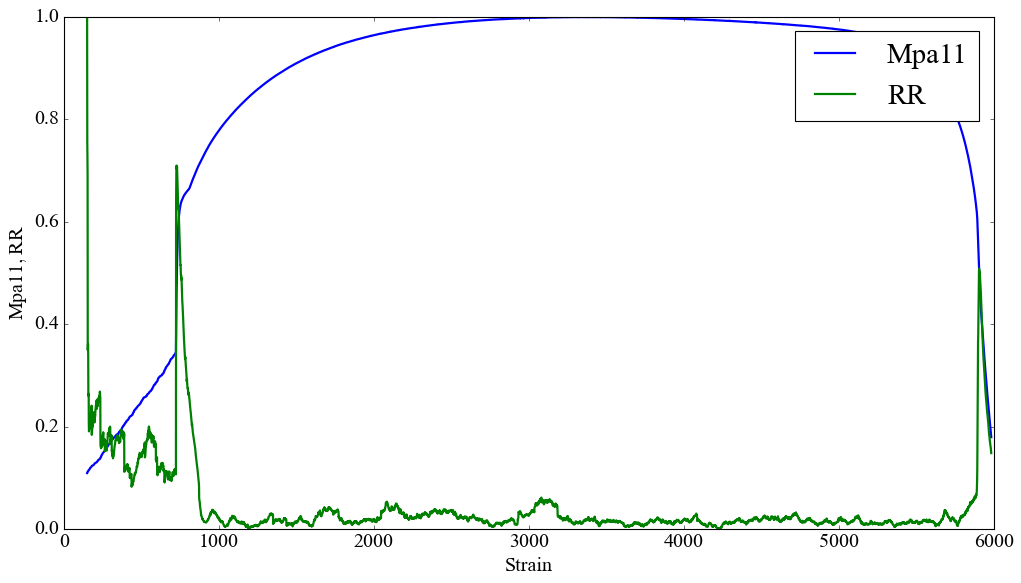

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{symbol_for_graph.split('.')[0]}")
ax.plot(time_ser.index[window:length:tstep], scaled_rr, label="RR")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{symbol_for_graph.split('.')[0]}$,$" + "RR")

plt.savefig(path+f"RR_{symbol.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

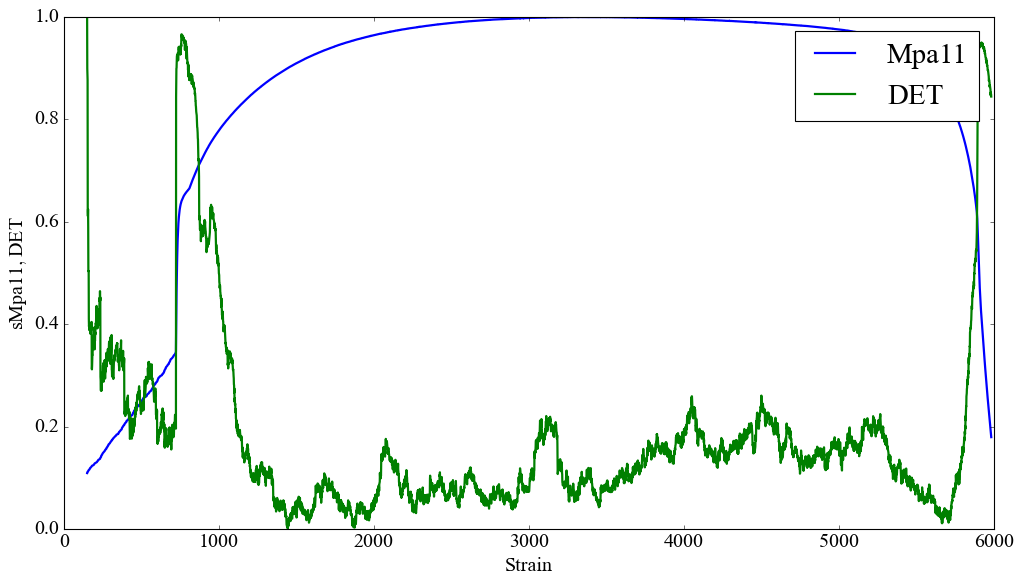

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{symbol_for_graph.split('.')[0]}")
ax.plot(time_ser.index[window:length:tstep], scaled_det, label="DET")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{symbol.split('.')[0]}$,$" + "DET")

plt.savefig(path+f"DET_{symbol.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

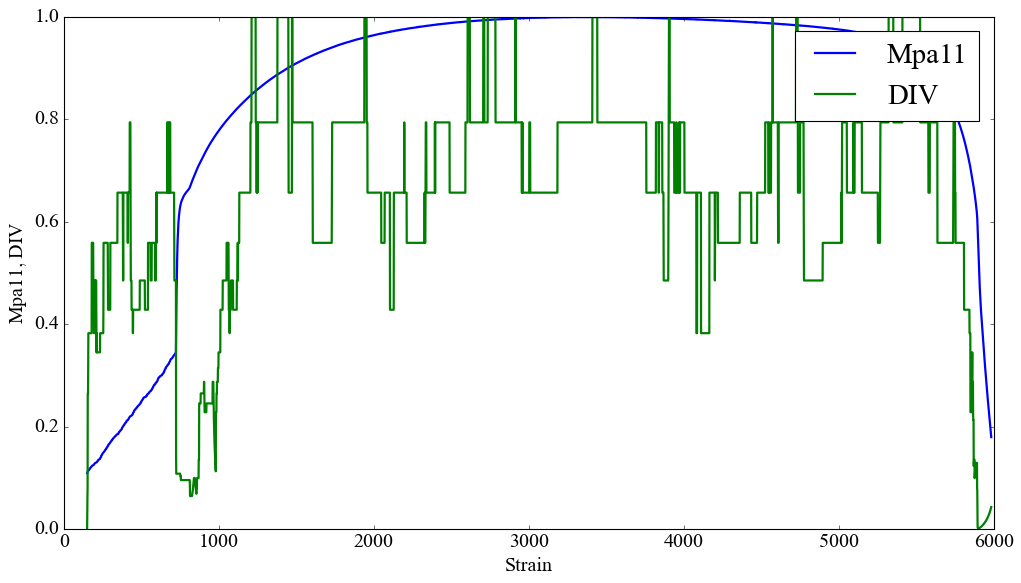

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{symbol_for_graph.split('.')[0]}")
ax.plot(time_ser.index[window:length:tstep], scaled_div, label="DIV")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{symbol_for_graph.split('.')[0]}$,$" + "DIV")

plt.savefig(path+f"DIV_{symbol.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

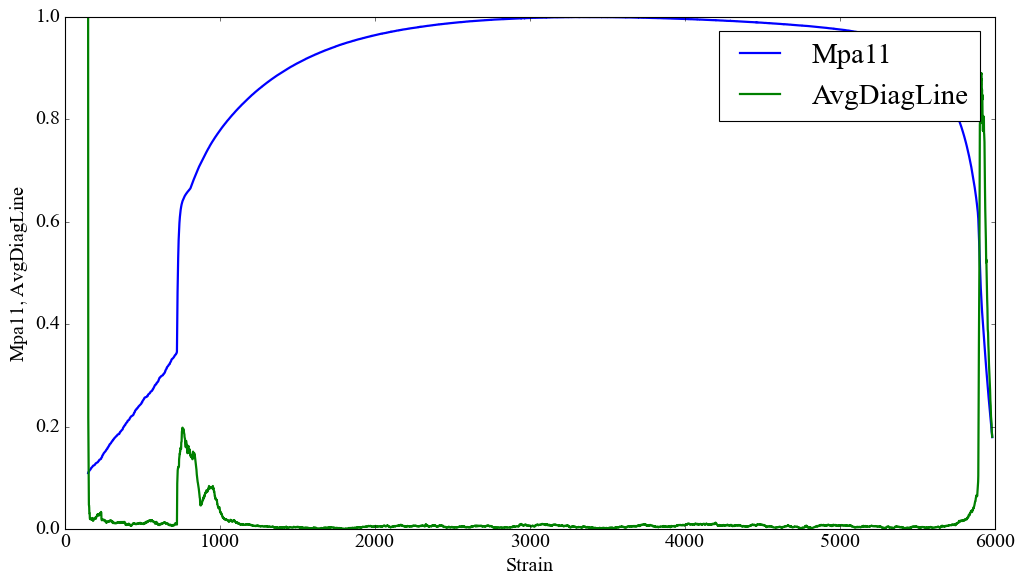

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{symbol_for_graph.split('.')[0]}")
ax.plot(time_ser.index[window:length:tstep], scaled_avg_diag_line, label="AvgDiagLine")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{symbol_for_graph.split('.')[0]}$,$" + "AvgDiagLine")

plt.savefig(path+f"AVG_DIAG_LINE_{symbol.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

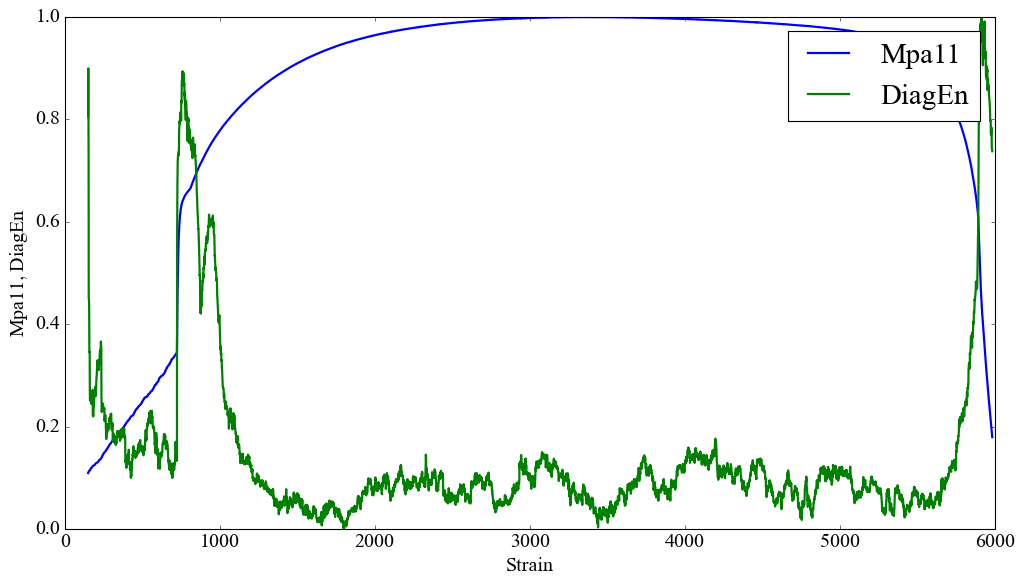

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{symbol_for_graph.split('.')[0]}")
ax.plot(time_ser.index[window:length:tstep], scaled_ent_diag, label="DiagEn")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{symbol_for_graph.split('.')[0]}$,$" + "DiagEn")

plt.savefig(path+f"ENT_DIAG_{symbol.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

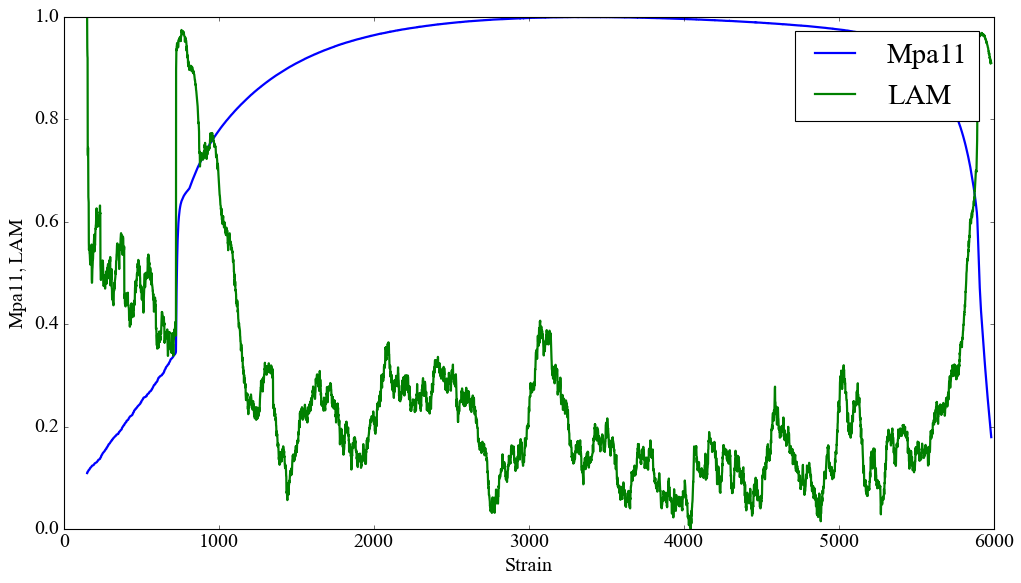

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{symbol_for_graph.split('.')[0]}")
ax.plot(time_ser.index[window:length:tstep], scaled_lam, label="LAM")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{symbol_for_graph.split('.')[0]}$,$" + "LAM")

plt.savefig(path+f"LAM_{symbol.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

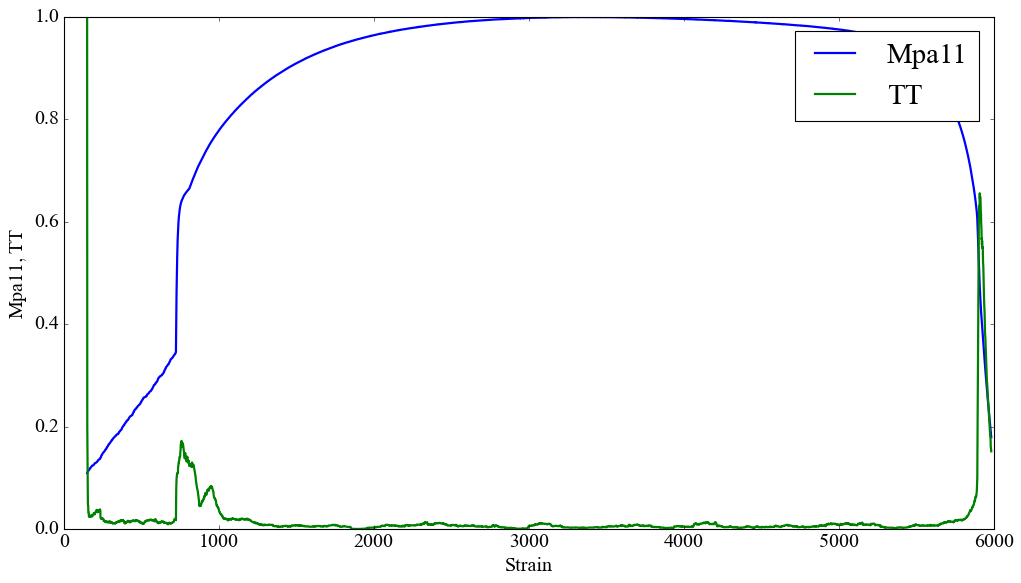

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{symbol_for_graph.split('.')[0]}")
ax.plot(time_ser.index[window:length:tstep], scaled_tt, label="TT")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{symbol_for_graph.split('.')[0]}$,$" + "TT")

plt.savefig(path+f"TRAPPING_TIME_{symbol.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

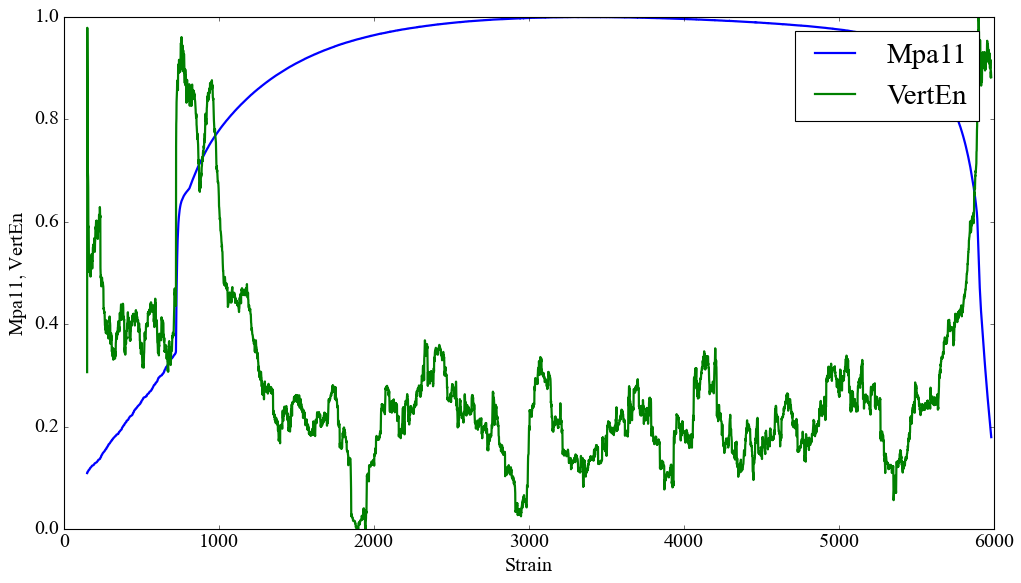

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{symbol_for_graph.split('.')[0]}")
ax.plot(time_ser.index[window:length:tstep], scaled_ent_vert, label="VertEn")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{symbol_for_graph.split('.')[0]}$,$" + "VertEn")

plt.savefig(path+f"VERT_EN_{symbol.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

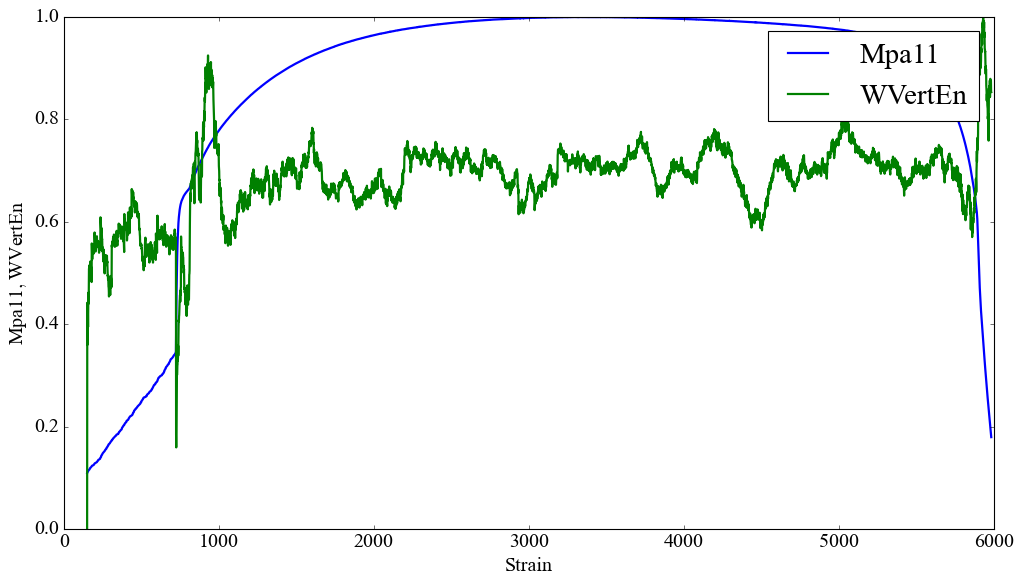

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{symbol_for_graph.split('.')[0]}")
ax.plot(time_ser.index[window:length:tstep], scaled_ent_white_vert, label="WVertEn")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{symbol_for_graph.split('.')[0]}$,$" + "WVertEn")

plt.savefig(path+f"WHITE_VERT_LINE_ENT_{symbol.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

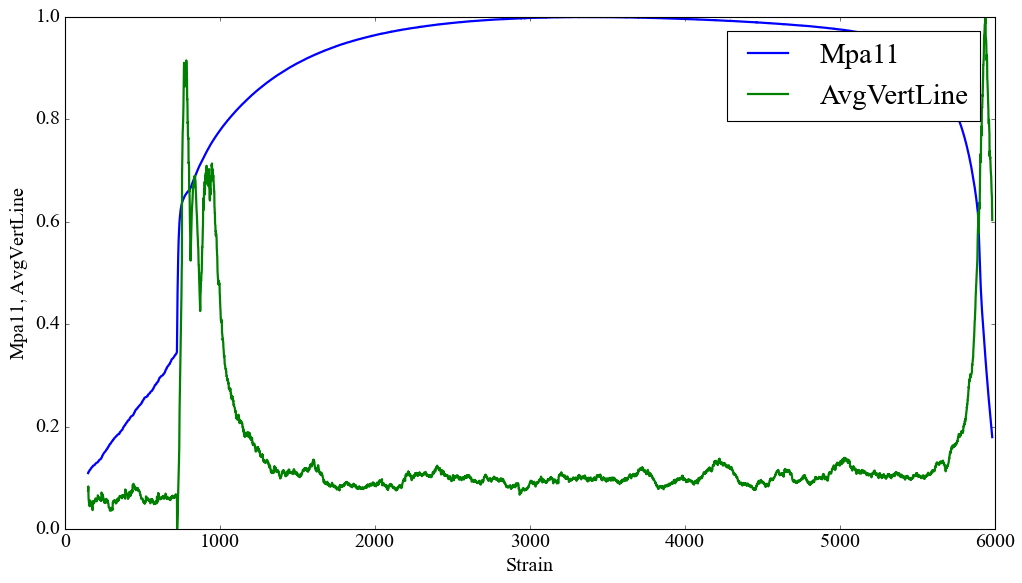

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{symbol_for_graph.split('.')[0]}")
ax.plot(time_ser.index[window:length:tstep], scaled_avg_vert_line, label="AvgVertLine")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{symbol_for_graph.split('.')[0]}$,$" + "AvgVertLine")

plt.savefig(path+f"AVG_VERT_LINE_{symbol.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

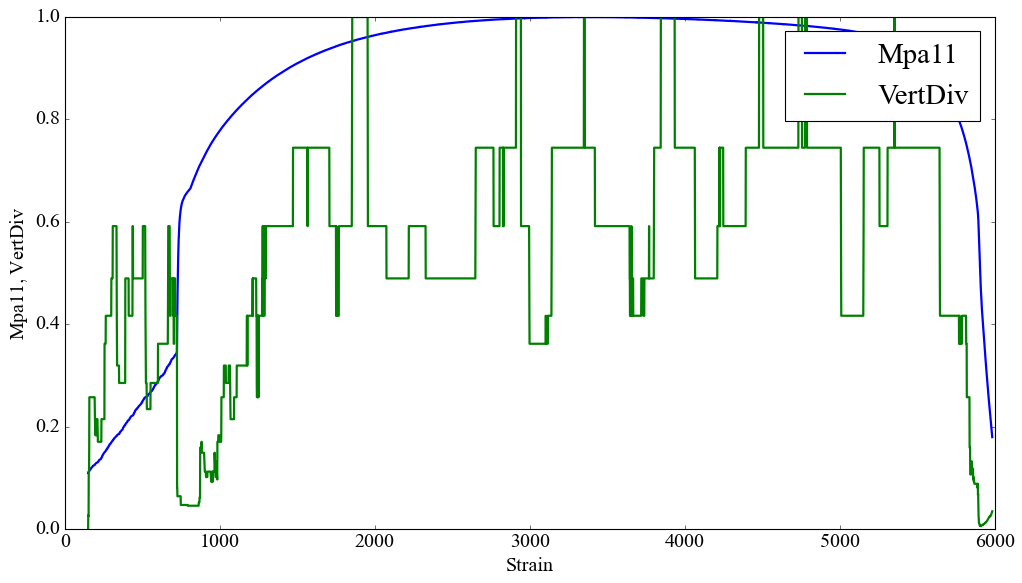

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{symbol_for_graph.split('.')[0]}")
ax.plot(time_ser.index[window:length:tstep], scaled_vert_div, label="VertDiv")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{symbol_for_graph.split('.')[0]}$,$" + "VertDiv")

plt.savefig(path+f"VERT_LINE_DIV_{symbol.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

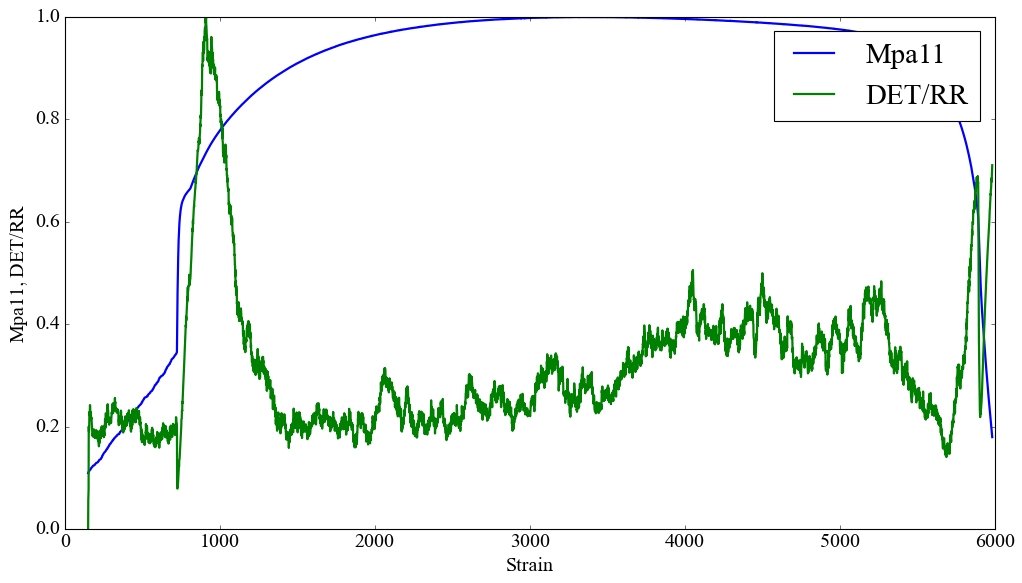

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{symbol_for_graph.split('.')[0]}")
ax.plot(time_ser.index[window:length:tstep], scaled_ratio_det_rec, label="DET/RR")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{symbol_for_graph.split('.')[0]}$,$" + "DET/RR")

plt.savefig(path+f"RATIO_DET_RR_{symbol.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

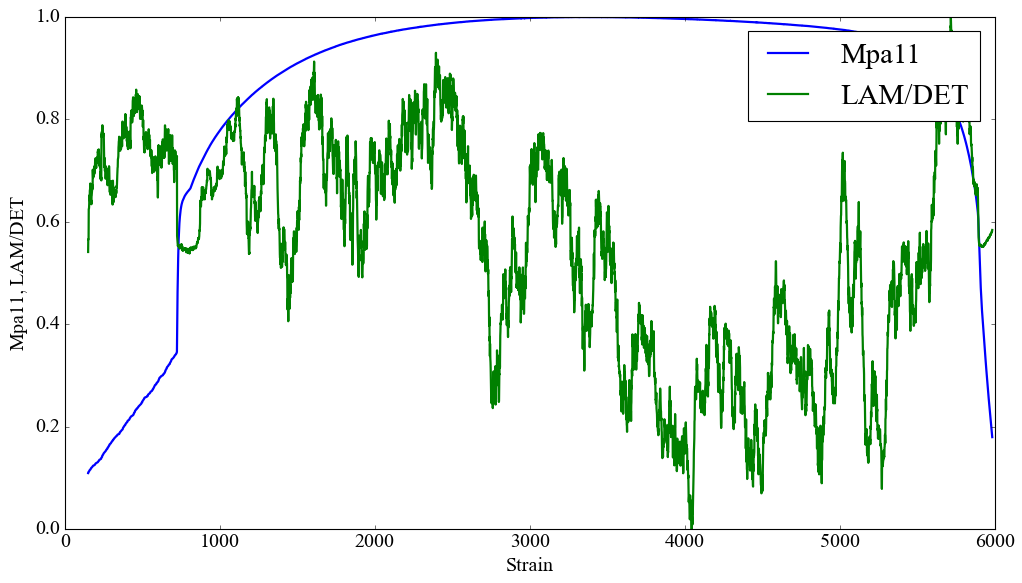

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{symbol_for_graph.split('.')[0]}")
ax.plot(time_ser.index[window:length:tstep], scaled_ratio_lam_det, label="LAM/DET")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{symbol_for_graph.split('.')[0]}$,$" + "LAM/DET")

plt.savefig(path+f"RATIO_LAM_DET_{symbol.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e={d_e}_tau={tau}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()